# MAVLink Anomaly Detection Using Machine Learning

This notebook implements anomaly detection for MAVLink messages using Isolation Forest and Local Outlier Factor (LOF) algorithms.

In [1]:
# Define the path to the pcap files and the output directory
csv_directory = "../datasets/mavlink"
output_directory = "./model_output"

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import joblib

In [3]:
plt.style.use('ggplot')
sns.set_palette("husl")

## 1. Load Data

In [4]:
def load_mavlink_data(data_dir):
    """Load all CSV files from directory and combine them"""
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory {data_dir} does not exist")

    data_path = Path(data_dir)
    all_data = []
    
    index = 0
    for csv_file in os.listdir(data_dir):
        if csv_file.endswith('.csv'):
          df = pd.read_csv(data_path / csv_file)
          # Add source file as a column
          df['source_file'] = csv_file
          all_data.append(df)
          index += 1

          print(f"File Loaded. {index}: {csv_file} - {len(df)} records")
    
    return pd.concat(all_data, ignore_index=True)

# Load all data
df = load_mavlink_data(csv_directory)
print(f"Loaded {len(df)} records from {df['source_file'].nunique()} files")

/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (38,88,99,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,99,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (82,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 1: mavlink_data_20241031_102358.csv - 21851 records
File Loaded. 2: mavlink_data_20241031_102619.csv - 2528 records
File Loaded. 3: mavlink_data_20241031_102913.csv - 33031 records
File Loaded. 4: mavlink_data_20241031_102918.csv - 1 records
File Loaded. 5: mavlink_data_20241031_103228.csv - 22775 records
File Loaded. 6: mavlink_data_20241031_103254.csv - 1 records
File Loaded. 7: mavlink_data_20241031_103524.csv - 2376 records
File Loaded. 8: mavlink_data_20241031_103539.csv - 3629 records
File Loaded. 9: mavlink_data_20241101_151428.csv - 44798 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 10: mavlink_data_20241101_151906.csv - 59743 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 11: mavlink_data_20241101_152504.csv - 81420 records
File Loaded. 12: mavlink_data_20241101_152510.csv - 3944 records
File Loaded. 13: mavlink_data_20241101_152514.csv - 616 records
File Loaded. 14: mavlink_data_20241101_153508.csv - 64930 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 15: mavlink_data_20241101_153913.csv - 56409 records
File Loaded. 16: mavlink_data_20241101_153956.csv - 1 records
File Loaded. 17: mavlink_data_20241101_154428.csv - 72904 records
File Loaded. 18: mavlink_data_20241101_155905.csv - 159 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 19: mavlink_data_20241101_160537.csv - 59671 records
File Loaded. 20: mavlink_data_20241101_161005.csv - 65792 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 21: mavlink_data_20241101_161341.csv - 50579 records
File Loaded. 22: mavlink_data_20241101_162424.csv - 90471 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,99,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 23: mavlink_data_20241101_163432.csv - 135705 records
File Loaded. 24: mavlink_data_20241101_164607.csv - 76878 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (34,82,93,95,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (38,88,99,101,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 25: mavlink_data_20241101_170019.csv - 39119 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 26: mavlink_data_20241101_170936.csv - 103923 records


/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (38,88,99,101,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (82,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (34,82,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (81,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/tmp/ipykernel_5349/4286704174.py:12: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 27: mavlink_data_20241101_171646.csv - 103644 records
File Loaded. 28: mavlink_data_20241117_234604_gpj.csv - 15126 records
File Loaded. 29: mavlink_data_20241117_234716_rn.csv - 13760 records
File Loaded. 30: mavlink_data_20241117_234731_rf.csv - 21672 records
File Loaded. 31: mavlink_data_20241118_000809_ggd.csv - 4273 records
Loaded 1251729 records from 31 files


## 2. Data Visualization

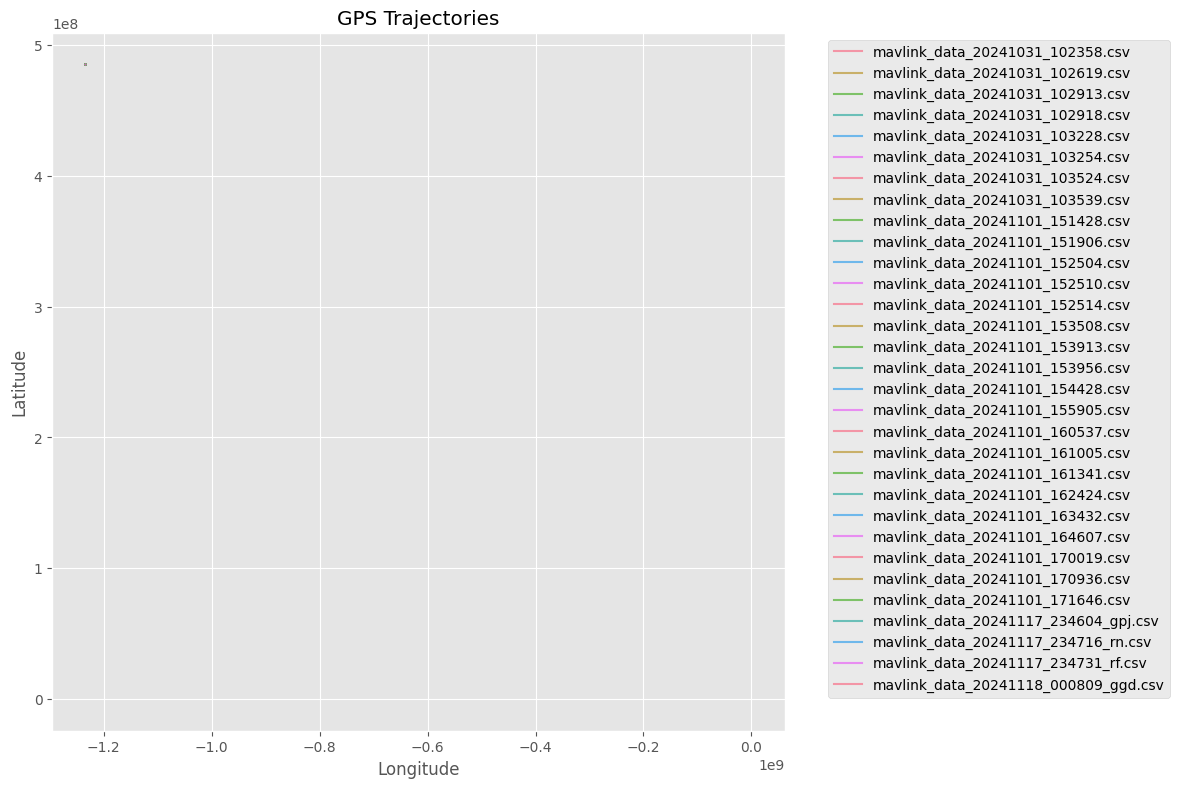

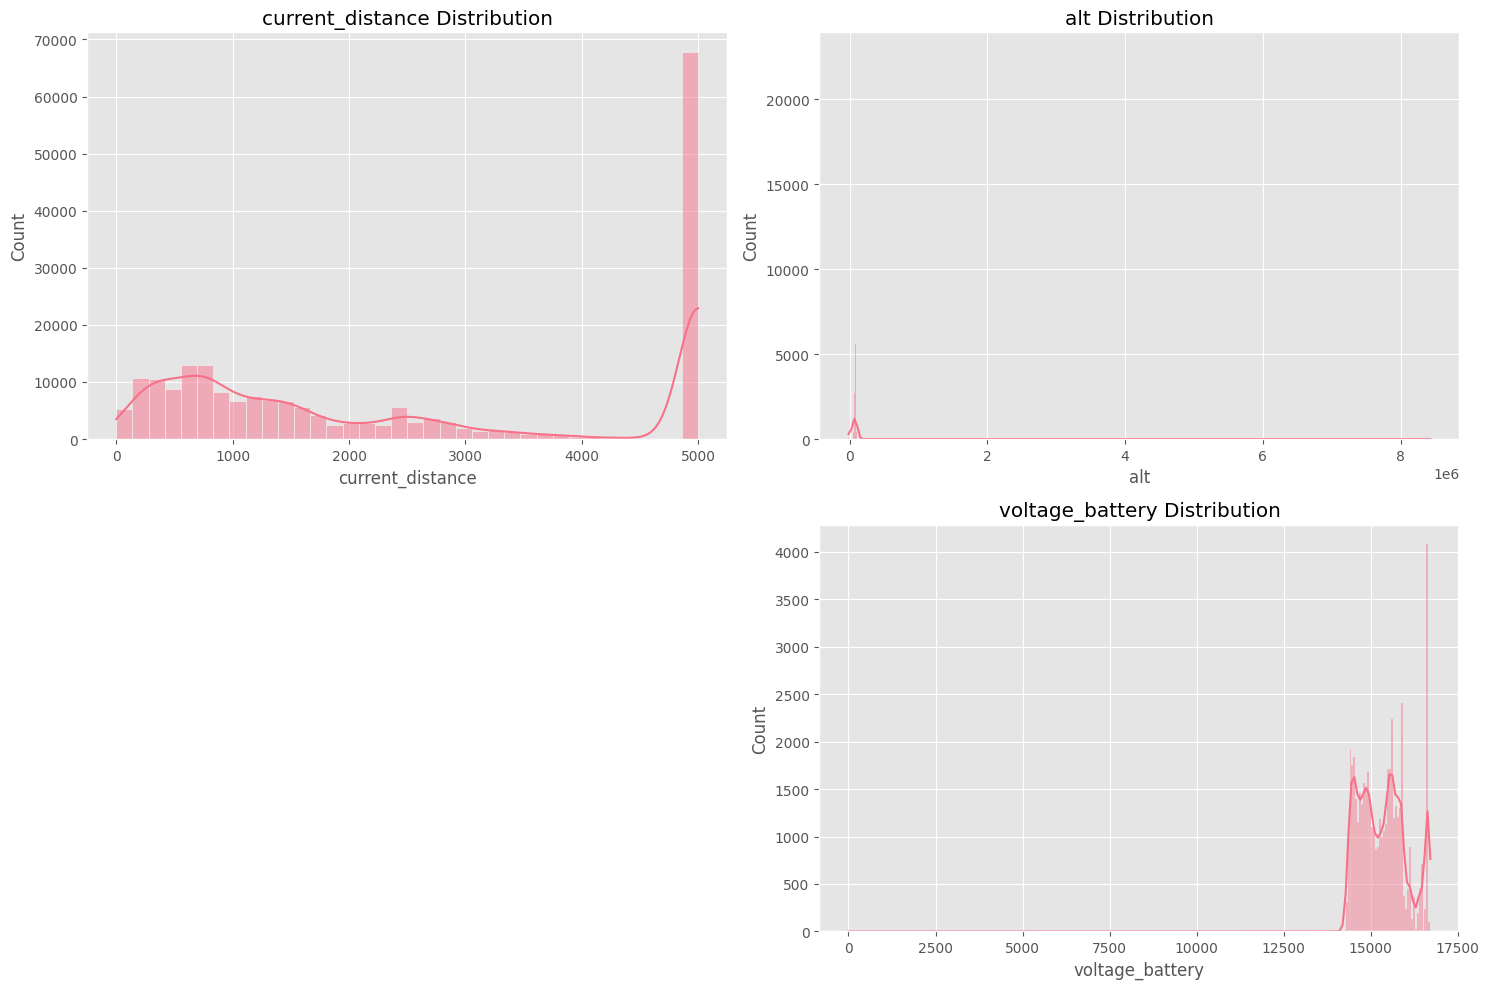

/tmp/ipykernel_5349/2125338050.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


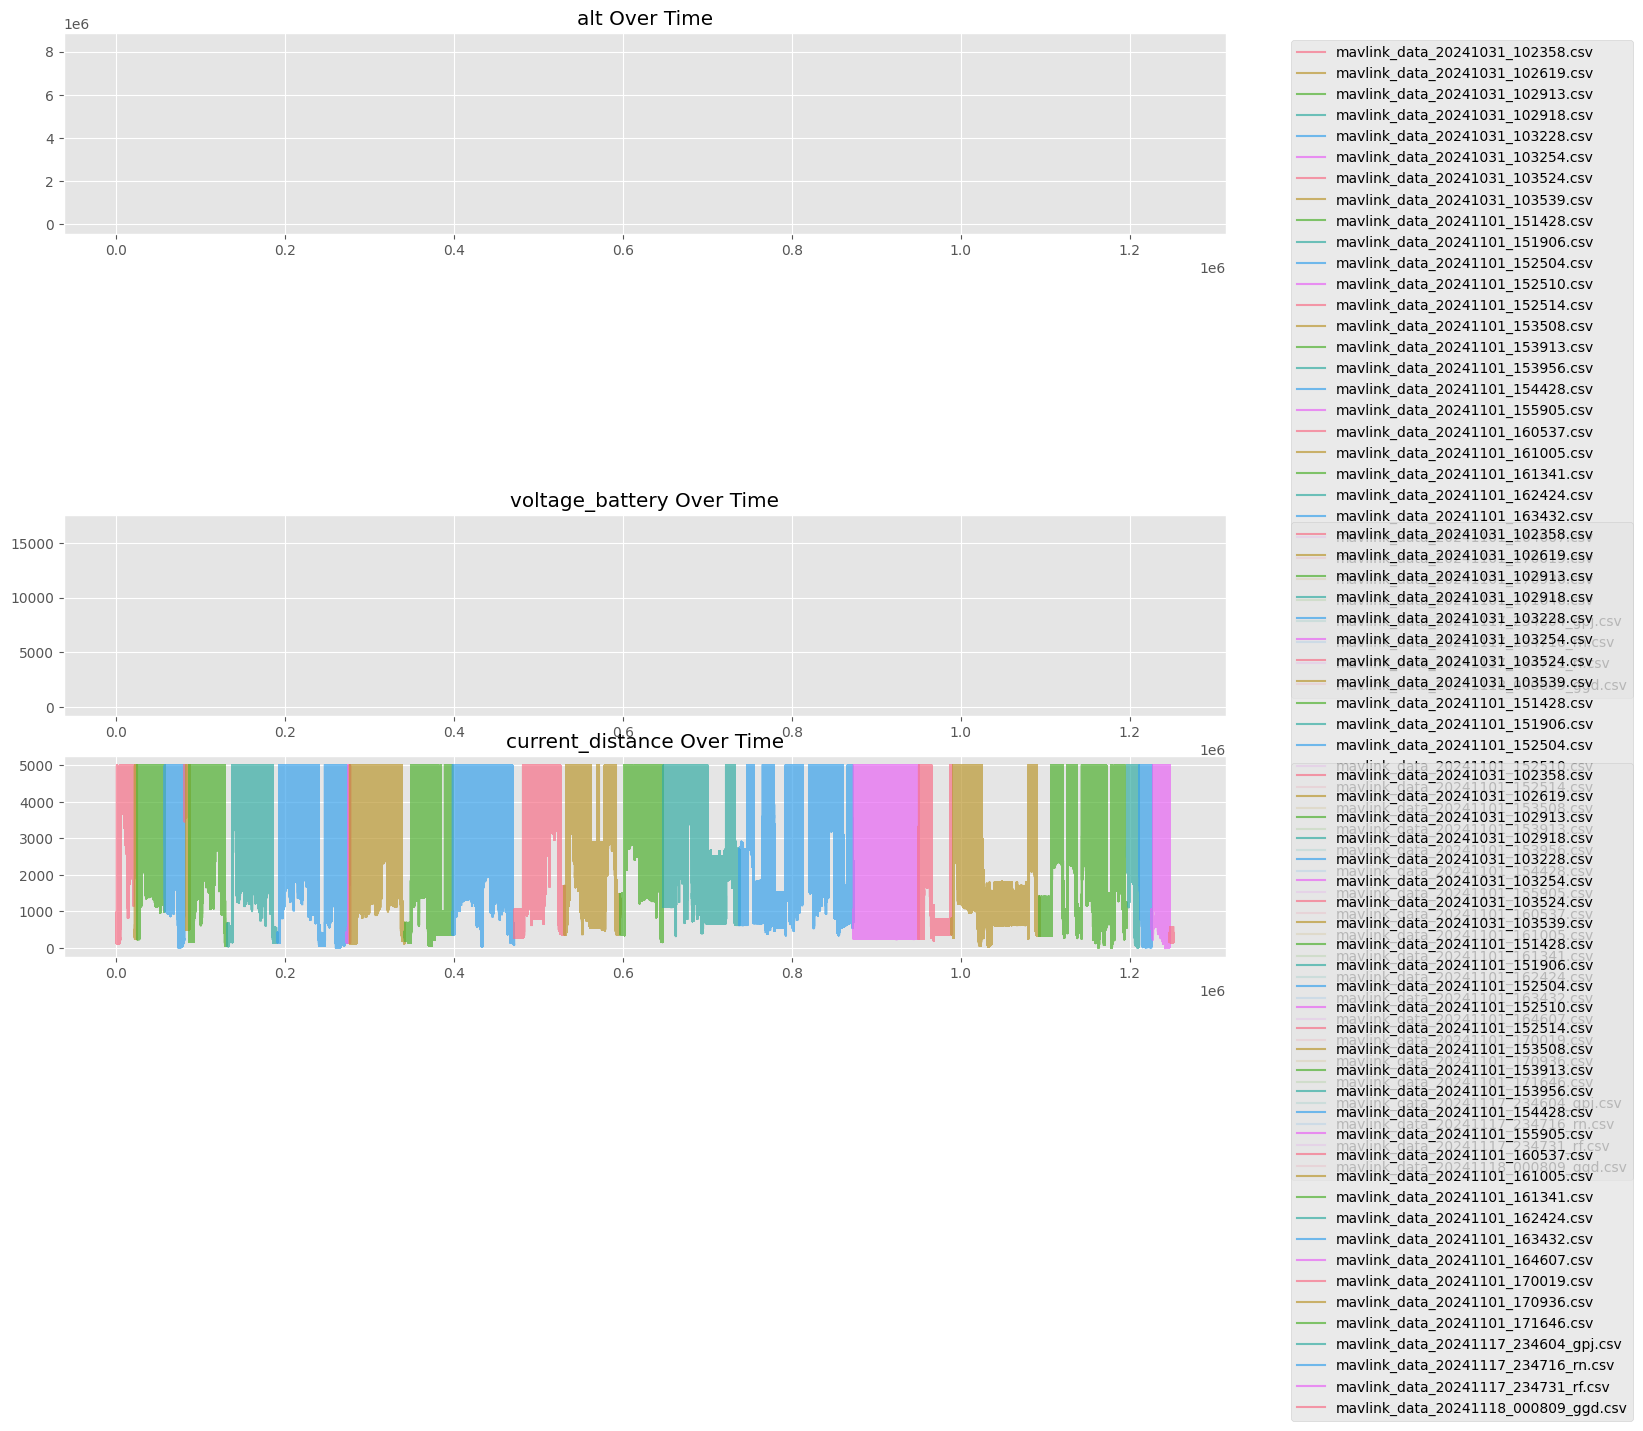

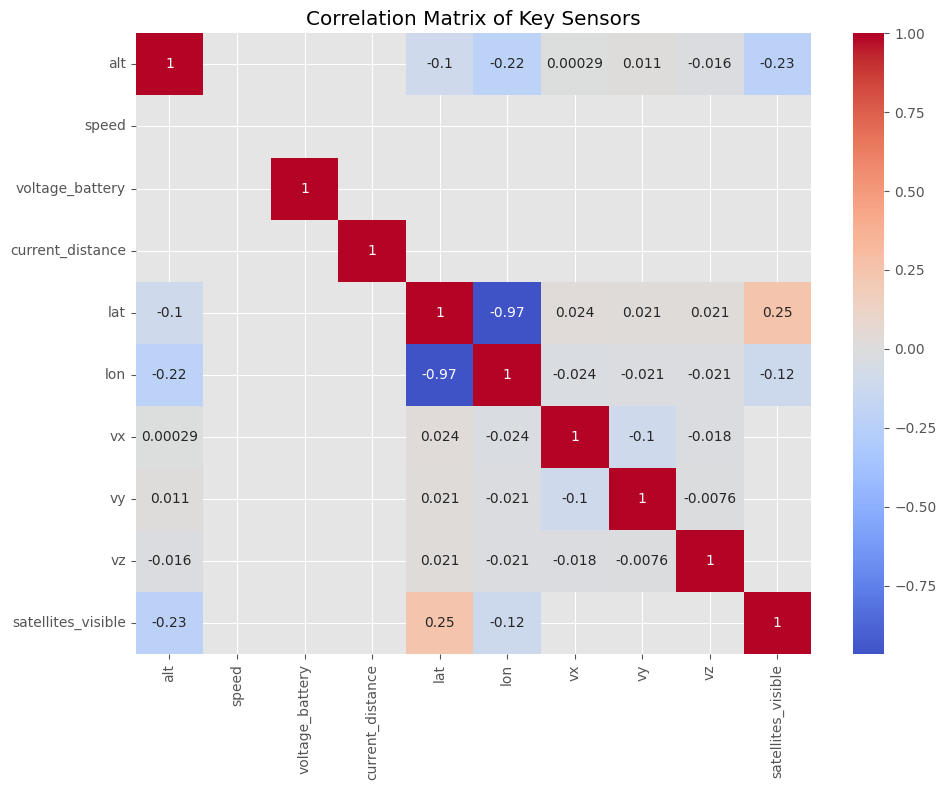

In [5]:
def plot_gps_trajectory(df):
    """Plot GPS trajectories"""
    plt.figure(figsize=(12, 8))
    for file in df['source_file'].unique():
        file_data = df[df['source_file'] == file]
        plt.plot(file_data['longitude'], file_data['latitude'], 
                label=file, alpha=0.7)
    plt.title('GPS Trajectories')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_sensor_distributions(df):
    """Plot distributions of key sensor readings"""
    sensors = ['current_distance', 'alt', 'groundspeed', 'voltage_battery']
    plt.figure(figsize=(15, 10))
    
    for i, sensor in enumerate(sensors, 1):
        if sensor in df.columns:
            plt.subplot(2, 2, i)
            sns.histplot(df[sensor].dropna(), kde=True)
            plt.title(f'{sensor} Distribution')
            
    plt.tight_layout()
    plt.show()

def plot_time_series(df):
    """Plot time series of key measurements"""
    metrics = ['alt', 'groundspeed', 'voltage_battery', 'current_distance']
    plt.figure(figsize=(15, 12))
    
    for i, metric in enumerate(metrics, 1):
        if metric in df.columns:
            plt.subplot(len(metrics), 1, i)
            for file in df['source_file'].unique():
                file_data = df[df['source_file'] == file]
                plt.plot(file_data.index, file_data[metric], 
                        label=file, alpha=0.7)
            plt.title(f'{metric} Over Time')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Generate plots
plot_gps_trajectory(df)
plot_sensor_distributions(df)
plot_time_series(df)

# Correlation analysis
sensor_cols = ['alt', 'speed', 'voltage_battery', 'current_distance',
    'lat', 'lon', 'vx', 'vy', 'vz', 'satellites_visible']
corr_matrix = df[sensor_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Sensors')
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [ ]:
def engineer_features(df):
    """Create features for anomaly detection with proper NaN handling"""
    features = pd.DataFrame()
    
    # First get timestamps for temporal features
    if 'time_boot_ms' in df.columns:
        features['timestamp'] = pd.to_numeric(df['time_boot_ms'], errors='coerce')
    elif 'time_usec' in df.columns:
        features['timestamp'] = pd.to_numeric(df['time_usec'], errors='coerce') / 1000
    
    # GPS-based features
    gps_cols = ['lat', 'lon', 'alt', 'vx', 'vy', 'vz']
    if all(col in df.columns for col in gps_cols):
        # Calculate speed from velocity components
        features['gps_speed'] = np.sqrt(
            df['vx'].fillna(0)**2 + 
            df['vy'].fillna(0)**2
        )
        features['gps_vert_speed'] = df['vz'].fillna(0)
        
        # Add position accuracy if available
        if 'eph' in df.columns:
            features['gps_accuracy'] = df['eph'].ffill()
    
    # Rangefinder features
    if 'current_distance' in df.columns:
        features['ground_distance'] = df['current_distance'].ffill()
        if 'signal_quality' in df.columns:
            features['distance_quality'] = df['signal_quality'].fillna(0)
    
    # IMU-based features
    imu_cols = ['xacc', 'yacc', 'zacc']
    if all(col in df.columns for col in imu_cols):
        # Fill NaN with 0 for acceleration components
        features['total_acceleration'] = np.sqrt(
            df['xacc'].fillna(0)**2 + 
            df['yacc'].fillna(0)**2 + 
            df['zacc'].fillna(0)**2
        )
    
    # System status features
    if 'voltage_battery' in df.columns:
        features['voltage'] = df['voltage_battery'].ffill()
    
    # Calculate rolling statistics
    window = 10  # 10-point rolling window
    for col in features.columns:
        if col != 'timestamp':  # Skip timestamp for rolling calculations
            features[f'{col}_roll_mean'] = features[col].rolling(
                window, min_periods=1).mean()
            features[f'{col}_roll_std'] = features[col].rolling(
                window, min_periods=1).std().fillna(0)
    
    # Drop columns with too many NaN values
    nan_ratio = features.isna().sum() / len(features)
    features = features.drop(columns=nan_ratio[nan_ratio > 0.5].index)
    
    # Final NaN cleanup
    # 1. Forward fill remaining NaNs
    features = features.ffill()
    # 2. Backward fill any remaining NaNs at the start
    features = features.bfill
    # 3. Fill any still remaining NaNs with 0
    features = features.fillna(0)

    # Remove timestamp if it was added
    if 'timestamp' in features.columns:
        features = features.drop(columns=['timestamp'])
    
    # Verify no NaNs remain
    assert not features.isna().any().any(), "NaN values still present in features"
    
    return features

# Create and prepare feature matrix
print("Engineering features...")
X = engineer_features(df)
print("Created features:", X.columns.tolist())

# Verify no NaNs in feature matrix
print("\nFeature matrix shape:", X.shape)
print("NaN values remaining:", X.isna().sum().sum())

# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Additional check for NaNs after scaling
assert not np.isnan(X_scaled).any(), "NaN values found after scaling"

print("Feature engineering complete!")

Engineering features...


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

Created features: ['gps_speed', 'gps_vert_speed', 'gps_accuracy', 'ground_distance', 'distance_quality', 'total_acceleration', 'voltage', 'gps_speed_roll_mean', 'gps_speed_roll_std', 'gps_vert_speed_roll_mean', 'gps_vert_speed_roll_std', 'gps_accuracy_roll_mean', 'gps_accuracy_roll_std', 'ground_distance_roll_mean', 'ground_distance_roll_std', 'distance_quality_roll_mean', 'distance_quality_roll_std', 'total_acceleration_roll_mean', 'total_acceleration_roll_std', 'voltage_roll_mean', 'voltage_roll_std']

Feature matrix shape: (1251729, 21)
NaN values remaining: 0

Scaling features...
Feature engineering complete!


## 4. Model Training

In [7]:
def train_isolation_forest(X_scaled):
    """Train Isolation Forest model"""
    print("Training Isolation Forest...")

    iso_forest = IsolationForest(
        n_estimators=100,
        contamination=0.1,  # Expected proportion of anomalies
        random_state=42
    )
    iso_forest.fit(X_scaled)
    return iso_forest

def train_lof(X_scaled):
    """Train Local Outlier Factor model"""
    print("Training Local Outlier Factor...")

    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.1,
        novelty=True  # Enable predict method
    )
    lof.fit(X_scaled)
    return lof

# Split data
print("Splitting data...")
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Train models
iso_forest = train_isolation_forest(X_train)
lof = train_lof(X_train)

print("Models trained successfully")

Splitting data...
Training Isolation Forest...
Training Local Outlier Factor...
Models trained successfully


## 5. Model Evaluation

Evaluating individual flights...

Analyzing flight: mavlink_data_20241031_102358.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

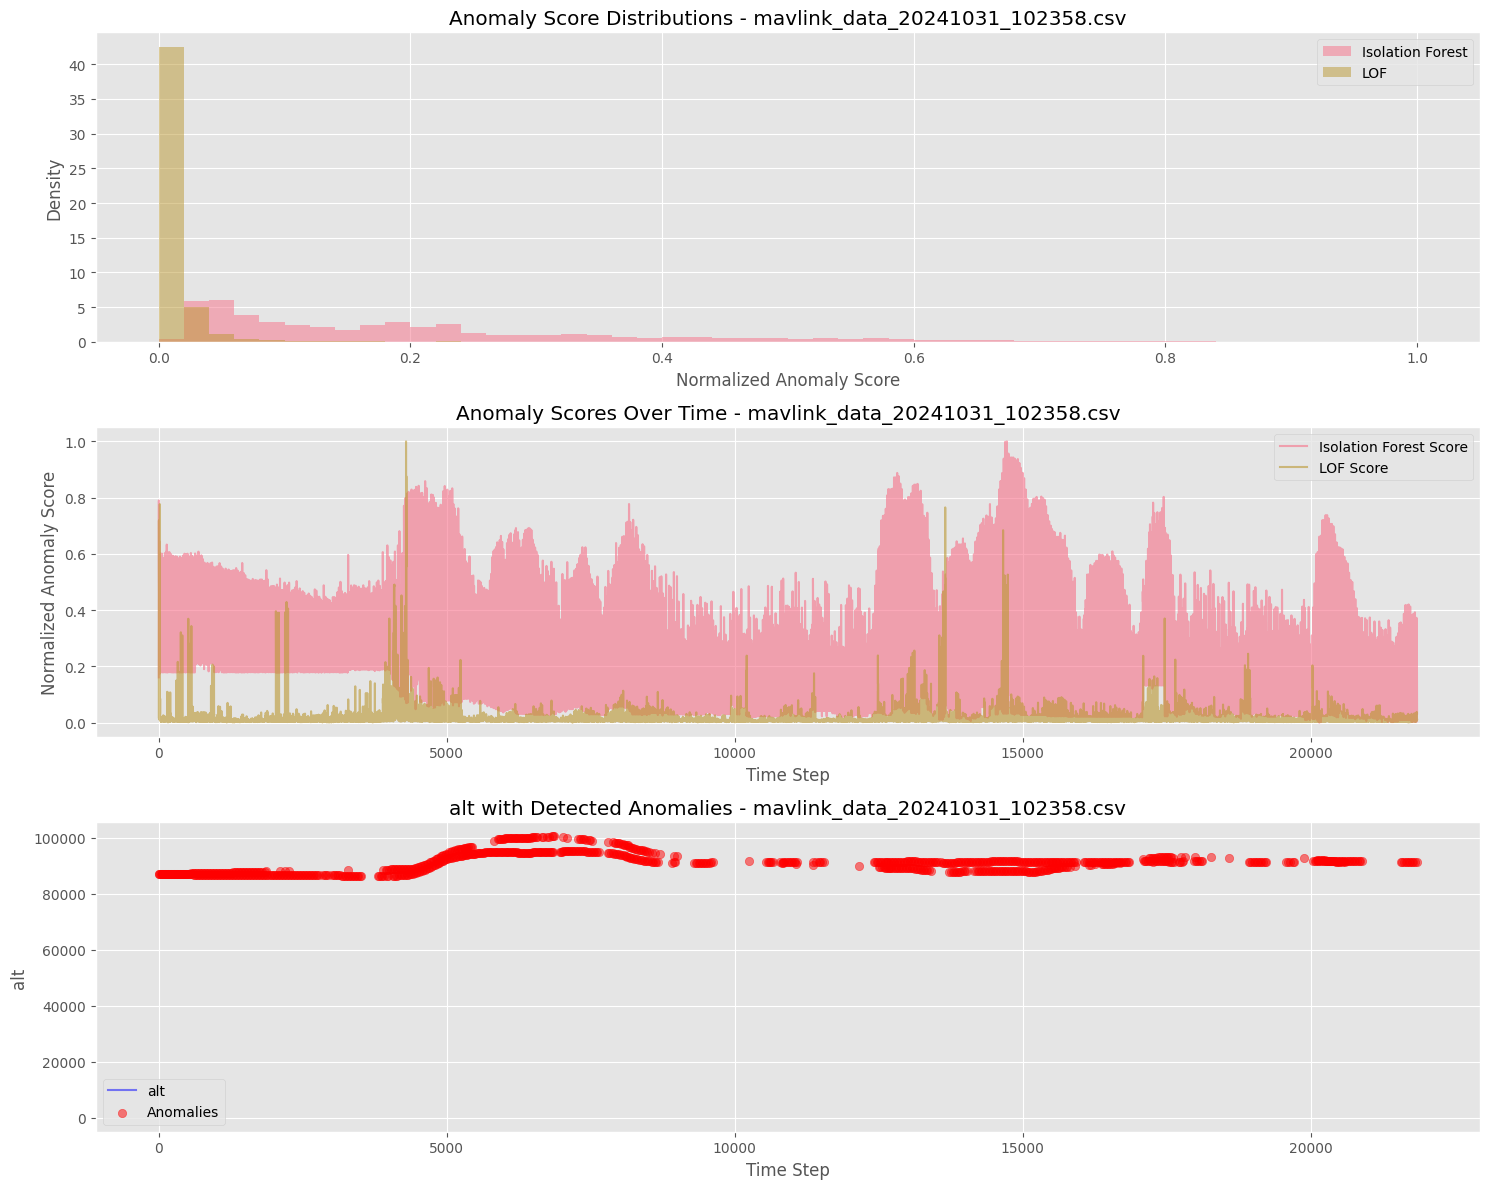


Summary Statistics:
Total data points: 21851
Isolation Forest anomalies: 4220 (19.31%)
LOF anomalies: 2106 (9.64%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.203
  Std: 0.176
  Max: 1.000
LOF scores:
  Mean: 0.014
  Std: 0.031
  Max: 1.000

Analyzing flight: mavlink_data_20241031_102619.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

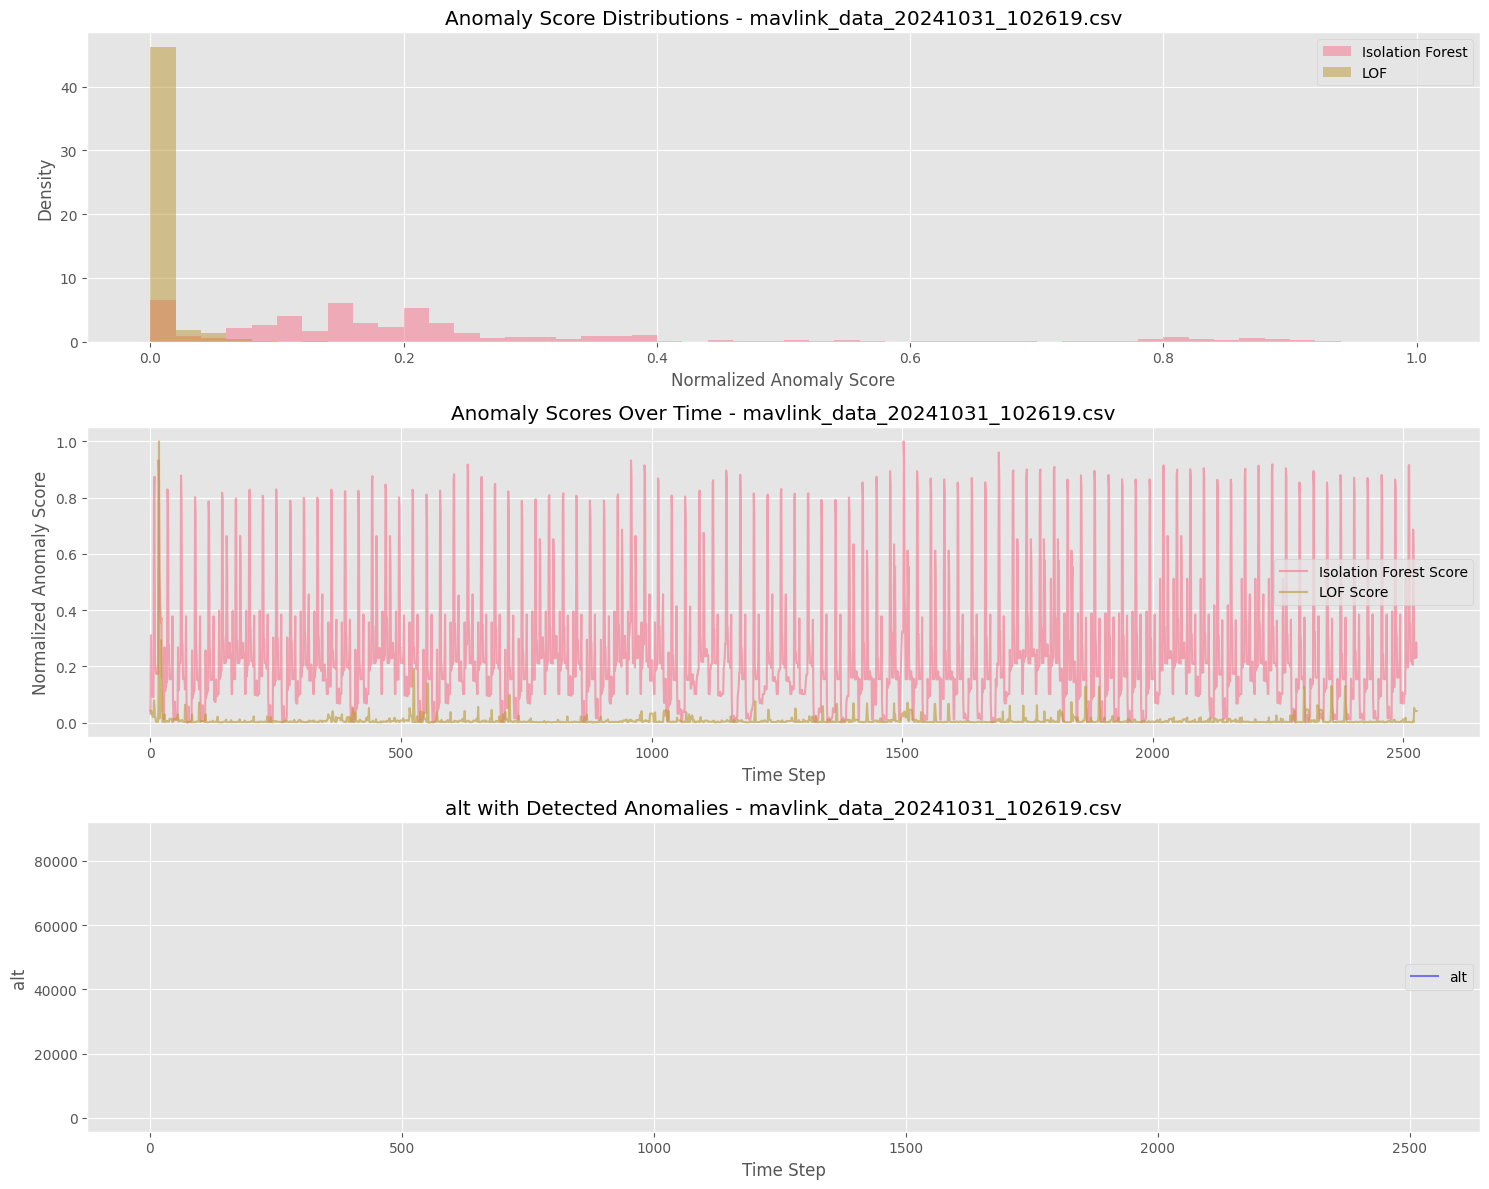


Summary Statistics:
Total data points: 2528
Isolation Forest anomalies: 0 (0.00%)
LOF anomalies: 296 (11.71%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.219
  Std: 0.211
  Max: 1.000
LOF scores:
  Mean: 0.008
  Std: 0.025
  Max: 1.000

Analyzing flight: mavlink_data_20241031_102913.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

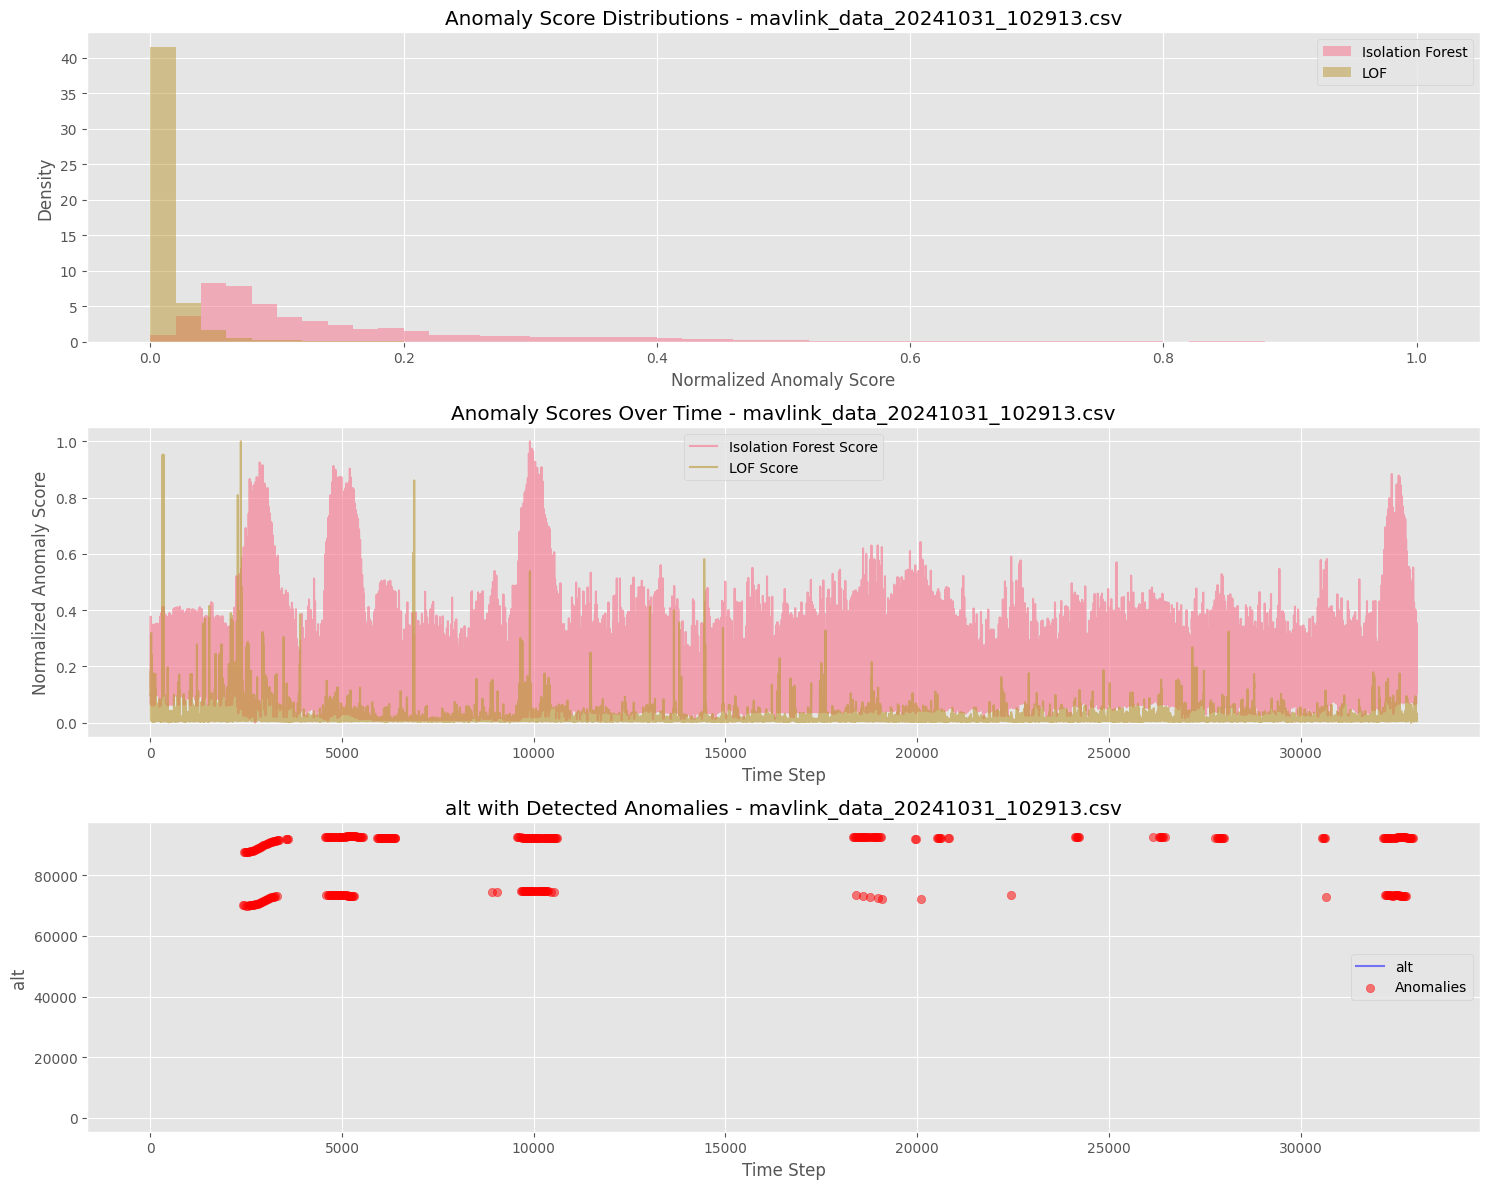


Summary Statistics:
Total data points: 33031
Isolation Forest anomalies: 1688 (5.11%)
LOF anomalies: 2942 (8.91%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.148
  Std: 0.135
  Max: 1.000
LOF scores:
  Mean: 0.016
  Std: 0.029
  Max: 1.000

Analyzing flight: mavlink_data_20241031_102918.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

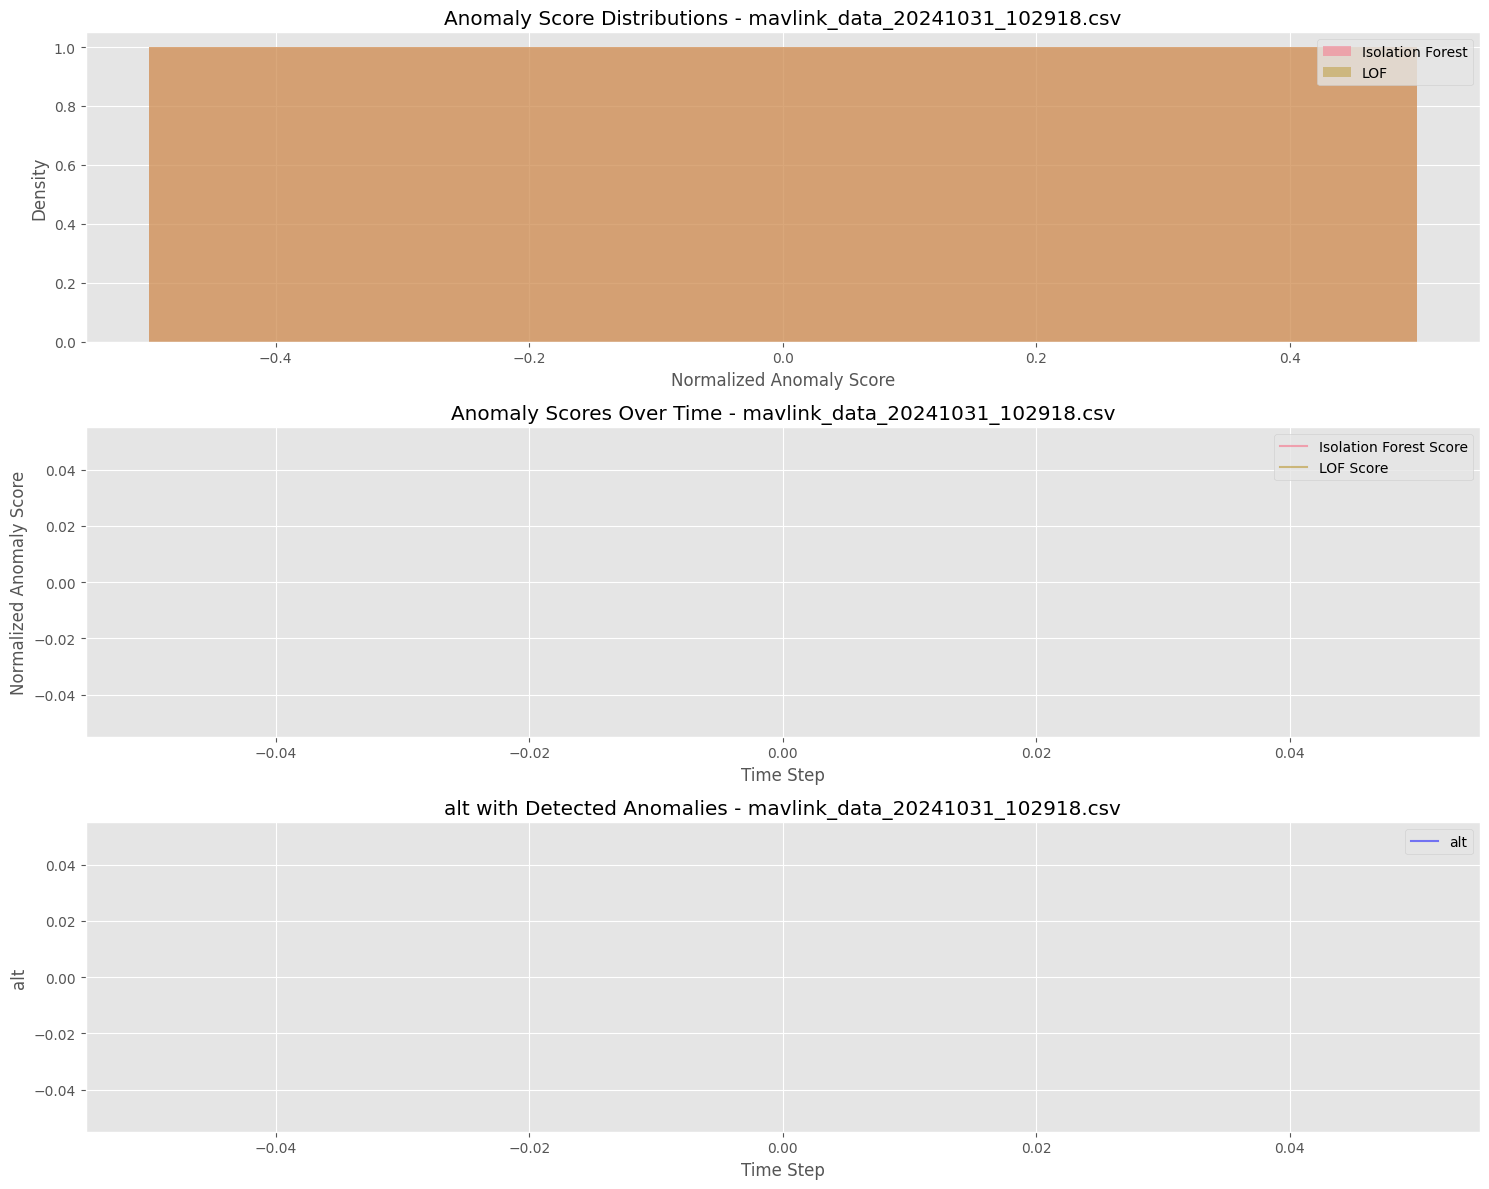


Summary Statistics:
Total data points: 1
Isolation Forest anomalies: 0 (0.00%)
LOF anomalies: 1 (100.00%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.000
  Std: 0.000
  Max: 0.000
LOF scores:
  Mean: 0.000
  Std: 0.000
  Max: 0.000

Analyzing flight: mavlink_data_20241031_103228.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

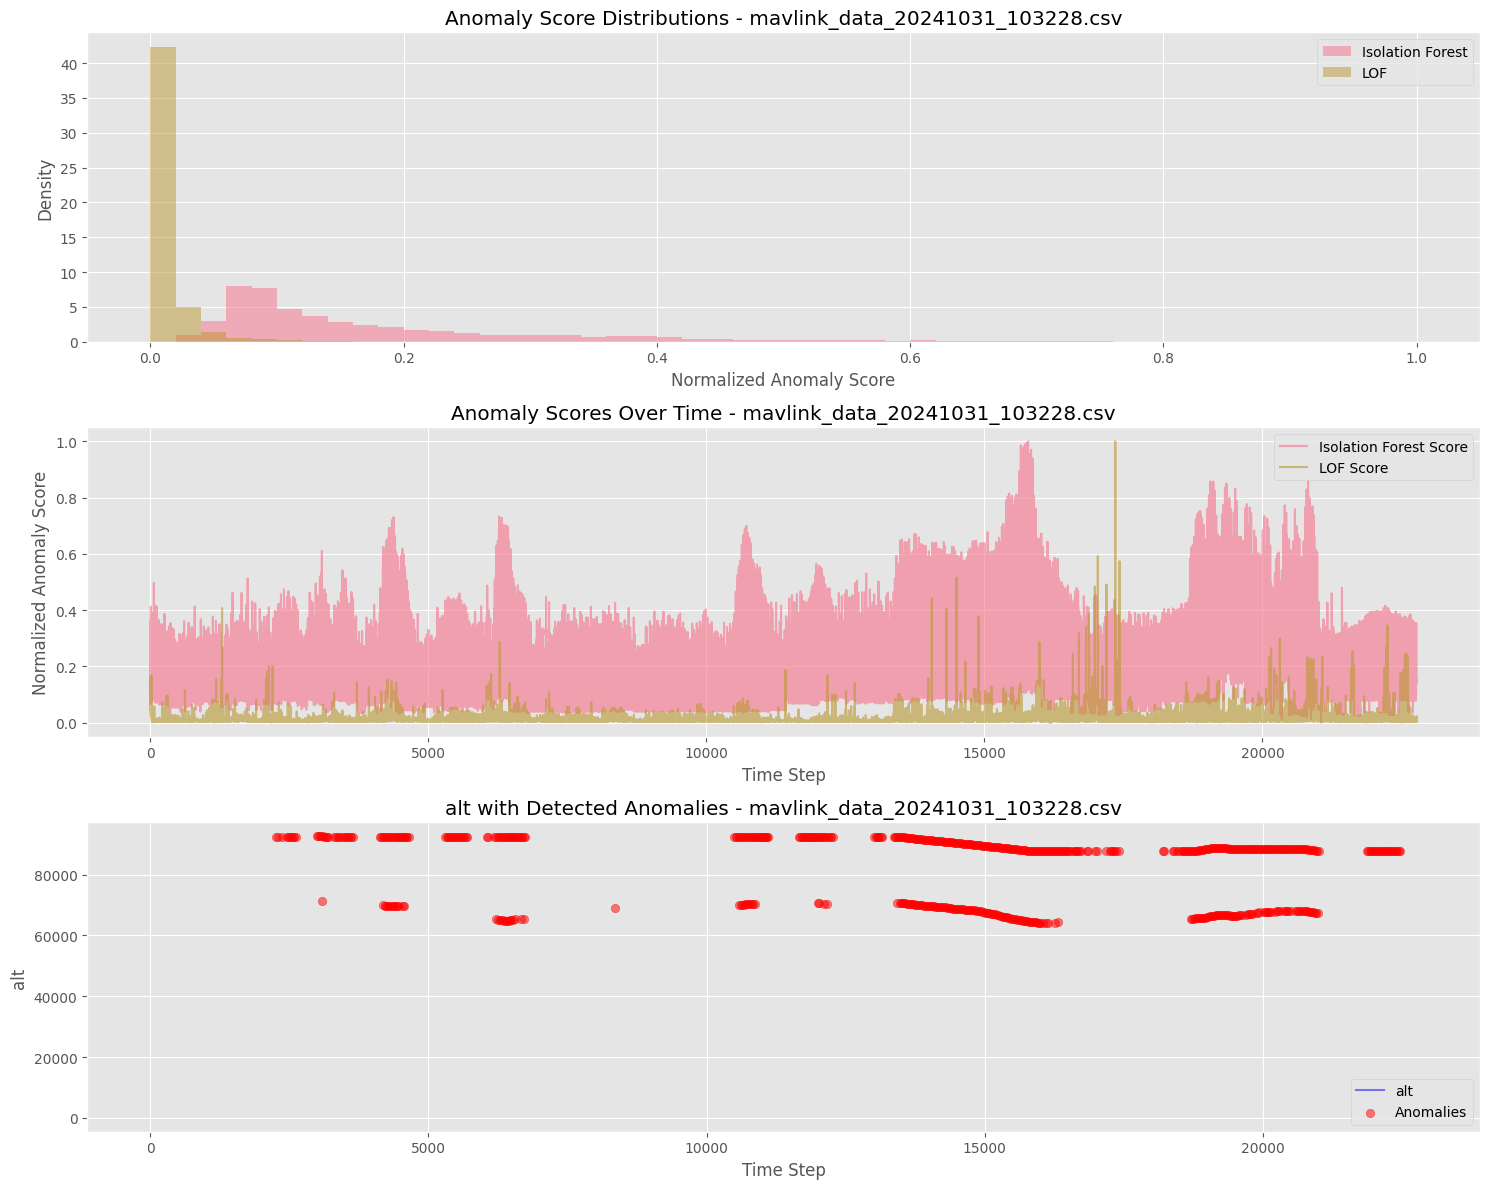


Summary Statistics:
Total data points: 22775
Isolation Forest anomalies: 2282 (10.02%)
LOF anomalies: 2830 (12.43%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.175
  Std: 0.136
  Max: 1.000
LOF scores:
  Mean: 0.013
  Std: 0.023
  Max: 1.000

Analyzing flight: mavlink_data_20241031_103254.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

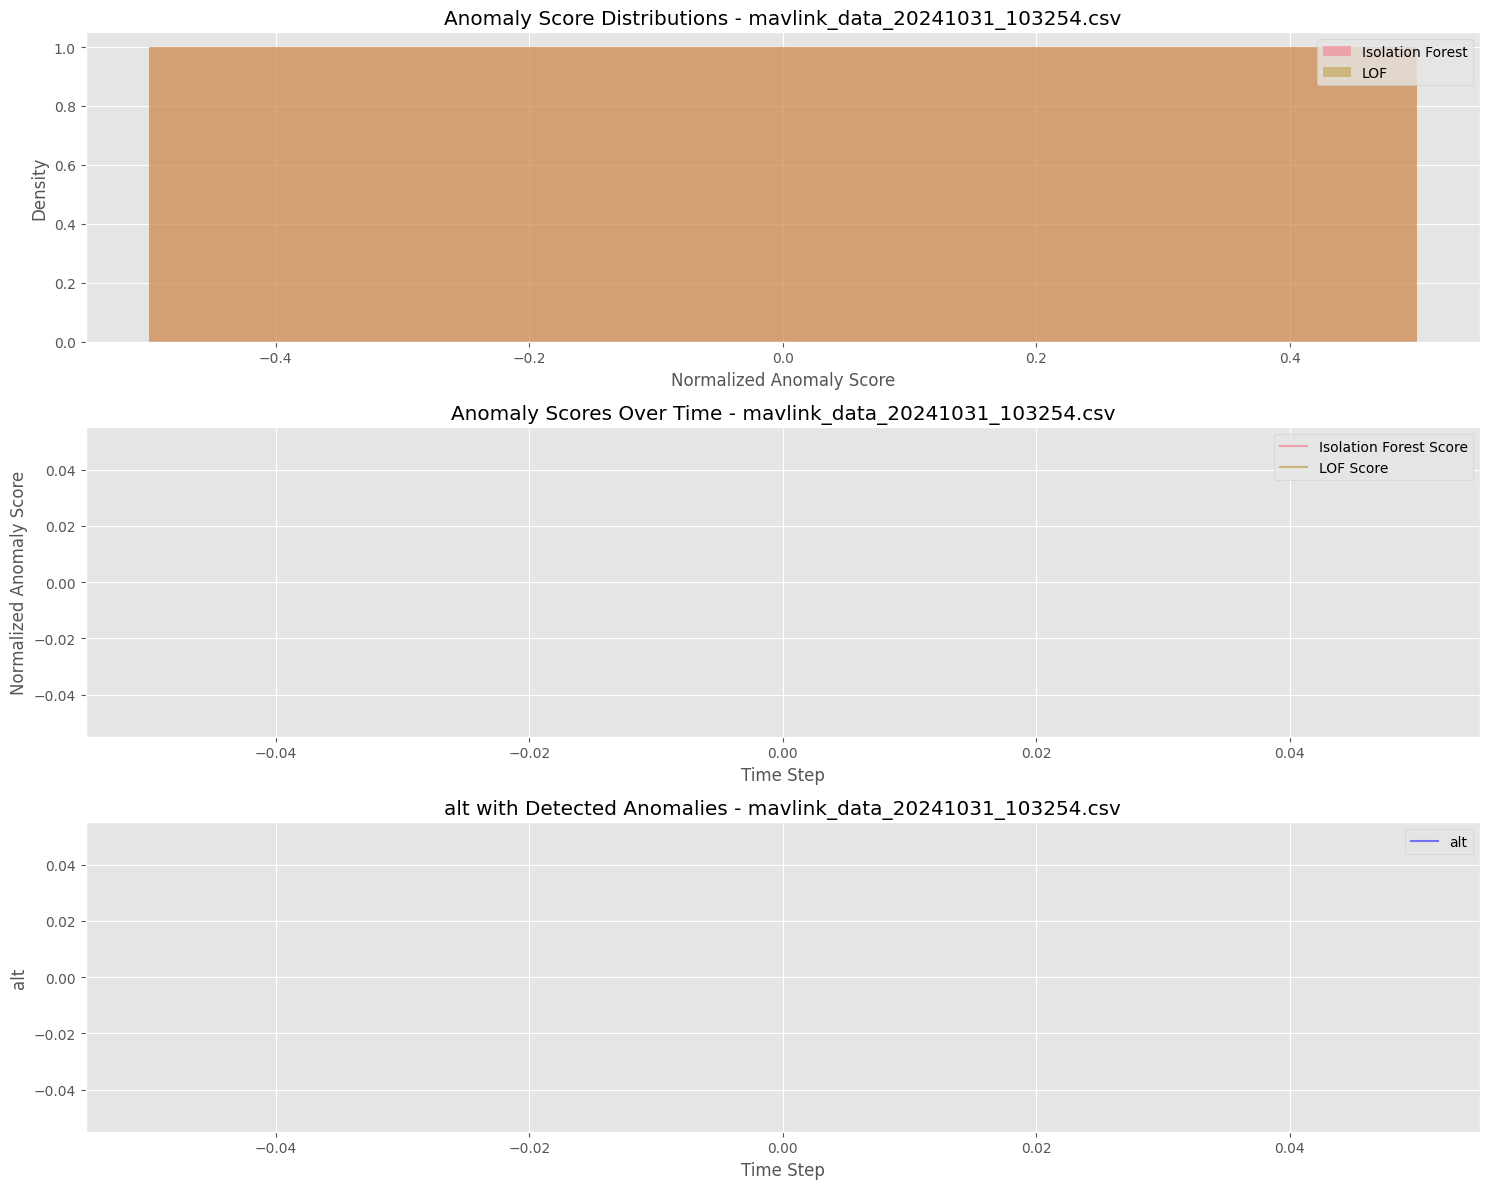


Summary Statistics:
Total data points: 1
Isolation Forest anomalies: 0 (0.00%)
LOF anomalies: 1 (100.00%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.000
  Std: 0.000
  Max: 0.000
LOF scores:
  Mean: 0.000
  Std: 0.000
  Max: 0.000

Analyzing flight: mavlink_data_20241031_103524.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

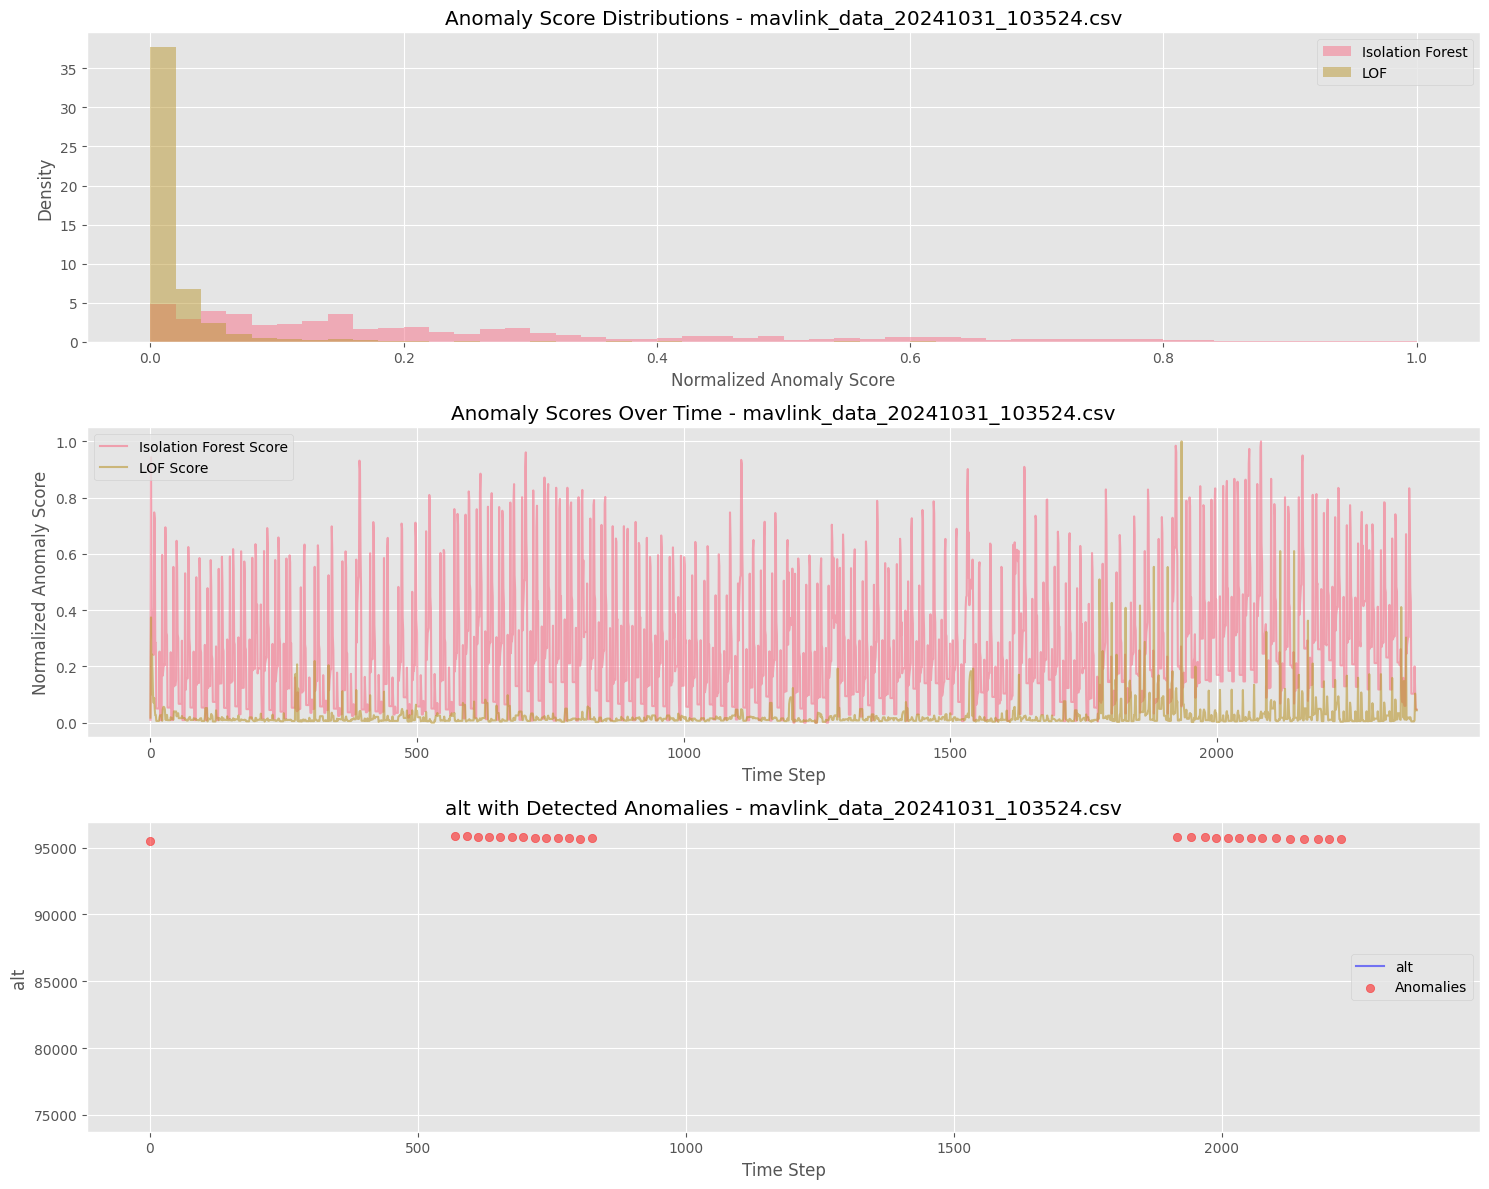


Summary Statistics:
Total data points: 2376
Isolation Forest anomalies: 116 (4.88%)
LOF anomalies: 226 (9.51%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.232
  Std: 0.219
  Max: 1.000
LOF scores:
  Mean: 0.023
  Std: 0.048
  Max: 1.000

Analyzing flight: mavlink_data_20241031_103539.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

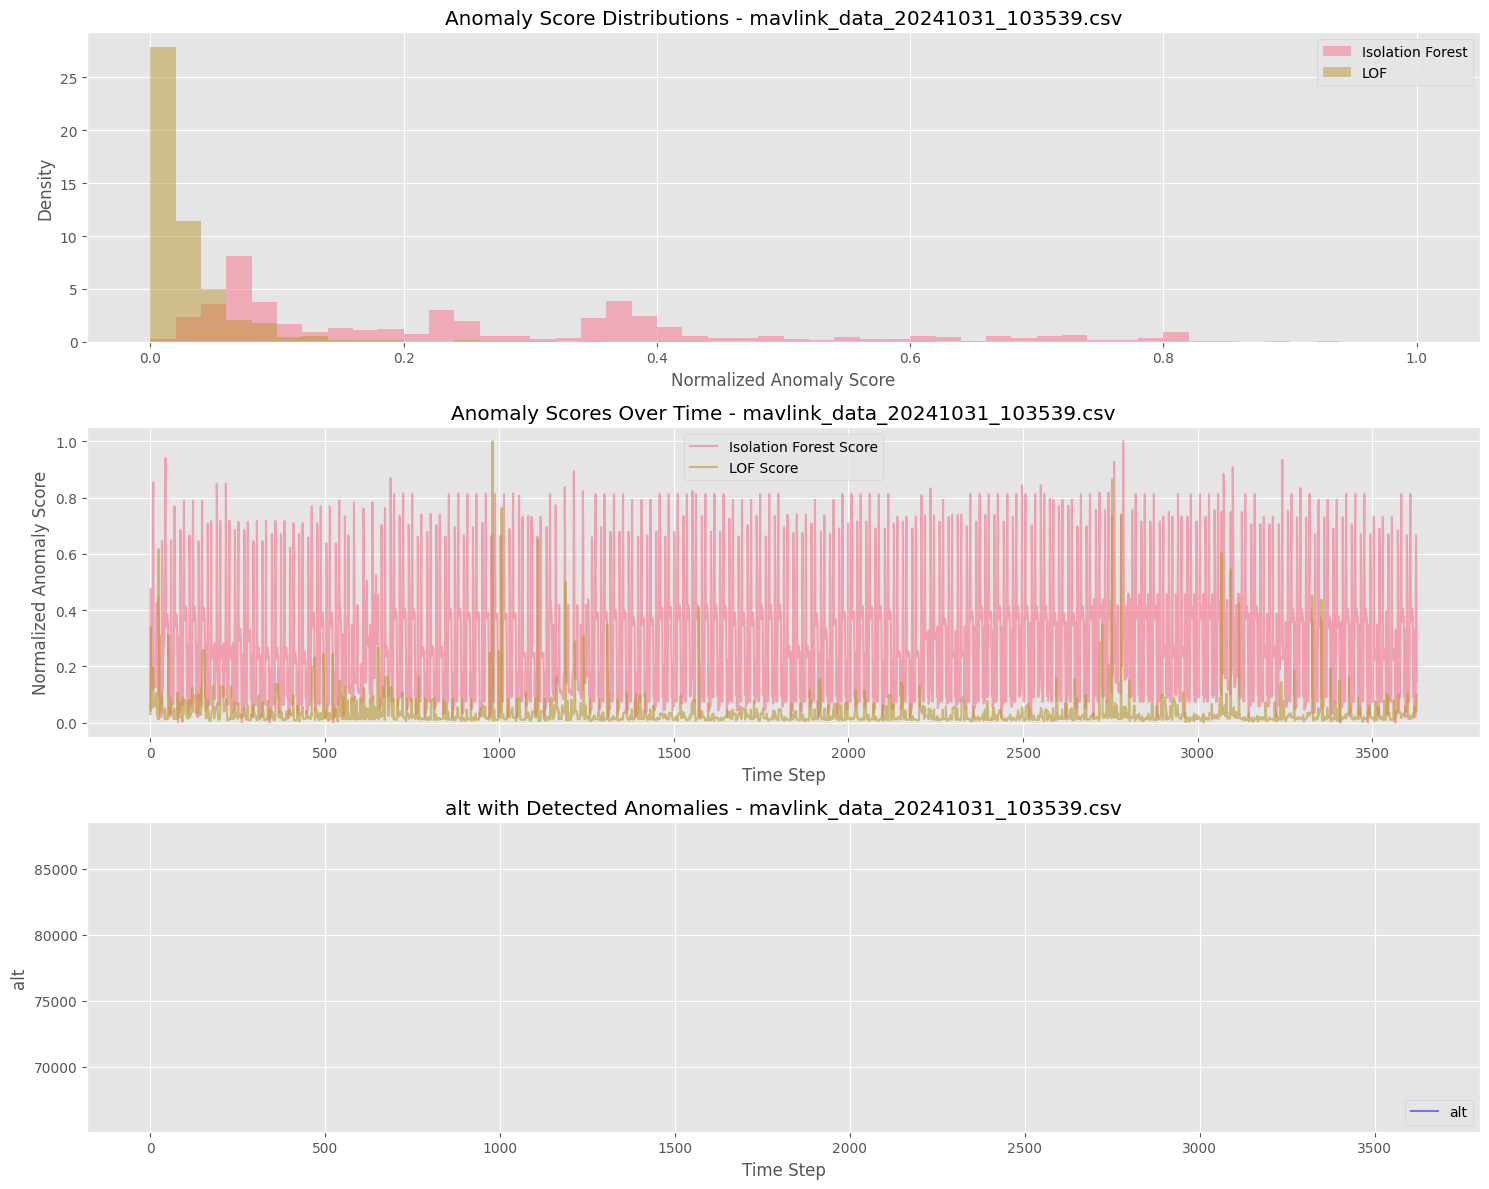


Summary Statistics:
Total data points: 3629
Isolation Forest anomalies: 0 (0.00%)
LOF anomalies: 379 (10.44%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.258
  Std: 0.210
  Max: 1.000
LOF scores:
  Mean: 0.033
  Std: 0.052
  Max: 1.000

Analyzing flight: mavlink_data_20241101_151428.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

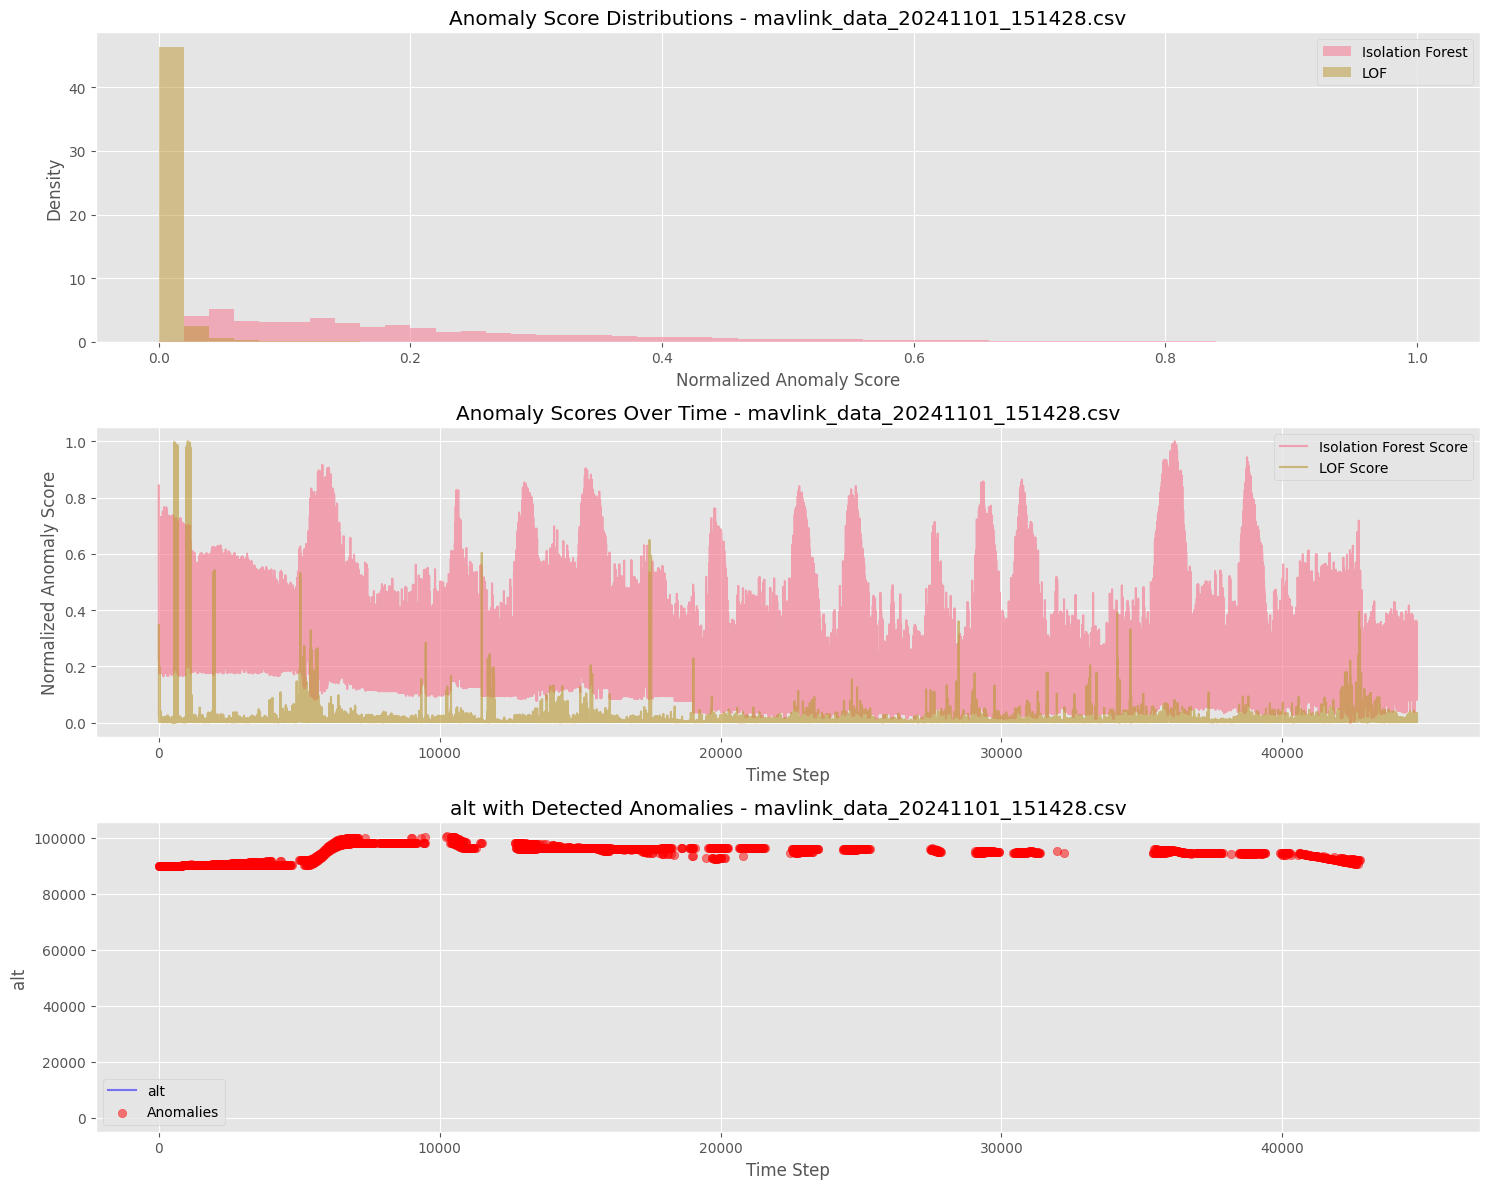


Summary Statistics:
Total data points: 44798
Isolation Forest anomalies: 7362 (16.43%)
LOF anomalies: 5169 (11.54%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.205
  Std: 0.165
  Max: 1.000
LOF scores:
  Mean: 0.009
  Std: 0.024
  Max: 1.000

Analyzing flight: mavlink_data_20241101_151906.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

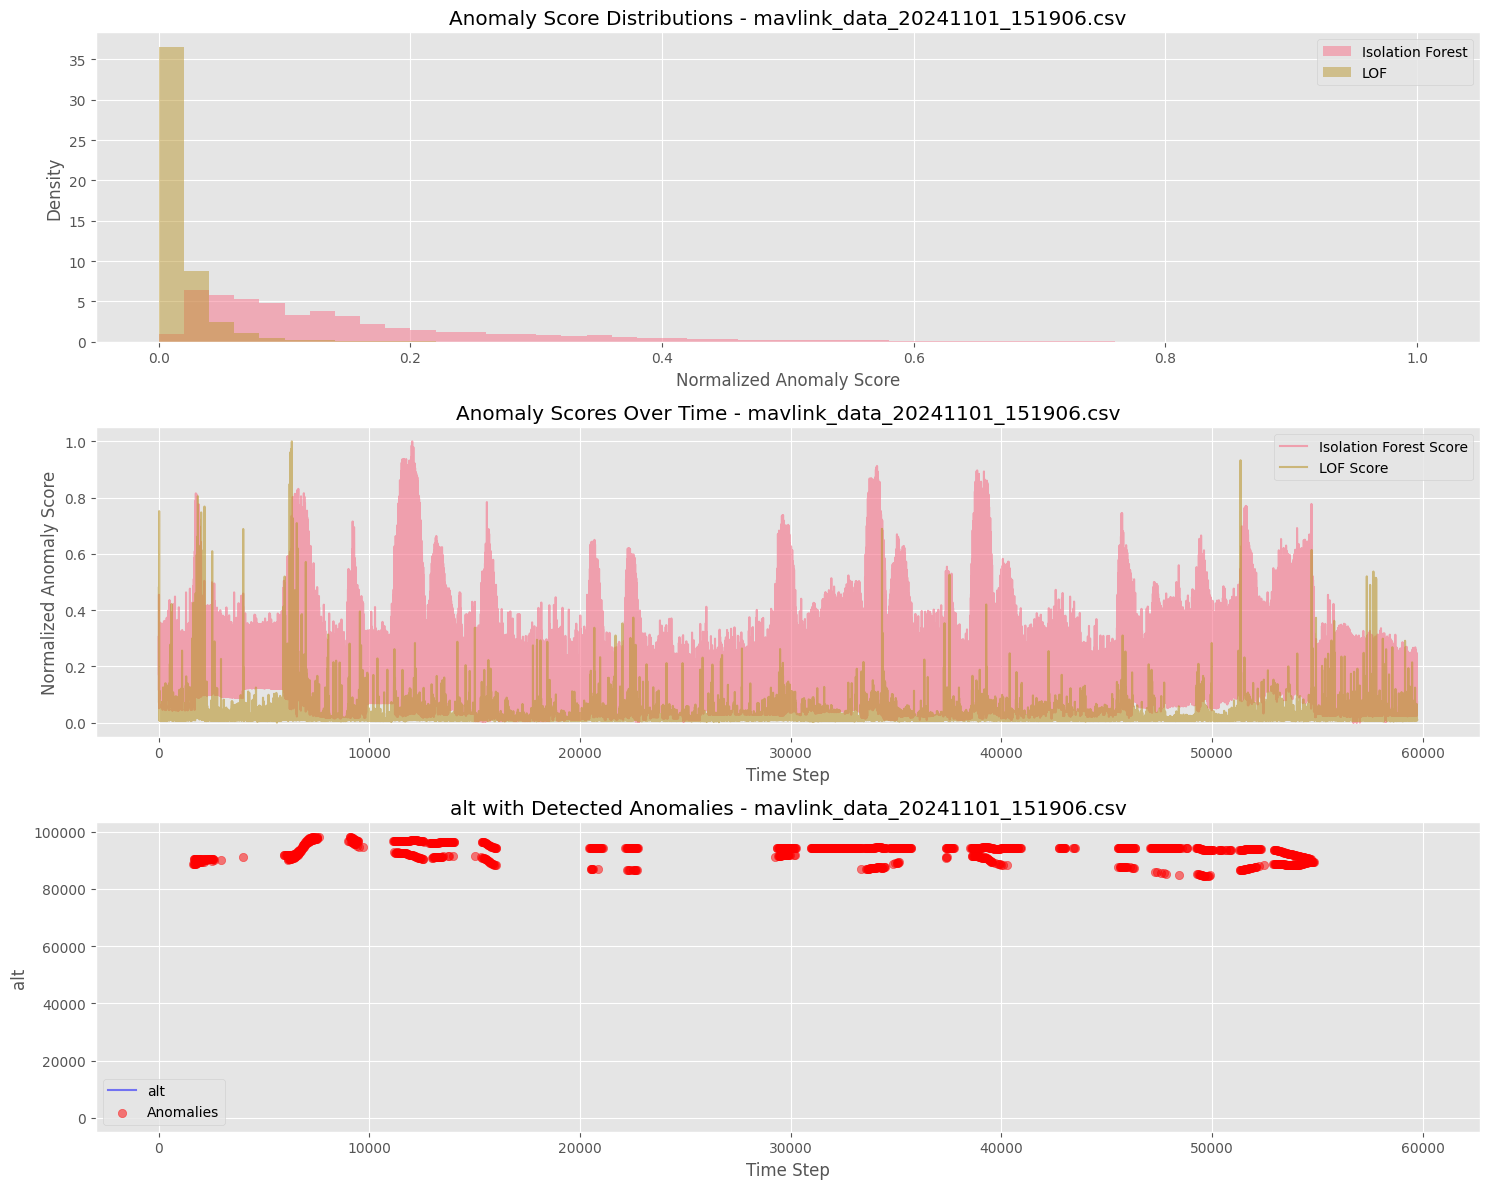


Summary Statistics:
Total data points: 59743
Isolation Forest anomalies: 5191 (8.69%)
LOF anomalies: 6274 (10.50%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.154
  Std: 0.137
  Max: 1.000
LOF scores:
  Mean: 0.021
  Std: 0.030
  Max: 1.000

Analyzing flight: mavlink_data_20241101_152504.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

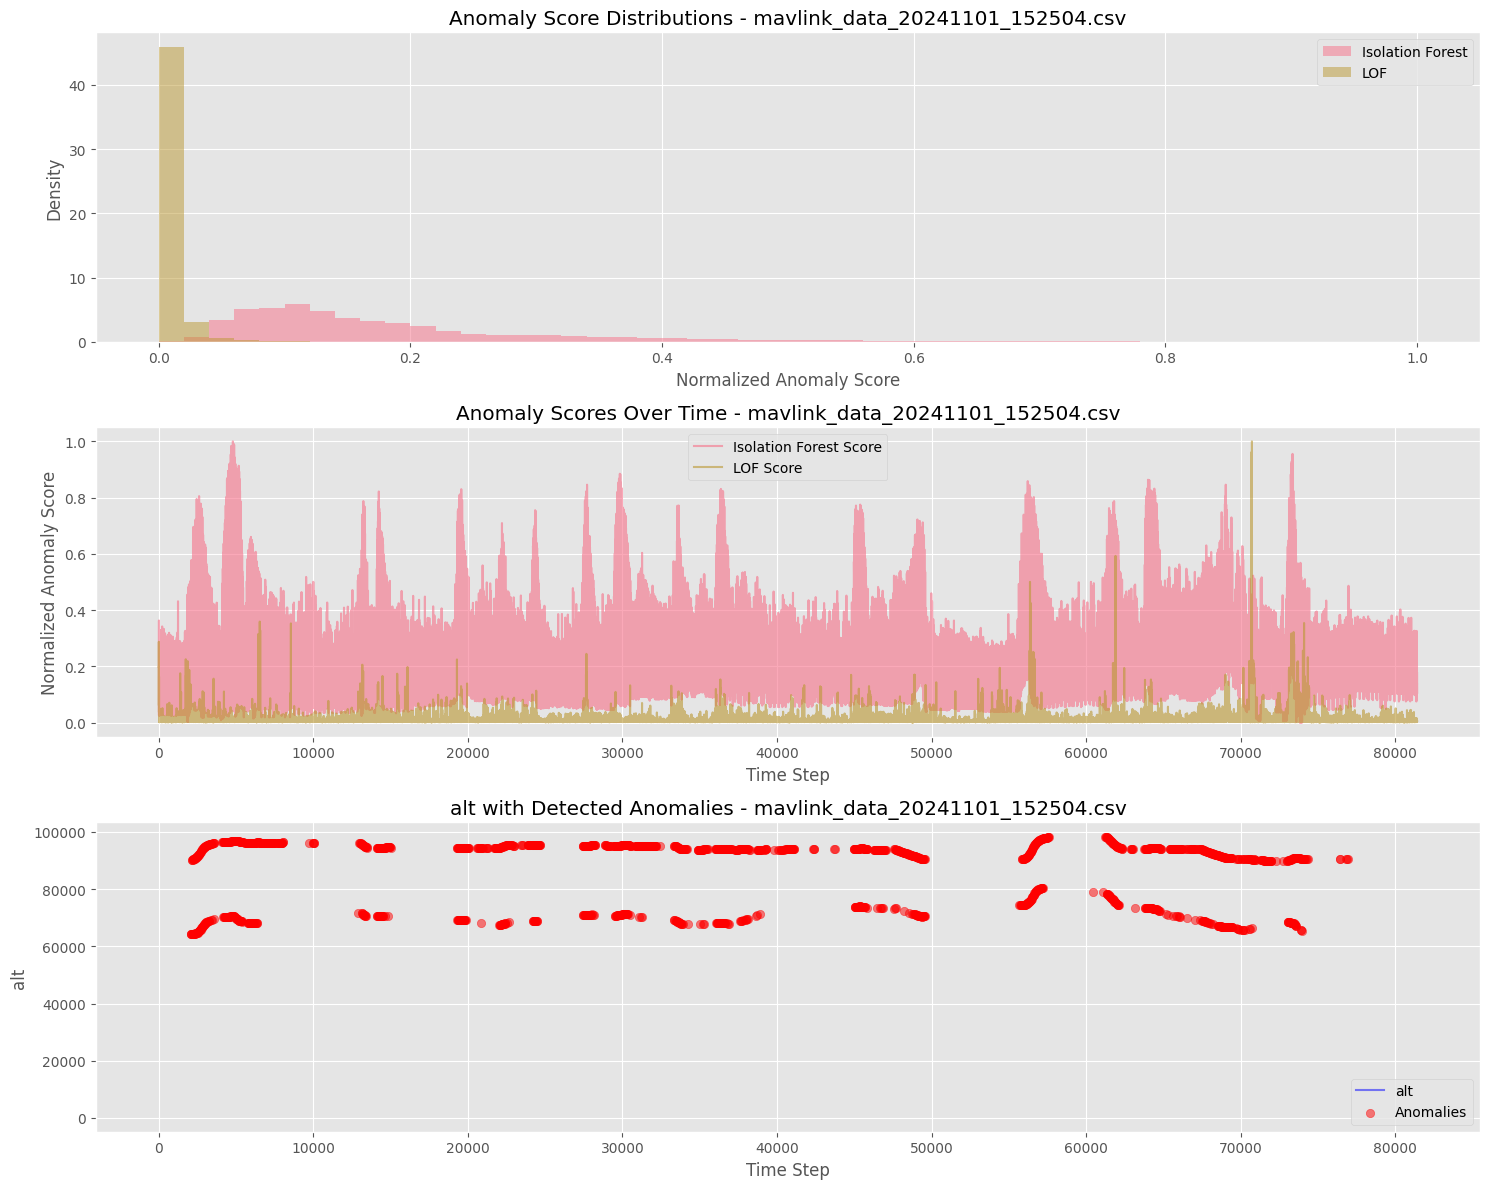


Summary Statistics:
Total data points: 81420
Isolation Forest anomalies: 7603 (9.34%)
LOF anomalies: 8448 (10.38%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.181
  Std: 0.131
  Max: 1.000
LOF scores:
  Mean: 0.009
  Std: 0.015
  Max: 1.000

Analyzing flight: mavlink_data_20241101_152510.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

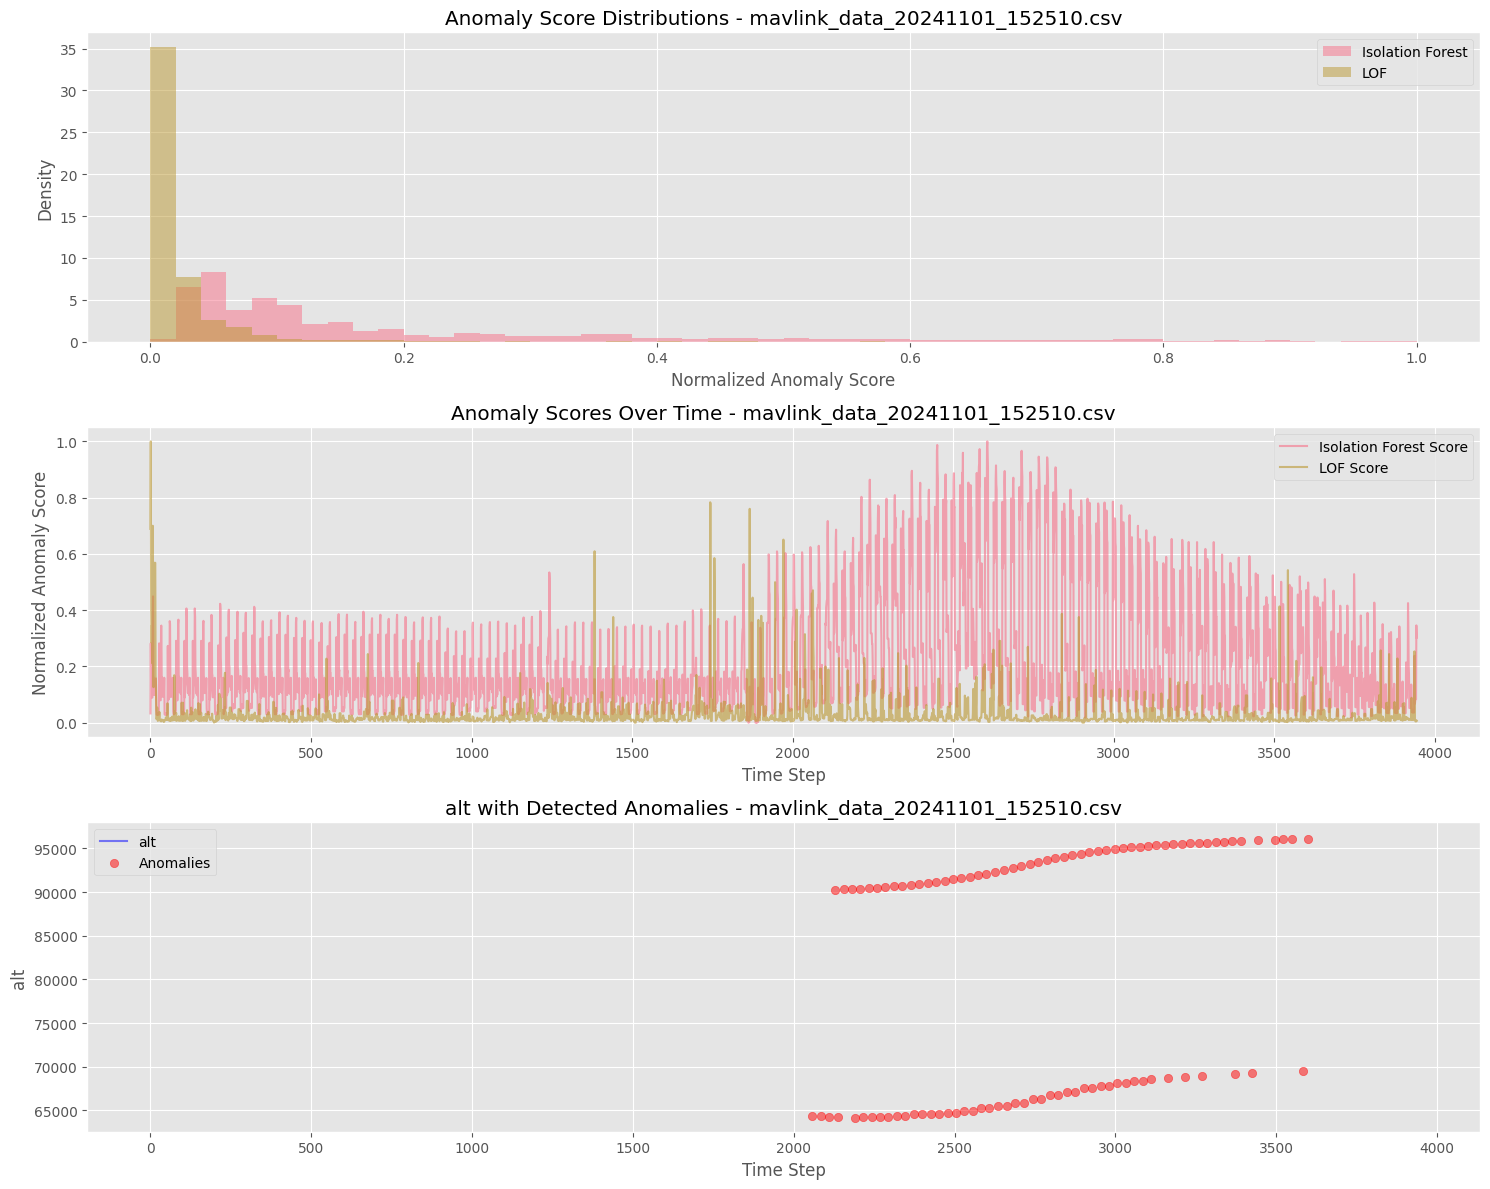


Summary Statistics:
Total data points: 3944
Isolation Forest anomalies: 415 (10.52%)
LOF anomalies: 391 (9.91%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.184
  Std: 0.195
  Max: 1.000
LOF scores:
  Mean: 0.028
  Std: 0.059
  Max: 1.000

Analyzing flight: mavlink_data_20241101_152514.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

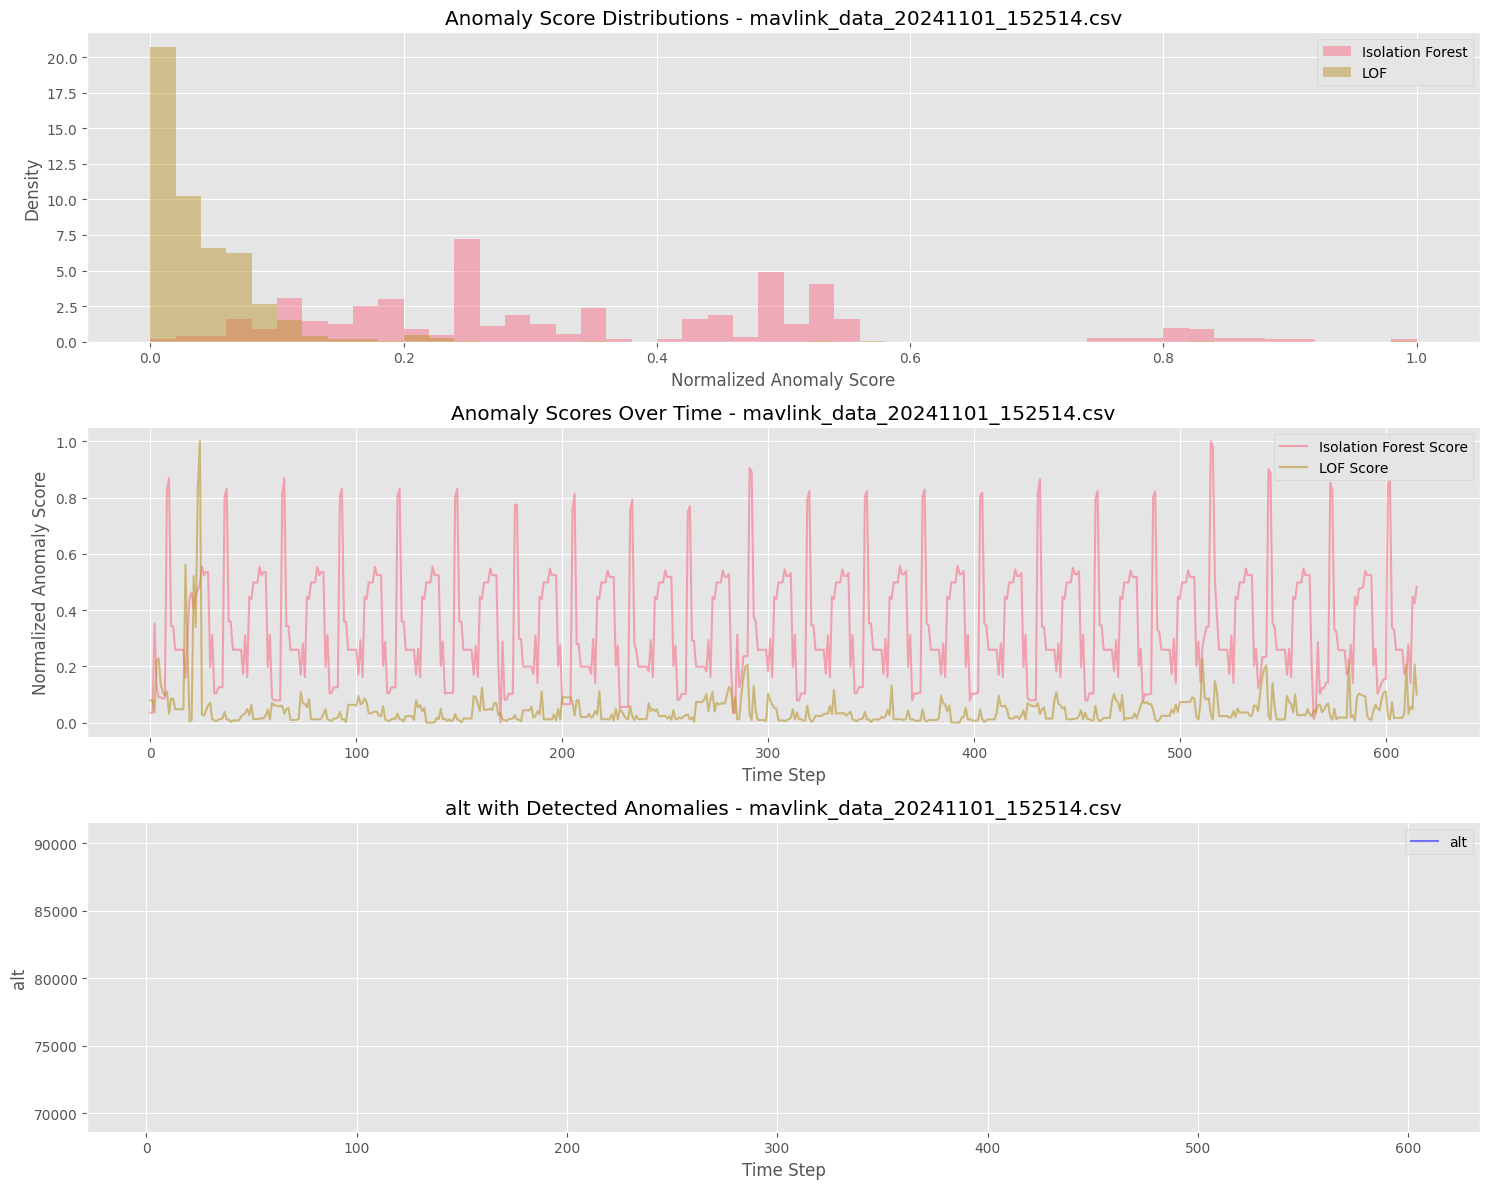


Summary Statistics:
Total data points: 616
Isolation Forest anomalies: 0 (0.00%)
LOF anomalies: 49 (7.95%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.344
  Std: 0.202
  Max: 1.000
LOF scores:
  Mean: 0.045
  Std: 0.070
  Max: 1.000

Analyzing flight: mavlink_data_20241101_153508.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

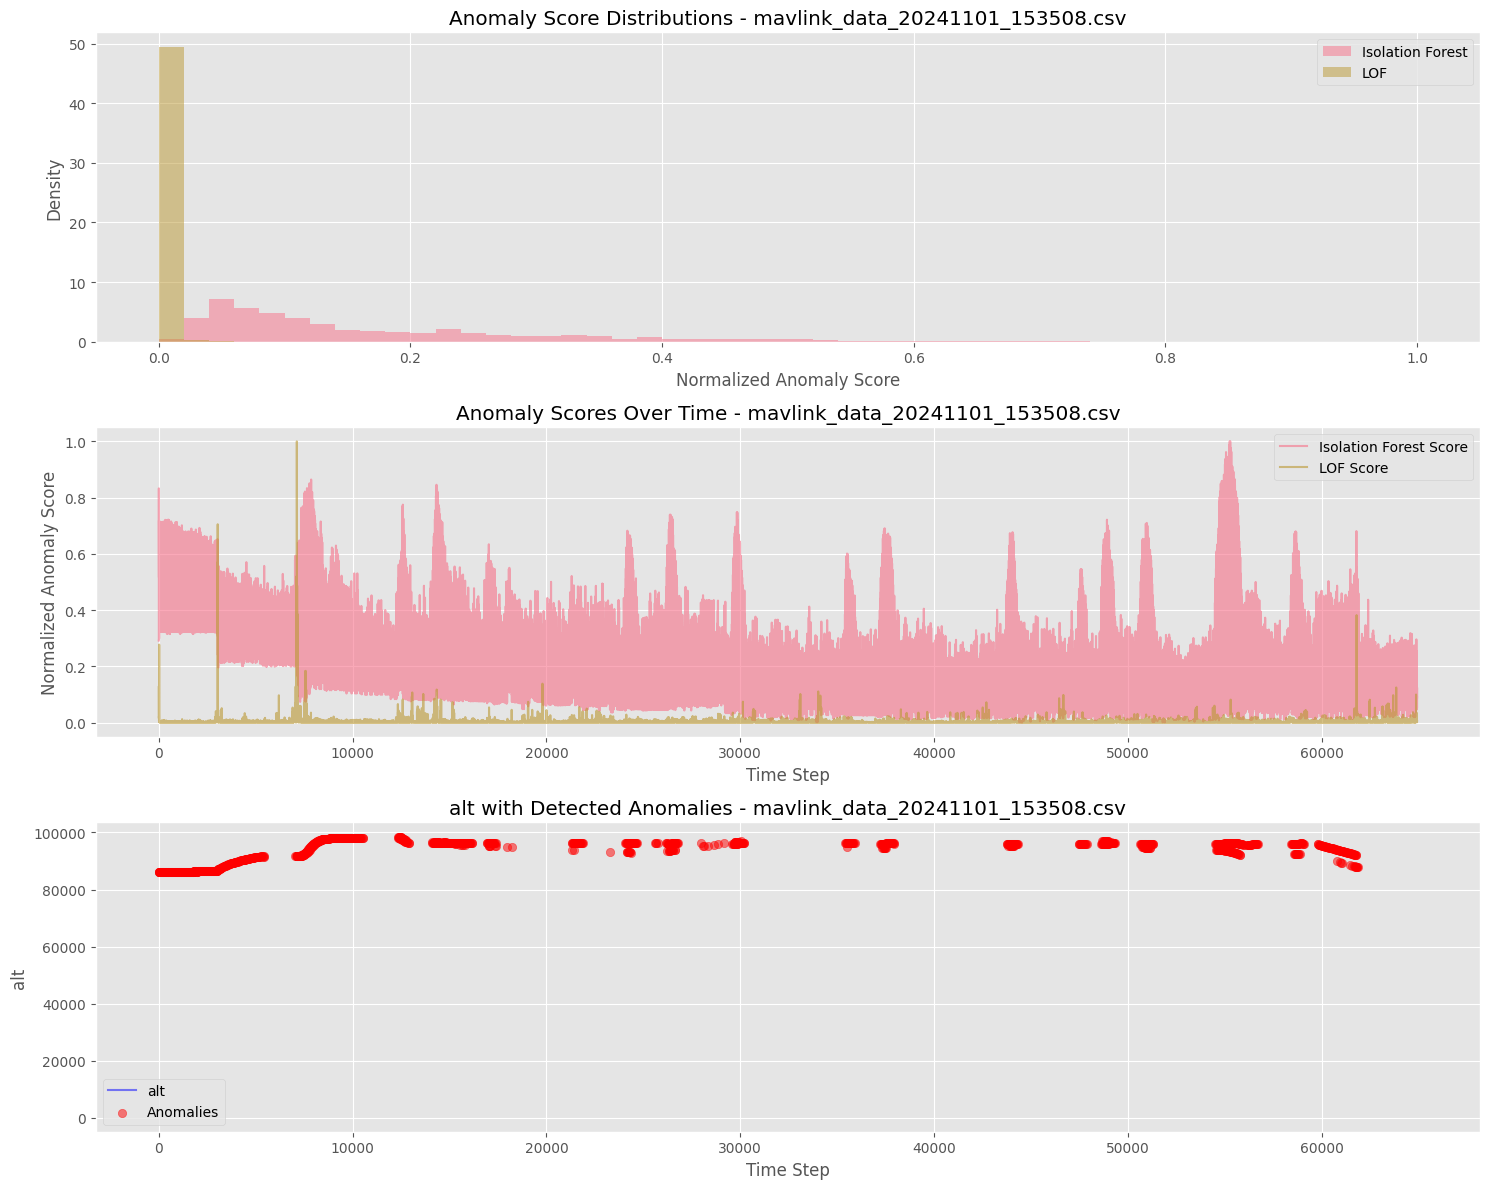


Summary Statistics:
Total data points: 64930
Isolation Forest anomalies: 6584 (10.14%)
LOF anomalies: 6190 (9.53%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.167
  Std: 0.142
  Max: 1.000
LOF scores:
  Mean: 0.003
  Std: 0.010
  Max: 1.000

Analyzing flight: mavlink_data_20241101_153913.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

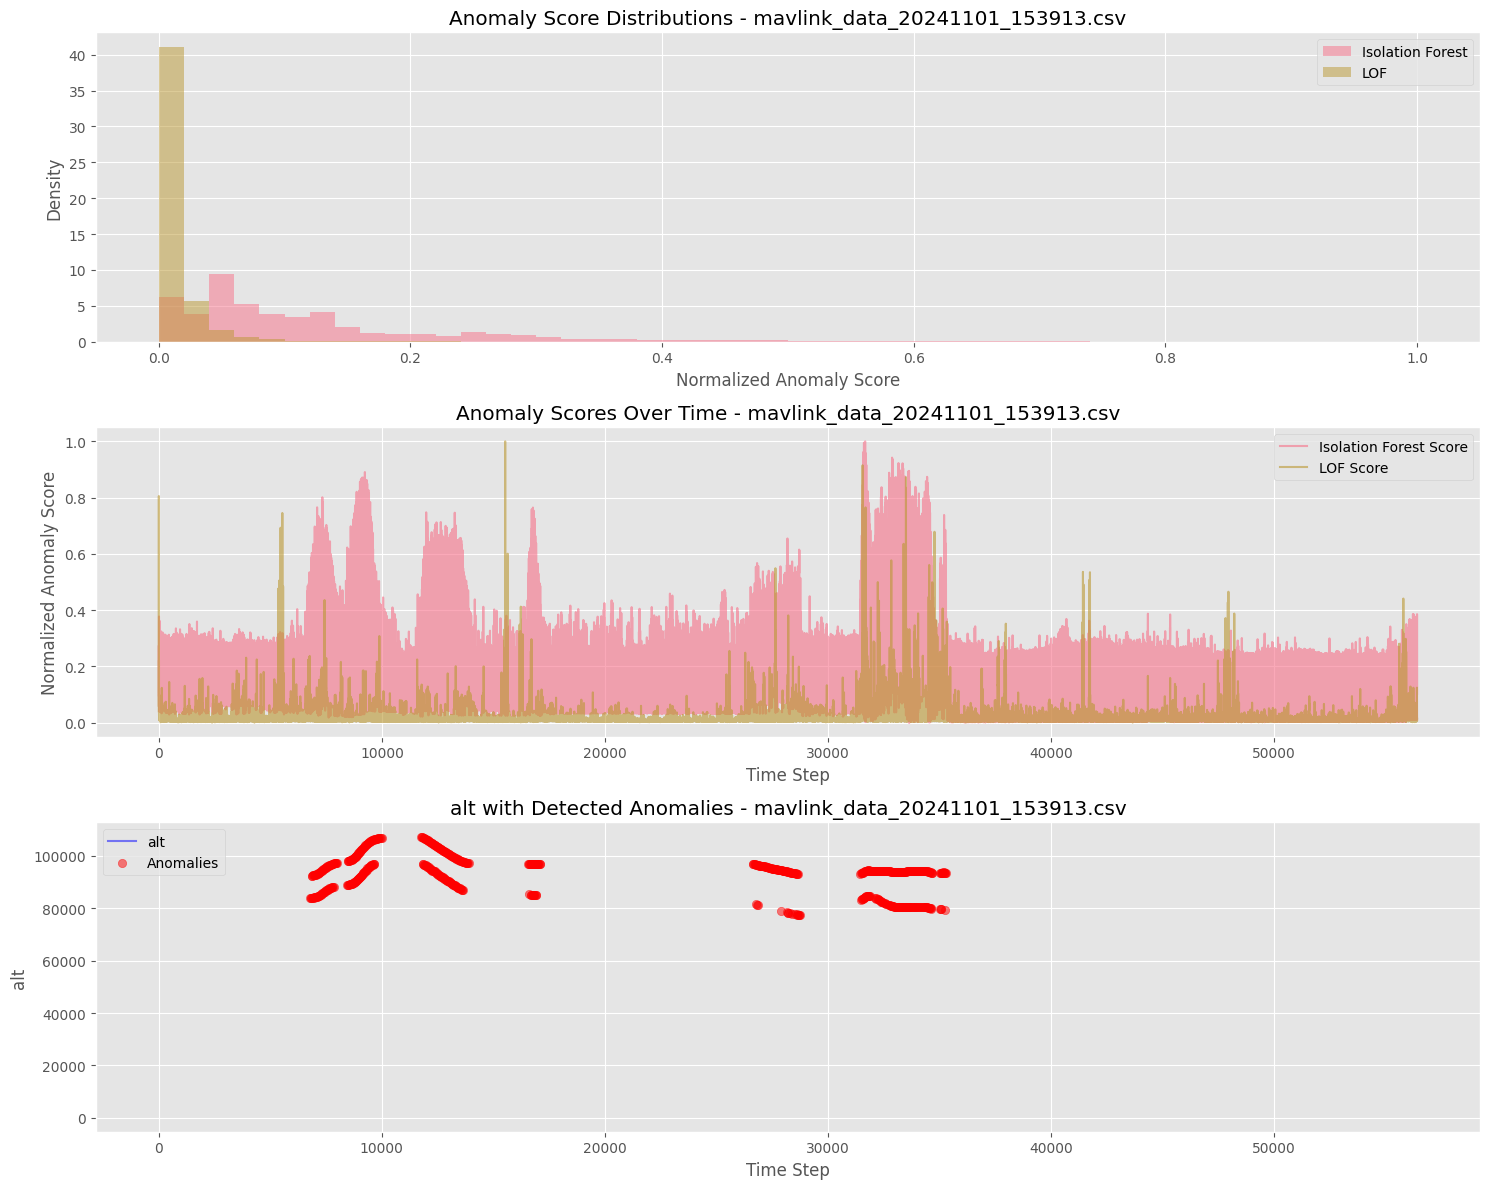


Summary Statistics:
Total data points: 56409
Isolation Forest anomalies: 2653 (4.70%)
LOF anomalies: 5745 (10.18%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.124
  Std: 0.128
  Max: 1.000
LOF scores:
  Mean: 0.016
  Std: 0.029
  Max: 1.000

Analyzing flight: mavlink_data_20241101_153956.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

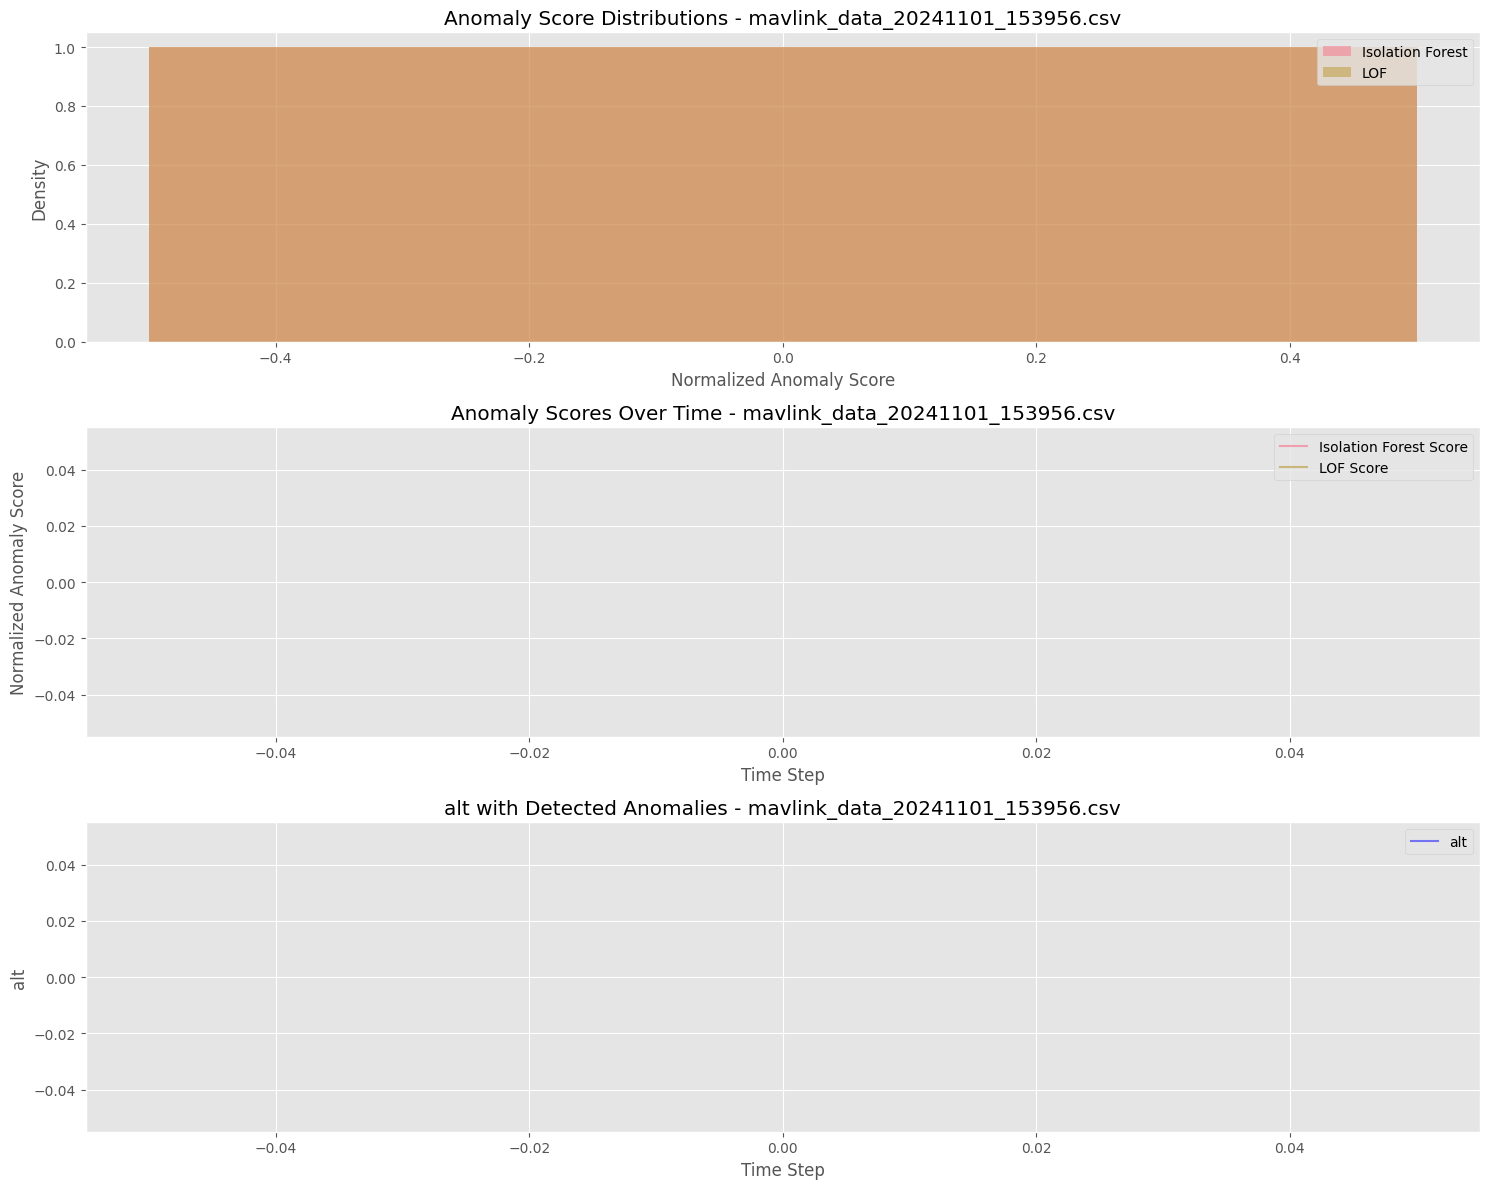


Summary Statistics:
Total data points: 1
Isolation Forest anomalies: 0 (0.00%)
LOF anomalies: 1 (100.00%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.000
  Std: 0.000
  Max: 0.000
LOF scores:
  Mean: 0.000
  Std: 0.000
  Max: 0.000

Analyzing flight: mavlink_data_20241101_154428.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

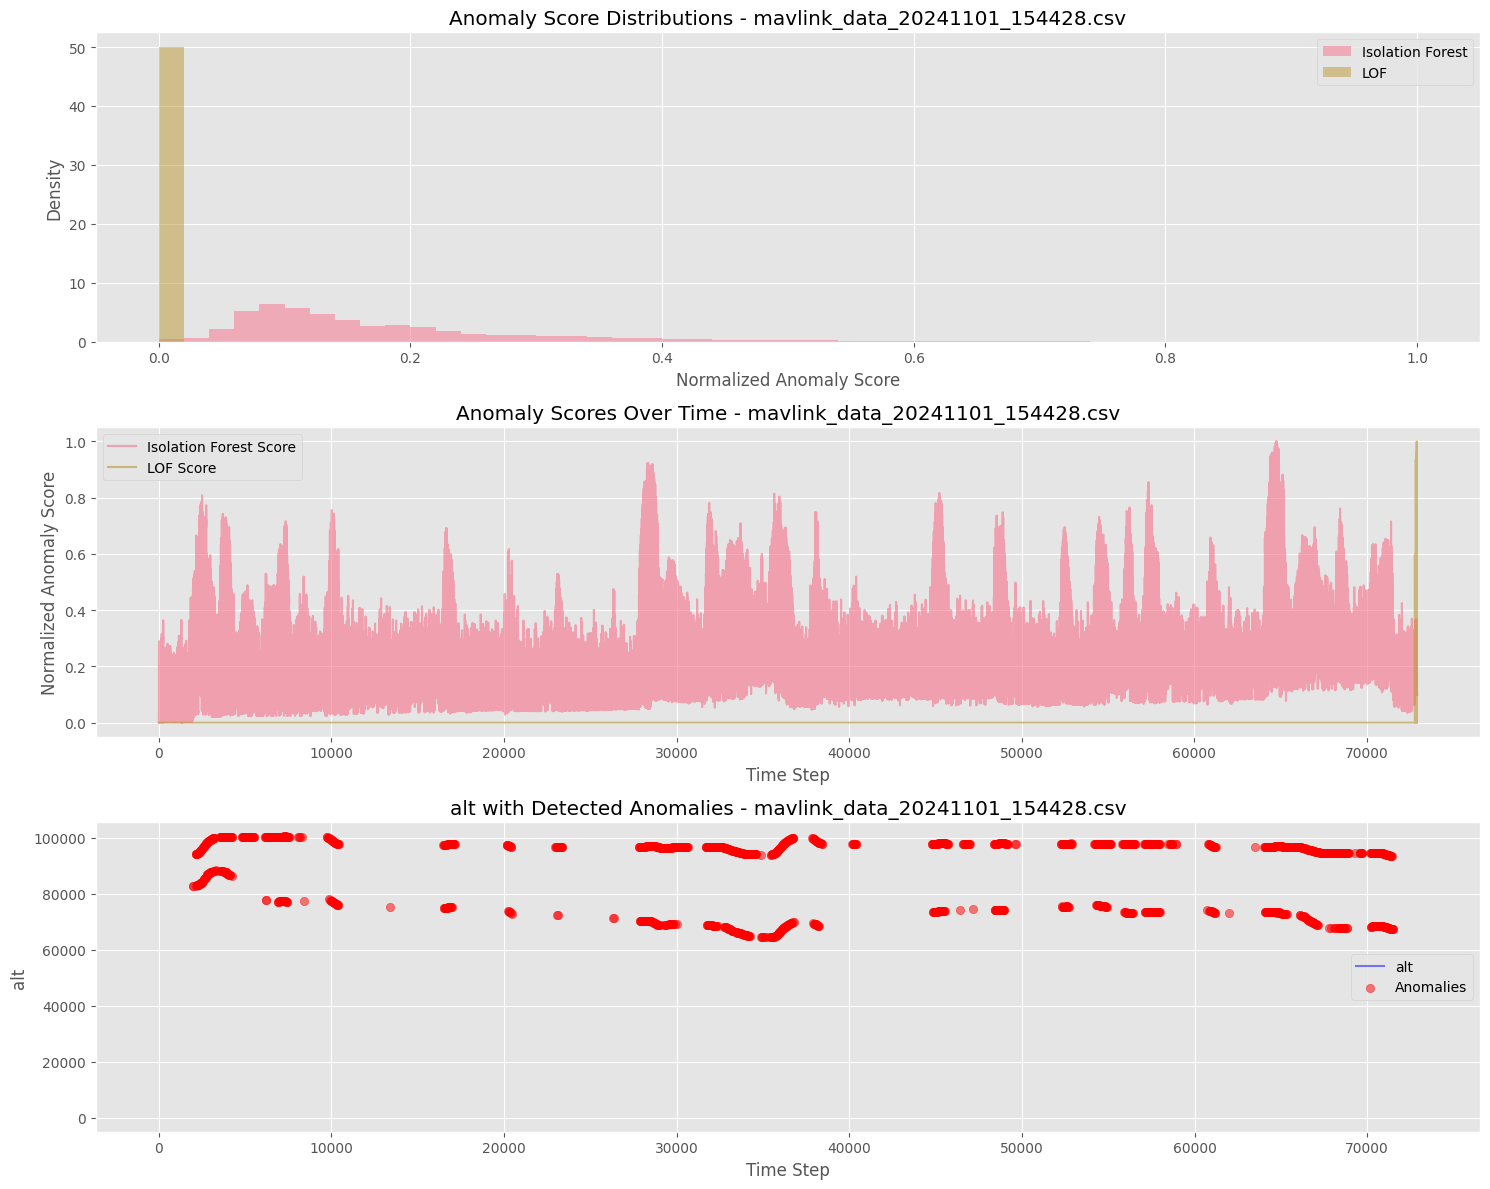


Summary Statistics:
Total data points: 72904
Isolation Forest anomalies: 6426 (8.81%)
LOF anomalies: 6662 (9.14%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.180
  Std: 0.130
  Max: 1.000
LOF scores:
  Mean: 0.000
  Std: 0.007
  Max: 1.000

Analyzing flight: mavlink_data_20241101_155905.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

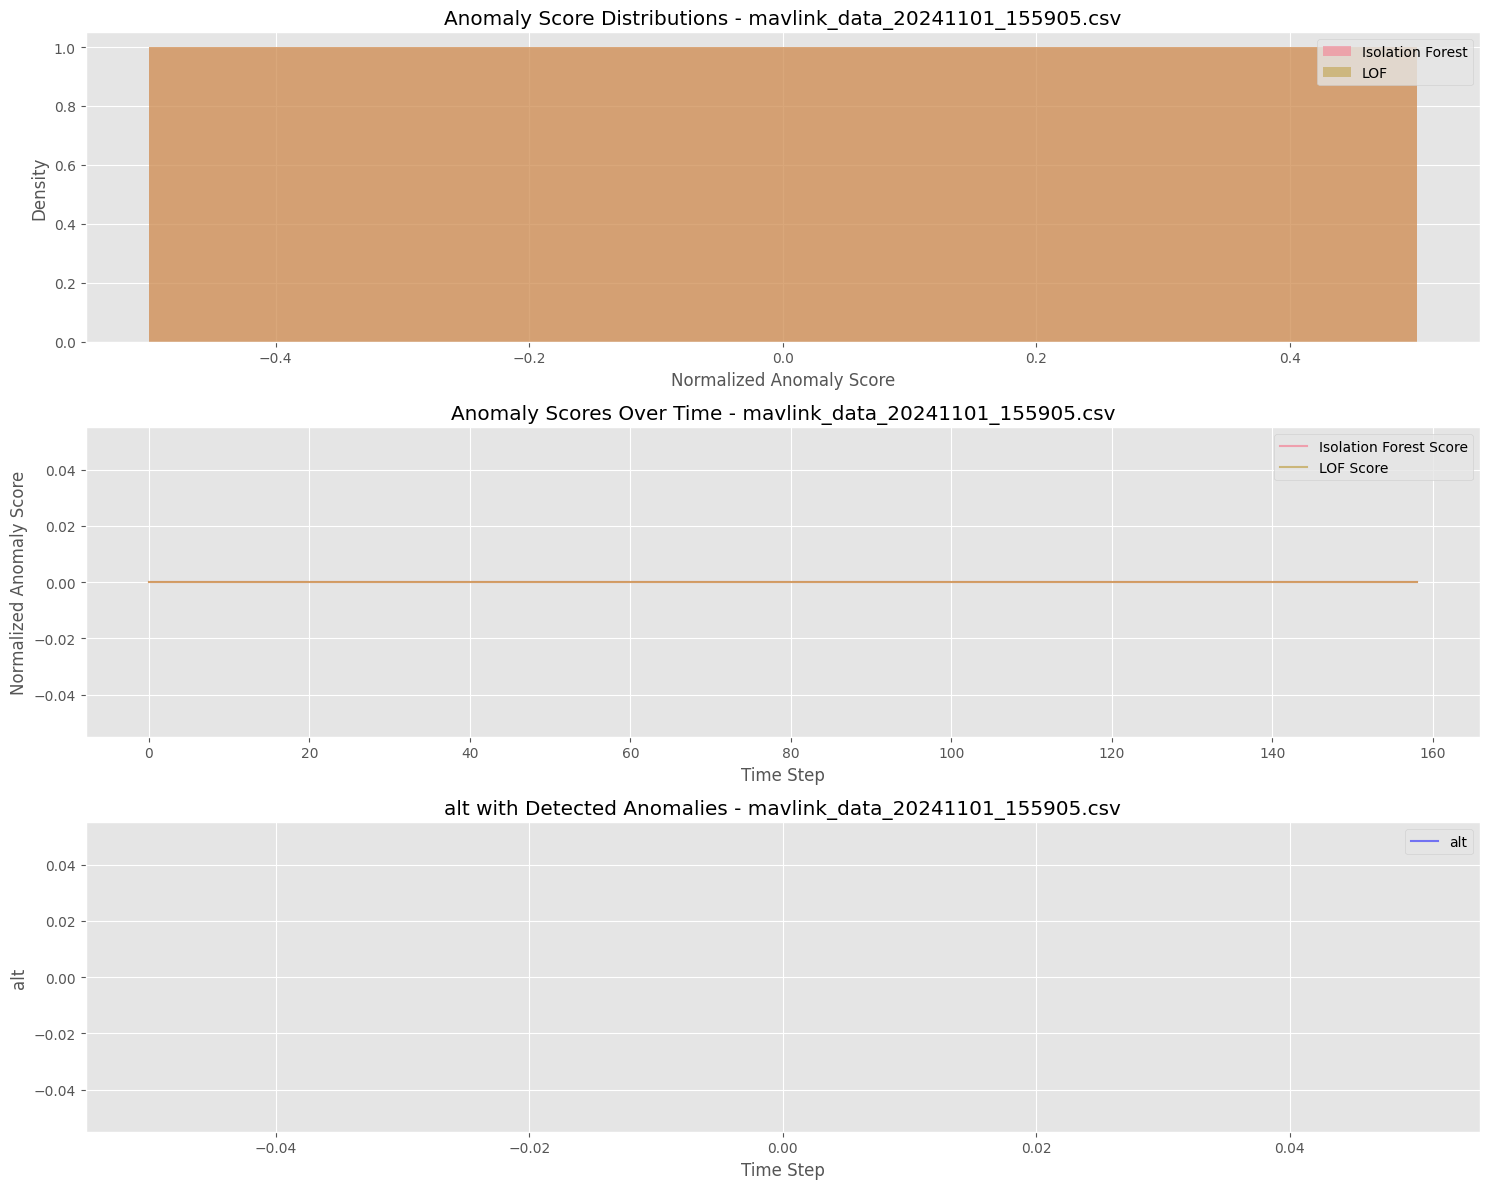


Summary Statistics:
Total data points: 159
Isolation Forest anomalies: 0 (0.00%)
LOF anomalies: 159 (100.00%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.000
  Std: 0.000
  Max: 0.000
LOF scores:
  Mean: 0.000
  Std: 0.000
  Max: 0.000

Analyzing flight: mavlink_data_20241101_160537.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

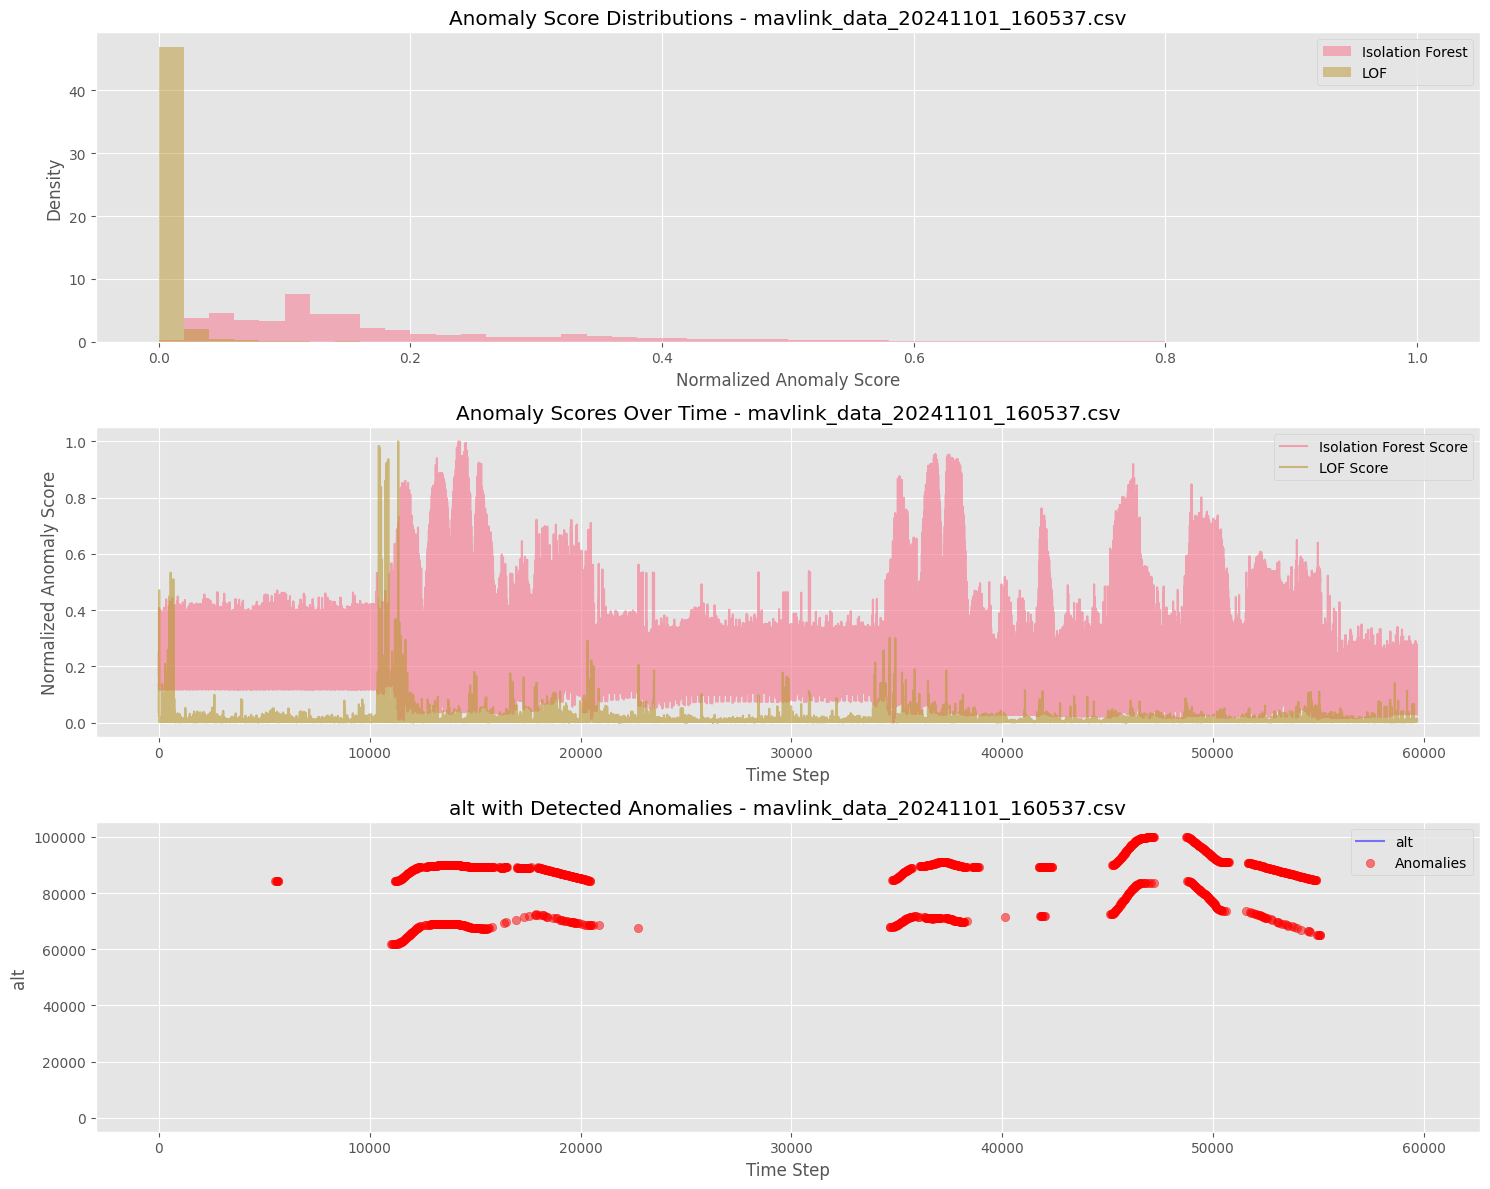


Summary Statistics:
Total data points: 59671
Isolation Forest anomalies: 5284 (8.86%)
LOF anomalies: 5042 (8.45%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.181
  Std: 0.153
  Max: 1.000
LOF scores:
  Mean: 0.008
  Std: 0.020
  Max: 1.000

Analyzing flight: mavlink_data_20241101_161005.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

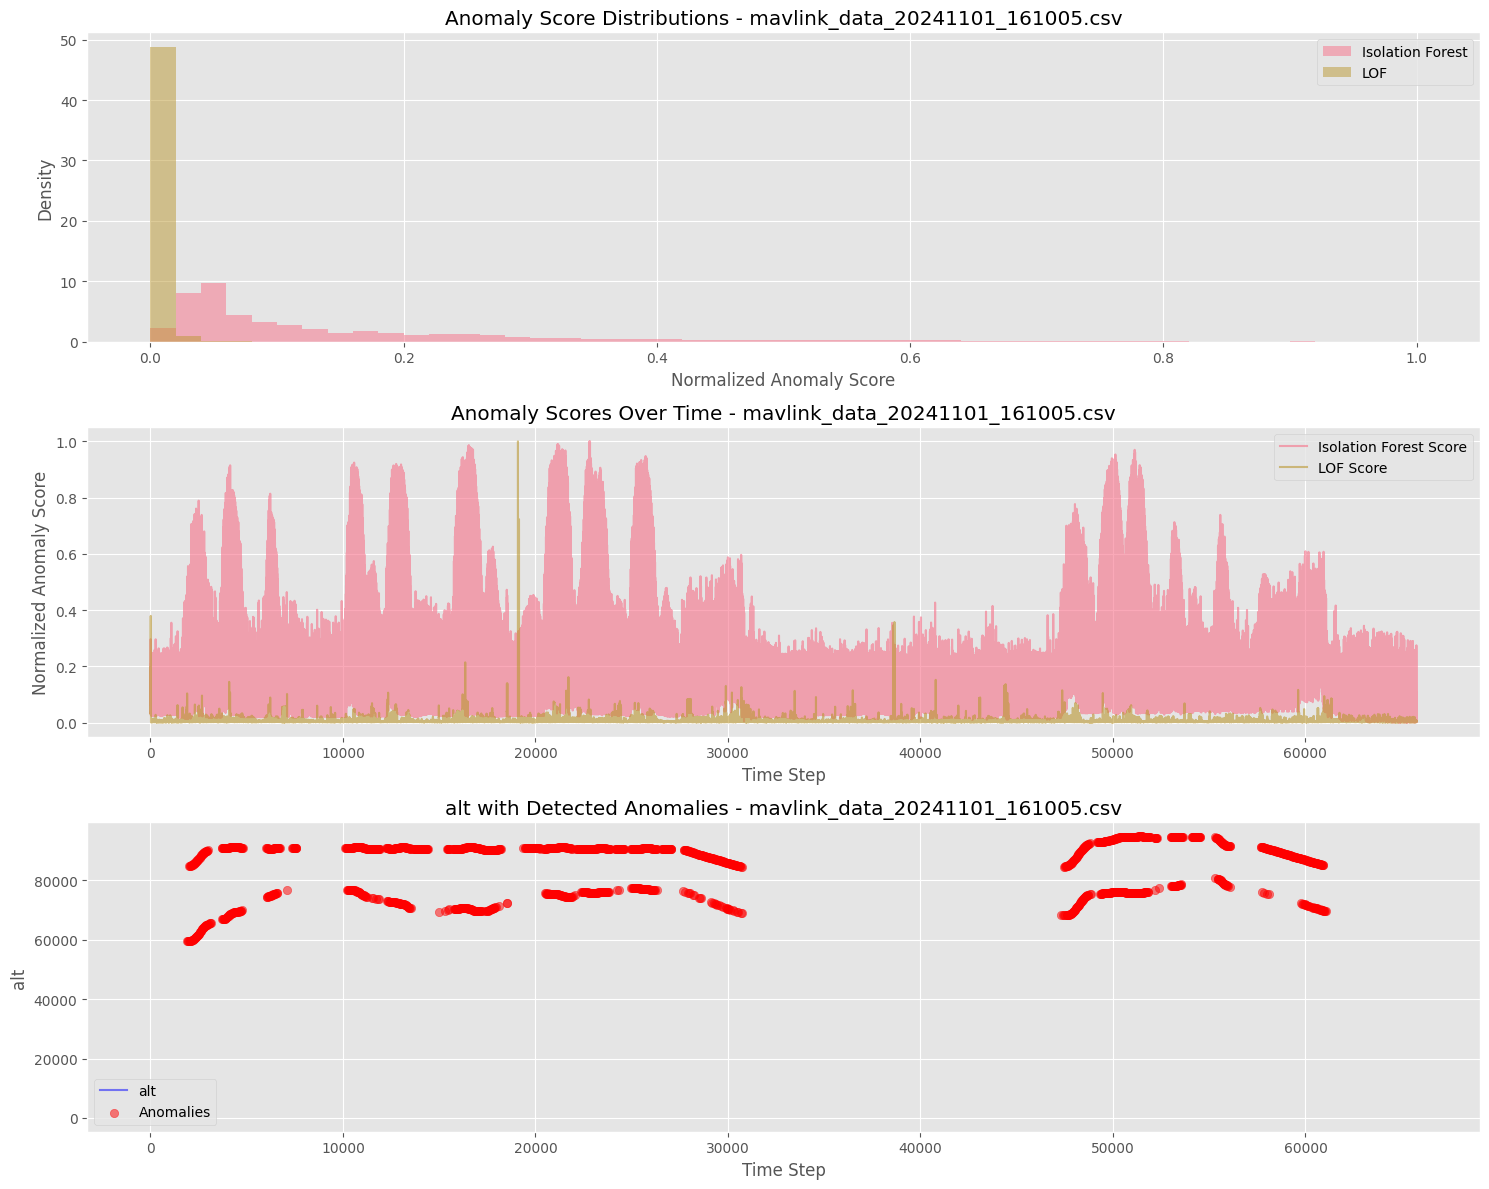


Summary Statistics:
Total data points: 65792
Isolation Forest anomalies: 7166 (10.89%)
LOF anomalies: 5103 (7.76%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.154
  Std: 0.167
  Max: 1.000
LOF scores:
  Mean: 0.005
  Std: 0.010
  Max: 1.000

Analyzing flight: mavlink_data_20241101_161341.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

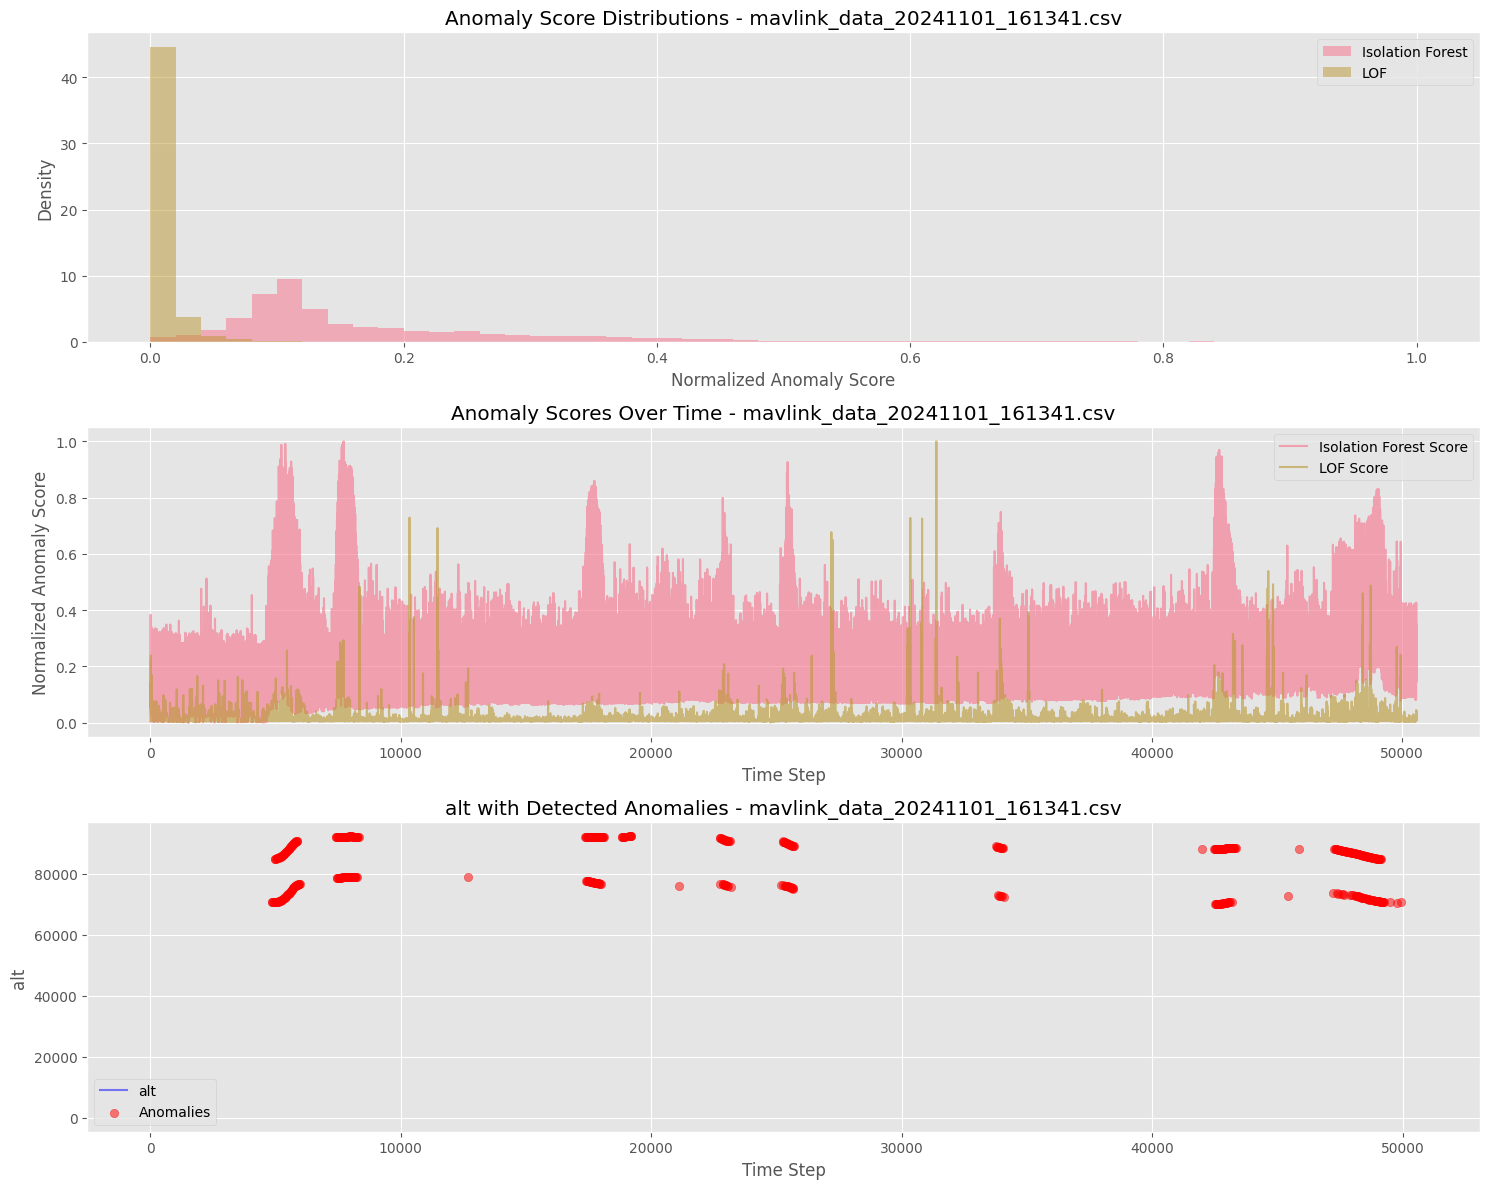


Summary Statistics:
Total data points: 50579
Isolation Forest anomalies: 2203 (4.36%)
LOF anomalies: 3248 (6.42%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.175
  Std: 0.131
  Max: 1.000
LOF scores:
  Mean: 0.013
  Std: 0.021
  Max: 1.000

Analyzing flight: mavlink_data_20241101_162424.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

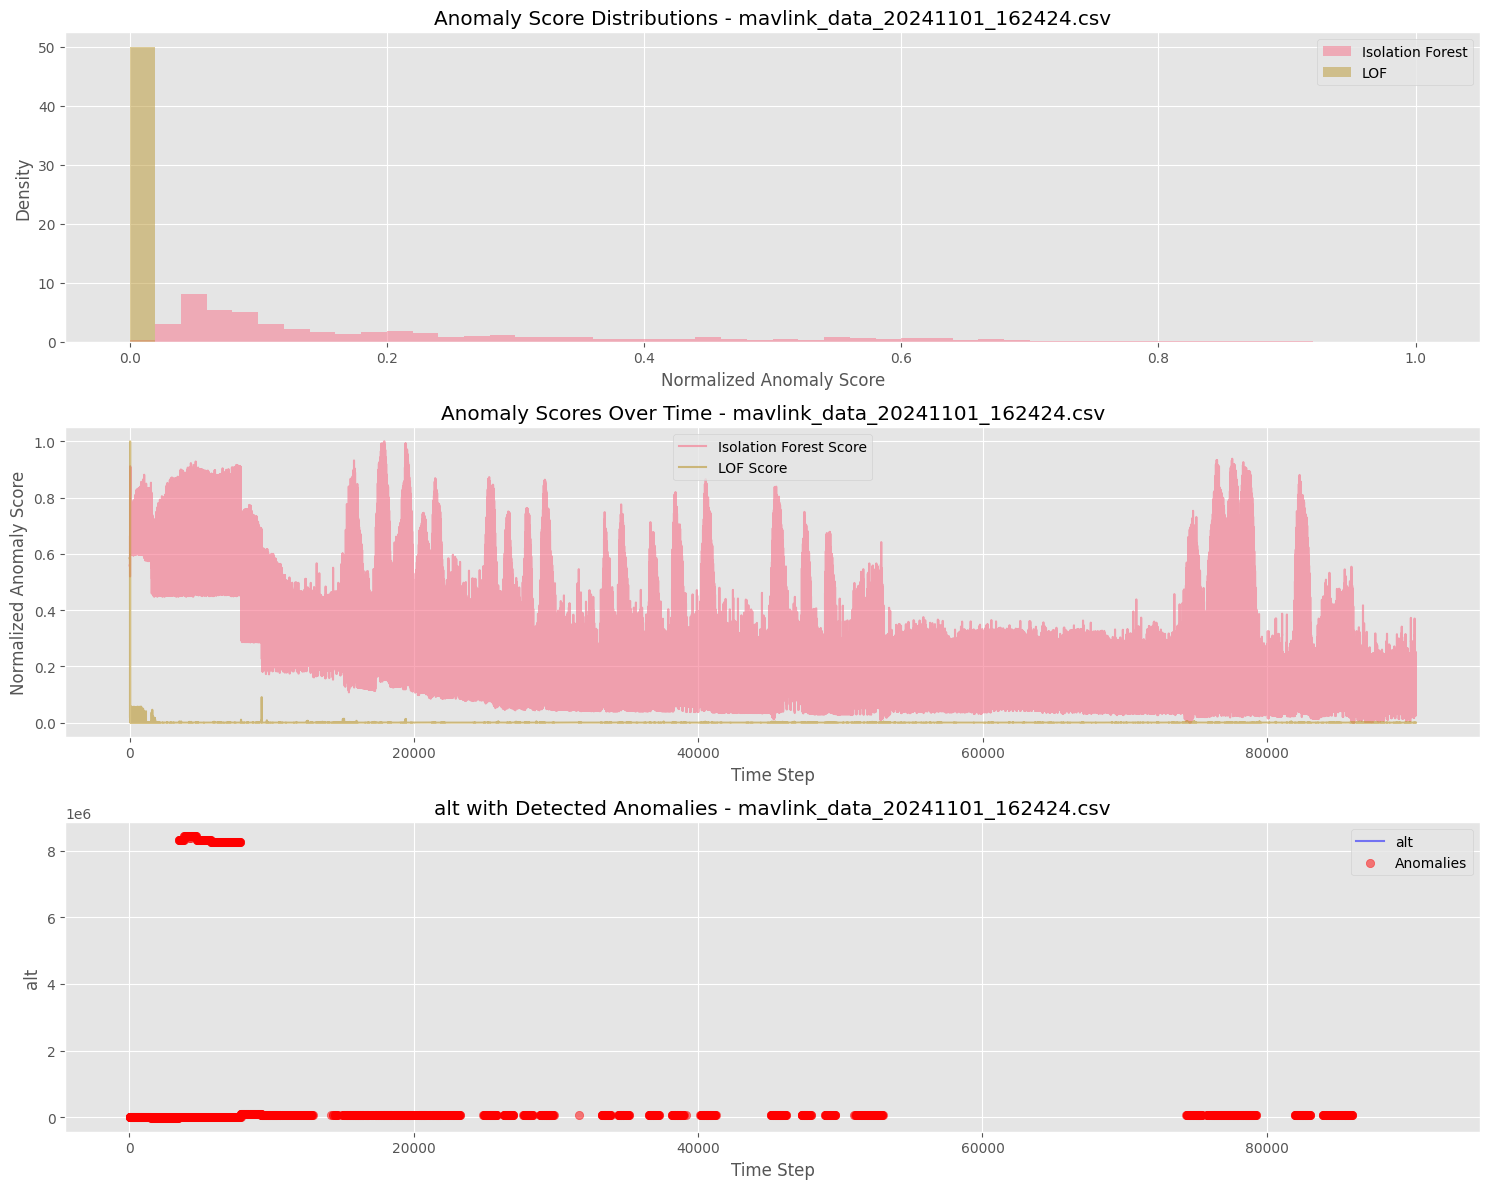


Summary Statistics:
Total data points: 90471
Isolation Forest anomalies: 17043 (18.84%)
LOF anomalies: 8371 (9.25%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.209
  Std: 0.197
  Max: 1.000
LOF scores:
  Mean: 0.000
  Std: 0.014
  Max: 1.000

Analyzing flight: mavlink_data_20241101_163432.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

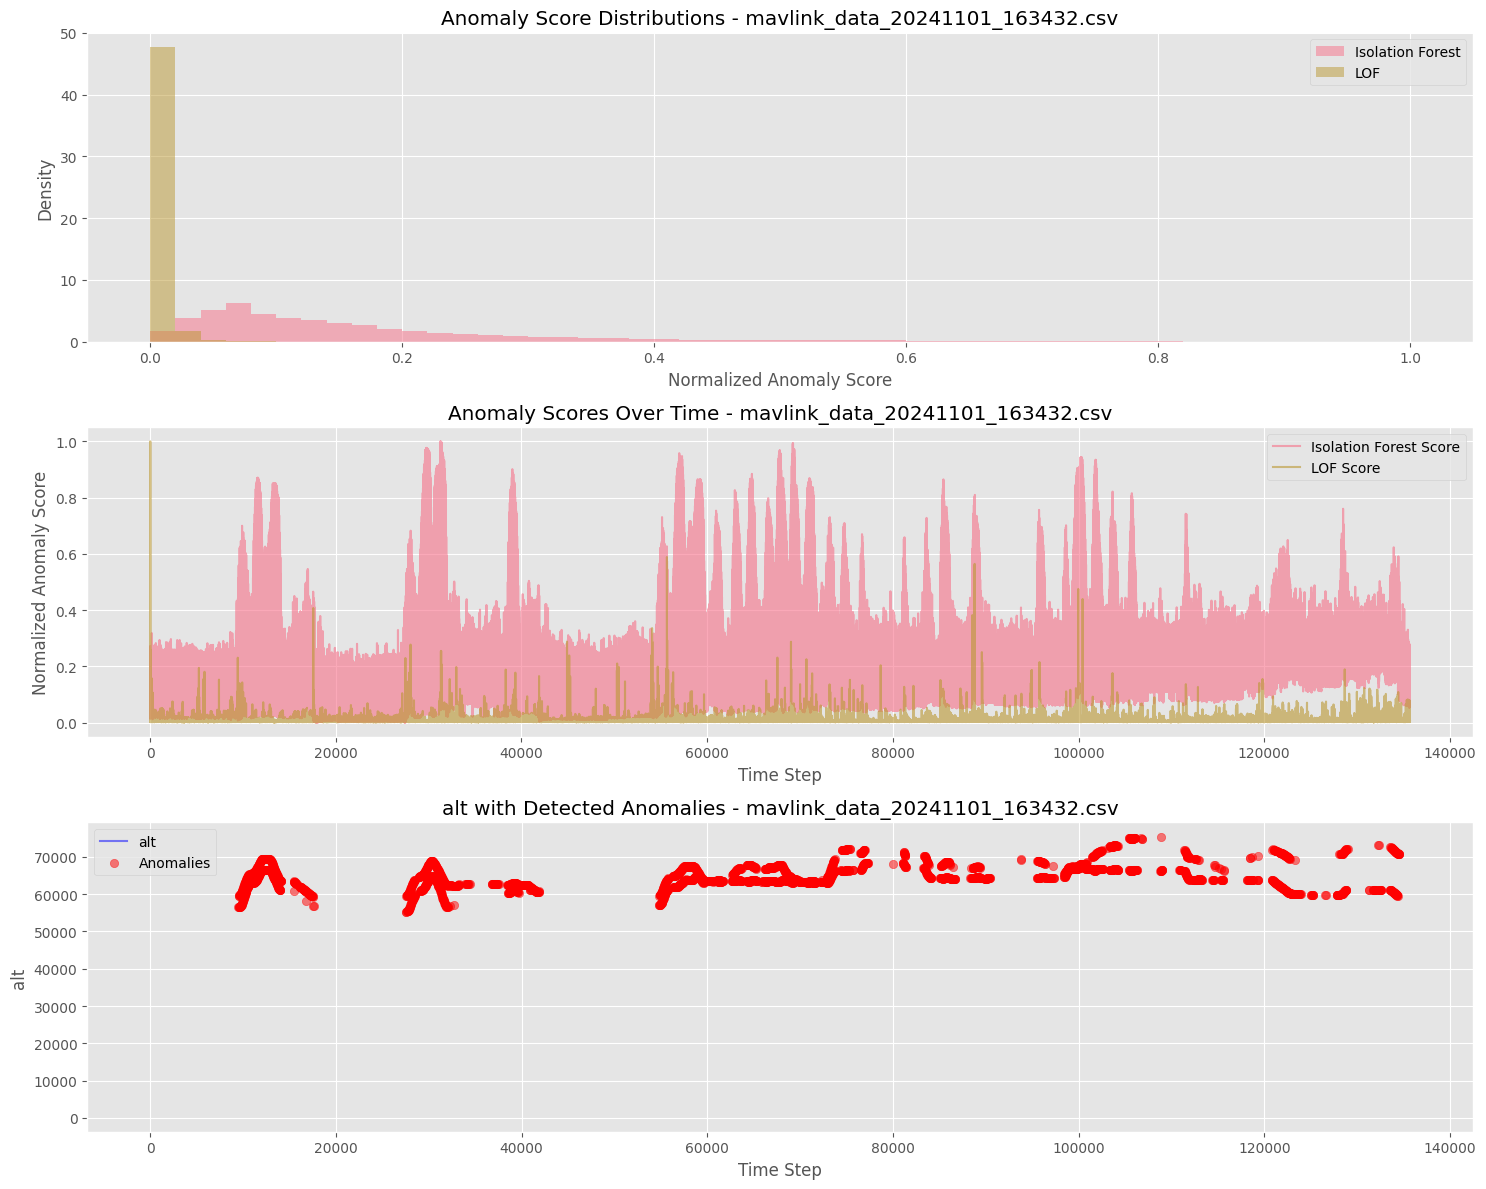


Summary Statistics:
Total data points: 135705
Isolation Forest anomalies: 14483 (10.67%)
LOF anomalies: 11944 (8.80%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.165
  Std: 0.149
  Max: 1.000
LOF scores:
  Mean: 0.007
  Std: 0.011
  Max: 1.000

Analyzing flight: mavlink_data_20241101_164607.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

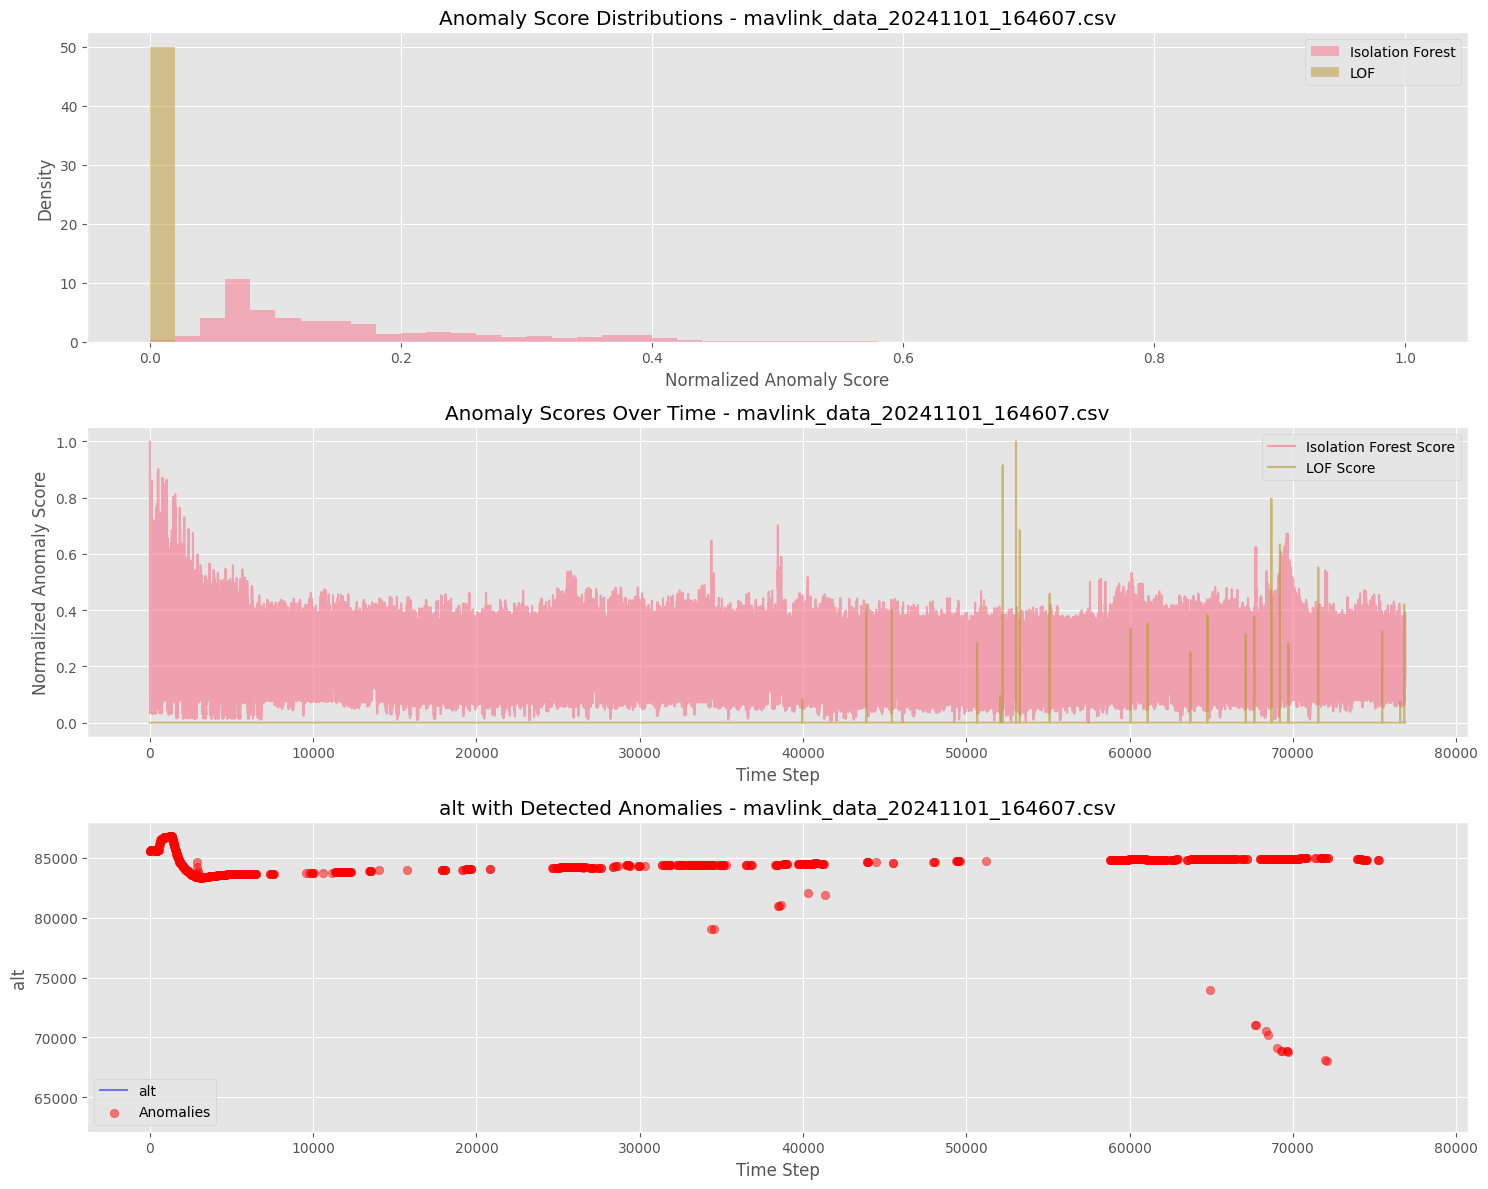


Summary Statistics:
Total data points: 76878
Isolation Forest anomalies: 7118 (9.26%)
LOF anomalies: 4864 (6.33%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.156
  Std: 0.110
  Max: 1.000
LOF scores:
  Mean: 0.000
  Std: 0.010
  Max: 1.000

Analyzing flight: mavlink_data_20241101_170019.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

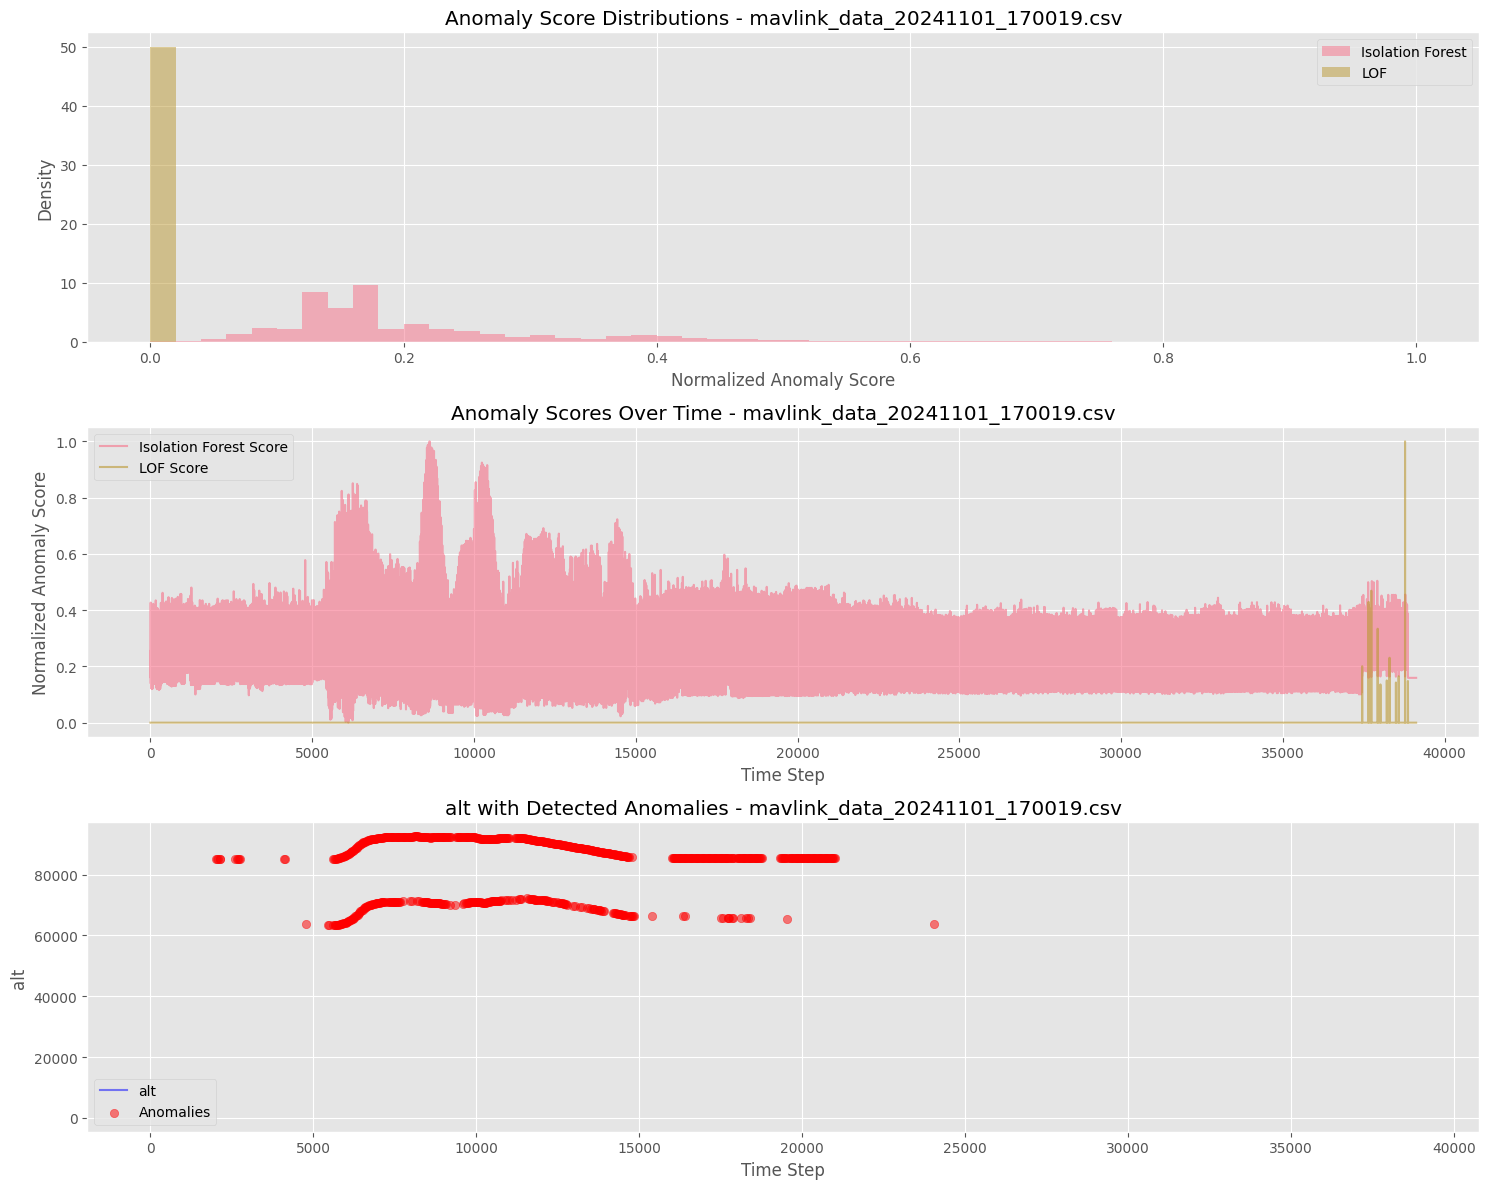


Summary Statistics:
Total data points: 39119
Isolation Forest anomalies: 4501 (11.51%)
LOF anomalies: 3761 (9.61%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.208
  Std: 0.119
  Max: 1.000
LOF scores:
  Mean: 0.000
  Std: 0.007
  Max: 1.000

Analyzing flight: mavlink_data_20241101_170936.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

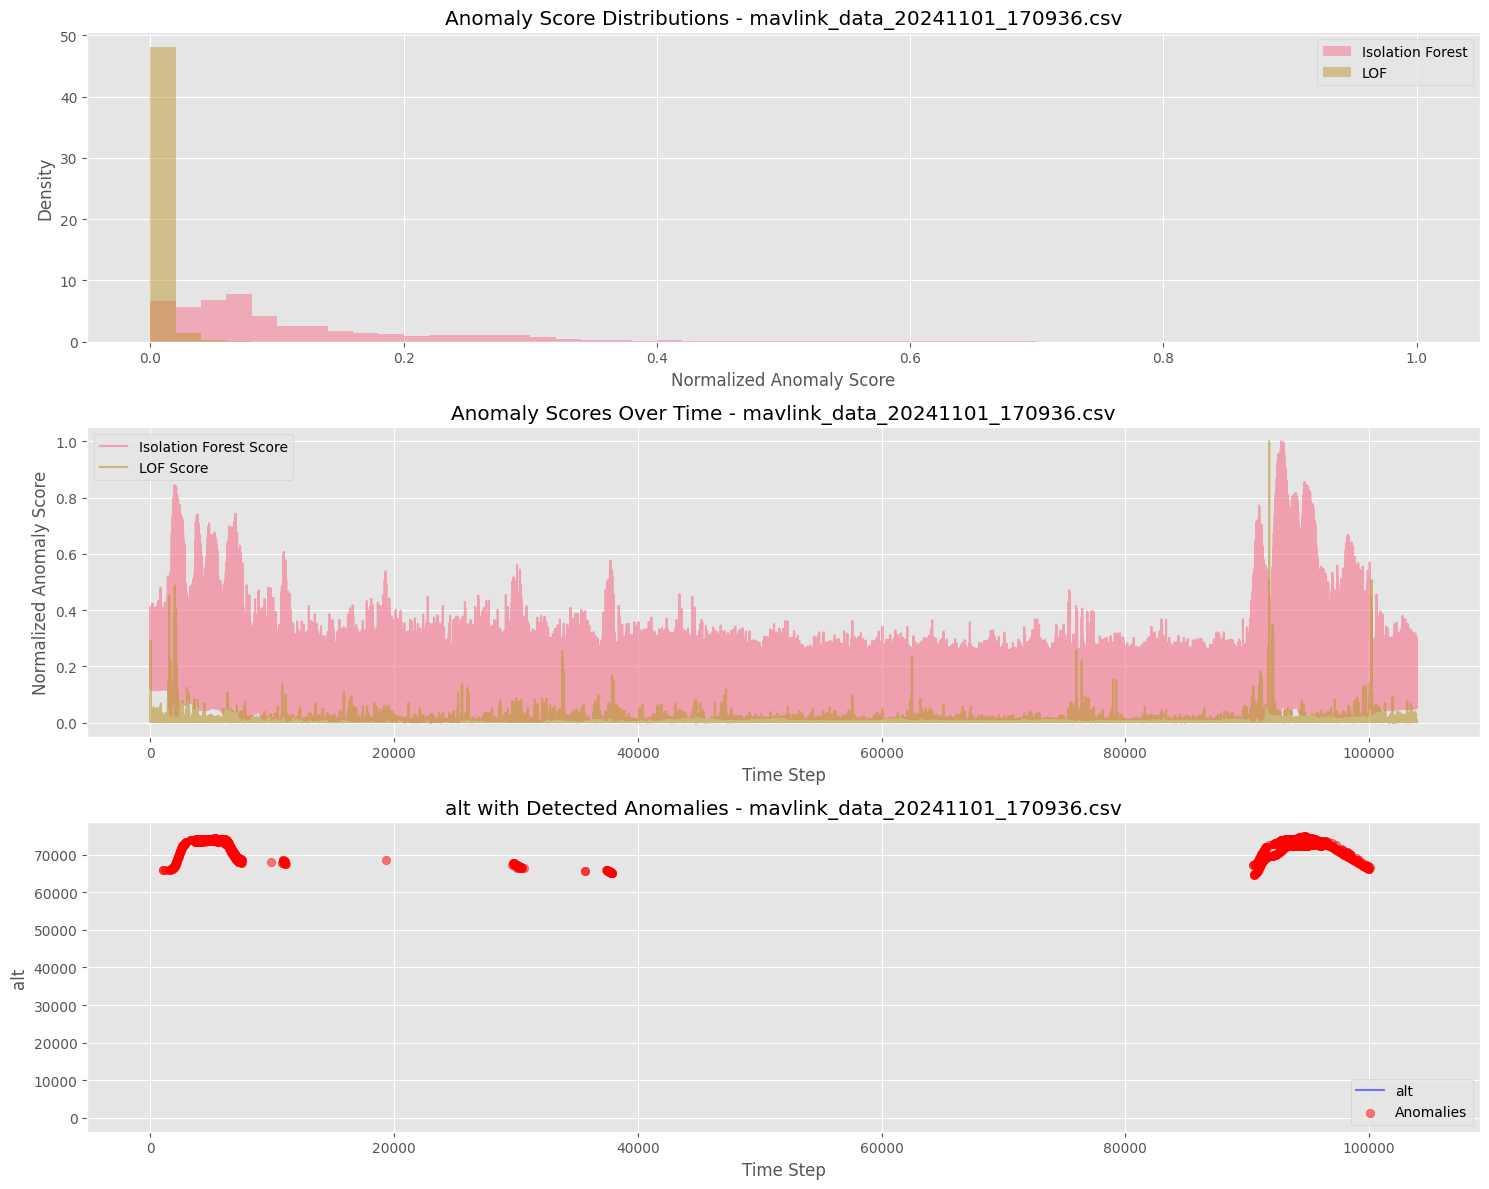


Summary Statistics:
Total data points: 103923
Isolation Forest anomalies: 4160 (4.00%)
LOF anomalies: 8887 (8.55%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.117
  Std: 0.119
  Max: 1.000
LOF scores:
  Mean: 0.006
  Std: 0.010
  Max: 1.000

Analyzing flight: mavlink_data_20241101_171646.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

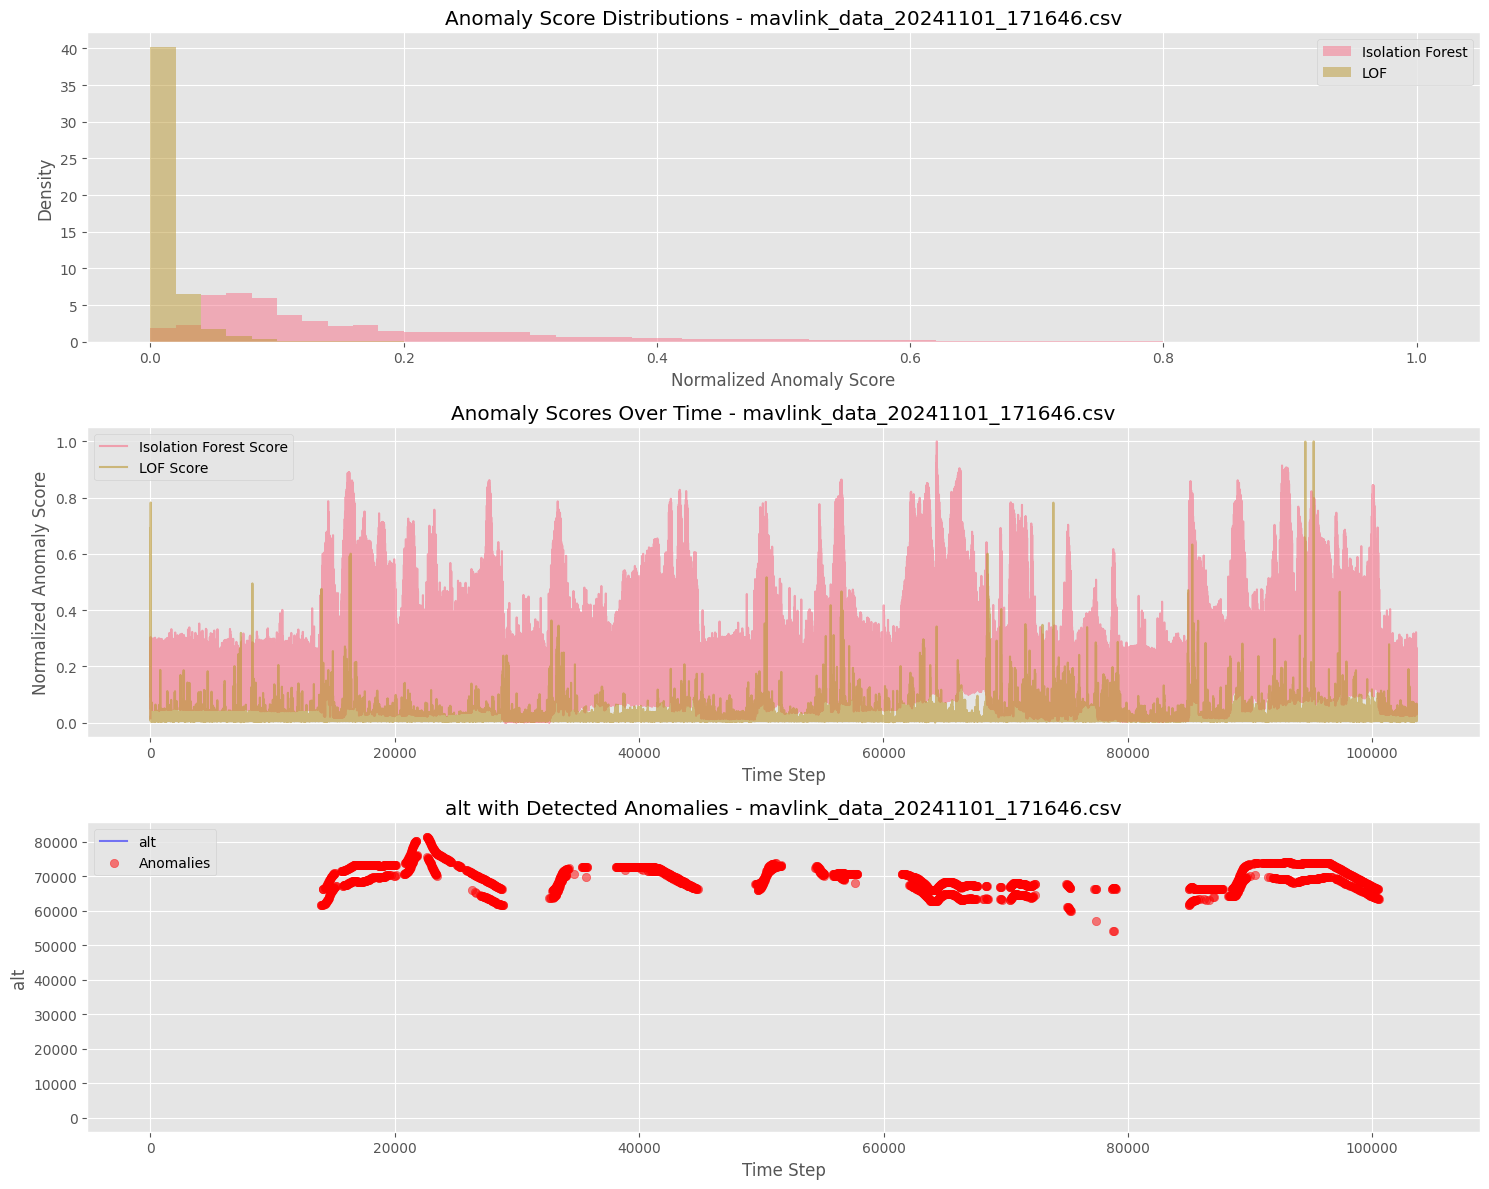


Summary Statistics:
Total data points: 103644
Isolation Forest anomalies: 10796 (10.42%)
LOF anomalies: 9941 (9.59%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.167
  Std: 0.148
  Max: 1.000
LOF scores:
  Mean: 0.016
  Std: 0.023
  Max: 1.000

Analyzing flight: mavlink_data_20241117_234604_gpj.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

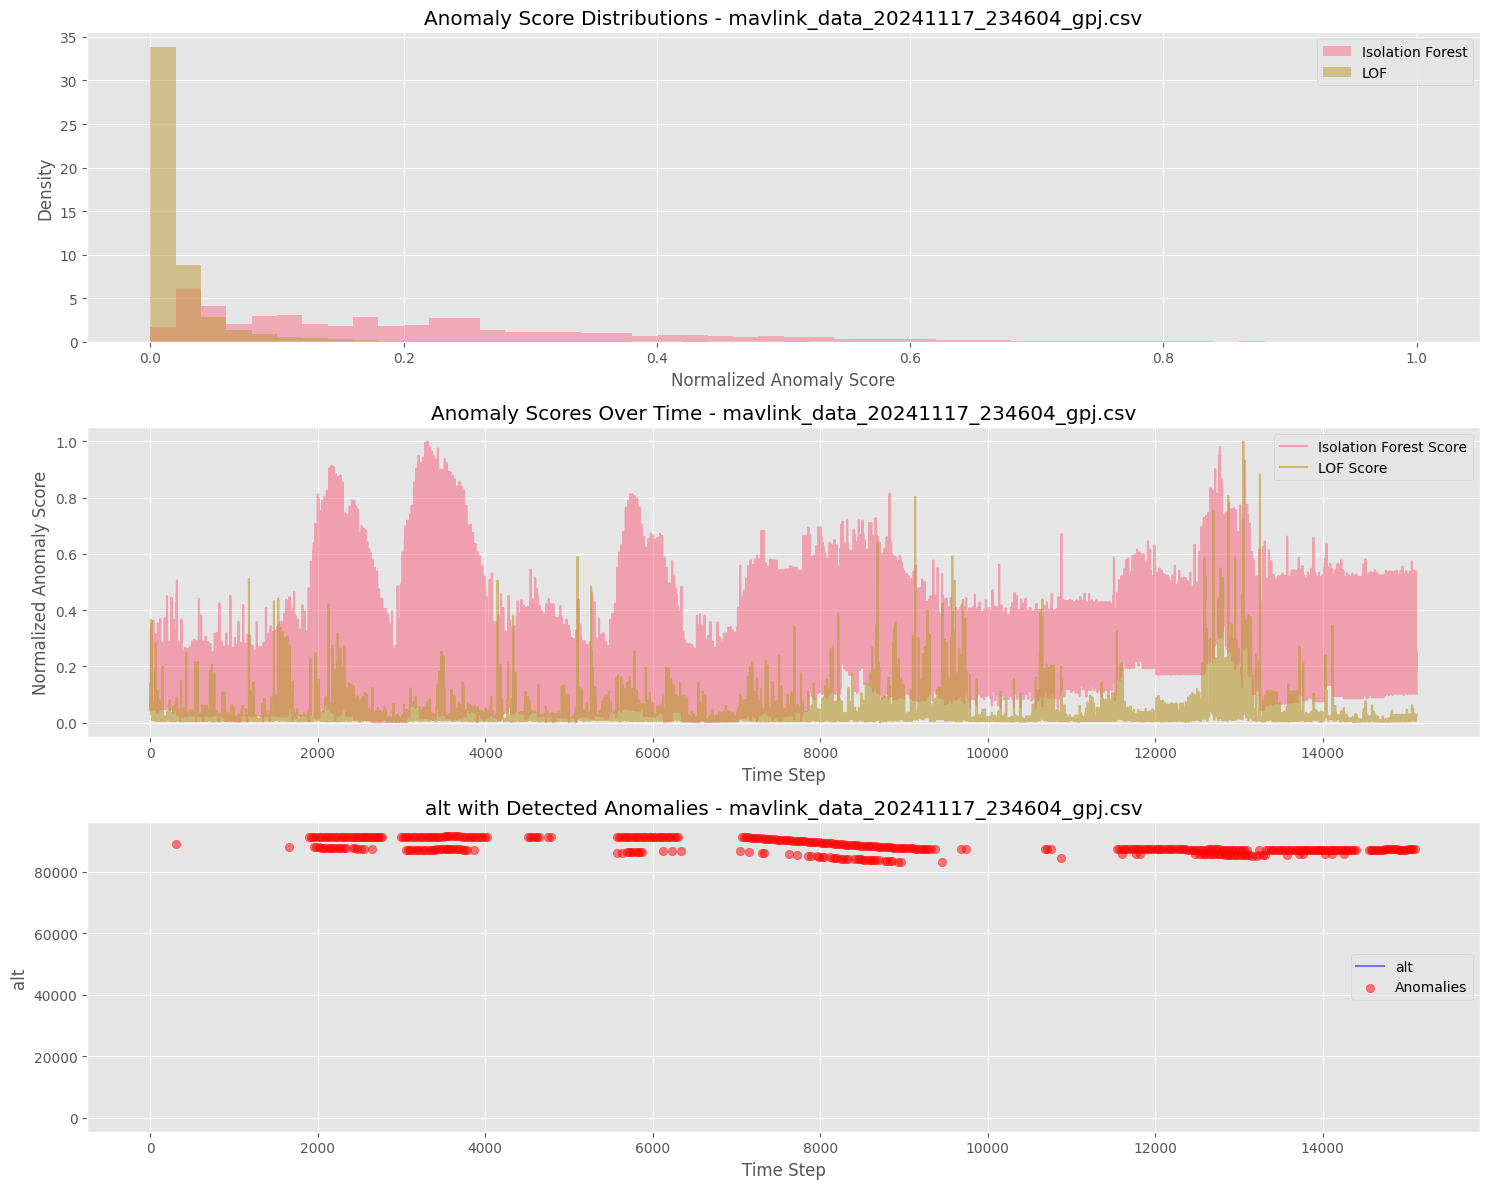


Summary Statistics:
Total data points: 15126
Isolation Forest anomalies: 1970 (13.02%)
LOF anomalies: 2043 (13.51%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.204
  Std: 0.167
  Max: 1.000
LOF scores:
  Mean: 0.028
  Std: 0.050
  Max: 1.000

Analyzing flight: mavlink_data_20241117_234716_rn.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

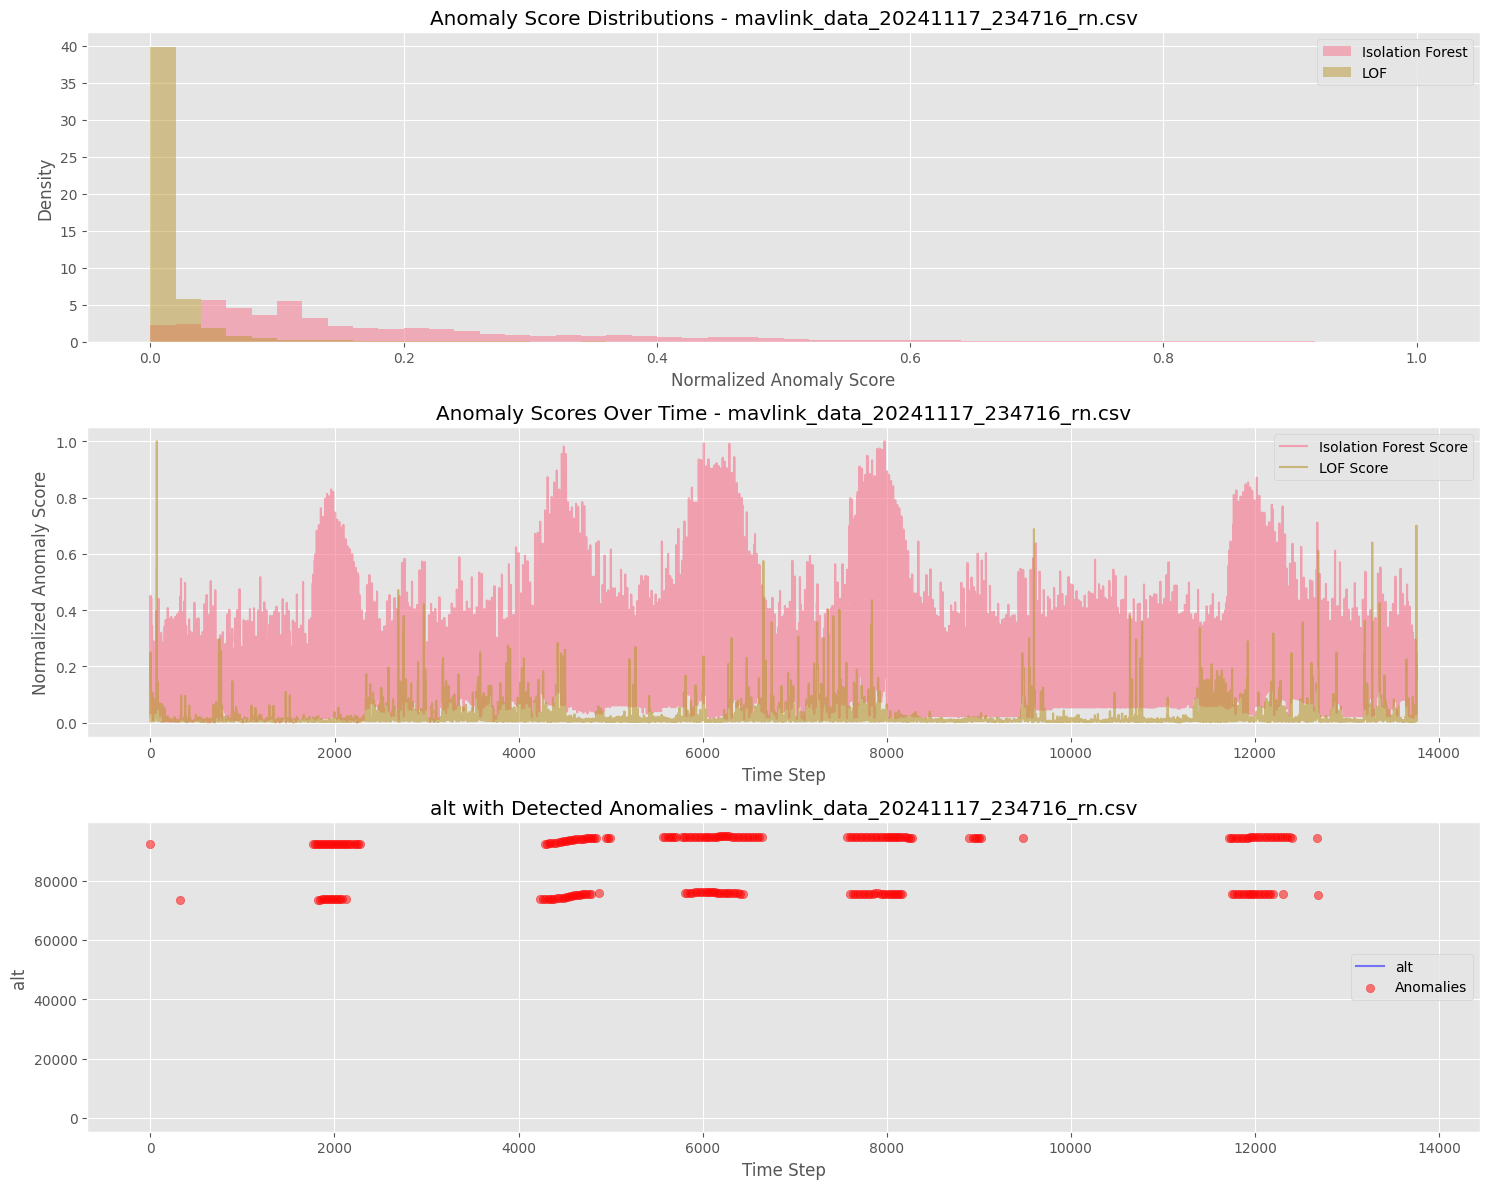


Summary Statistics:
Total data points: 13760
Isolation Forest anomalies: 1245 (9.05%)
LOF anomalies: 1993 (14.48%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.188
  Std: 0.168
  Max: 1.000
LOF scores:
  Mean: 0.019
  Std: 0.038
  Max: 1.000

Analyzing flight: mavlink_data_20241117_234731_rf.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

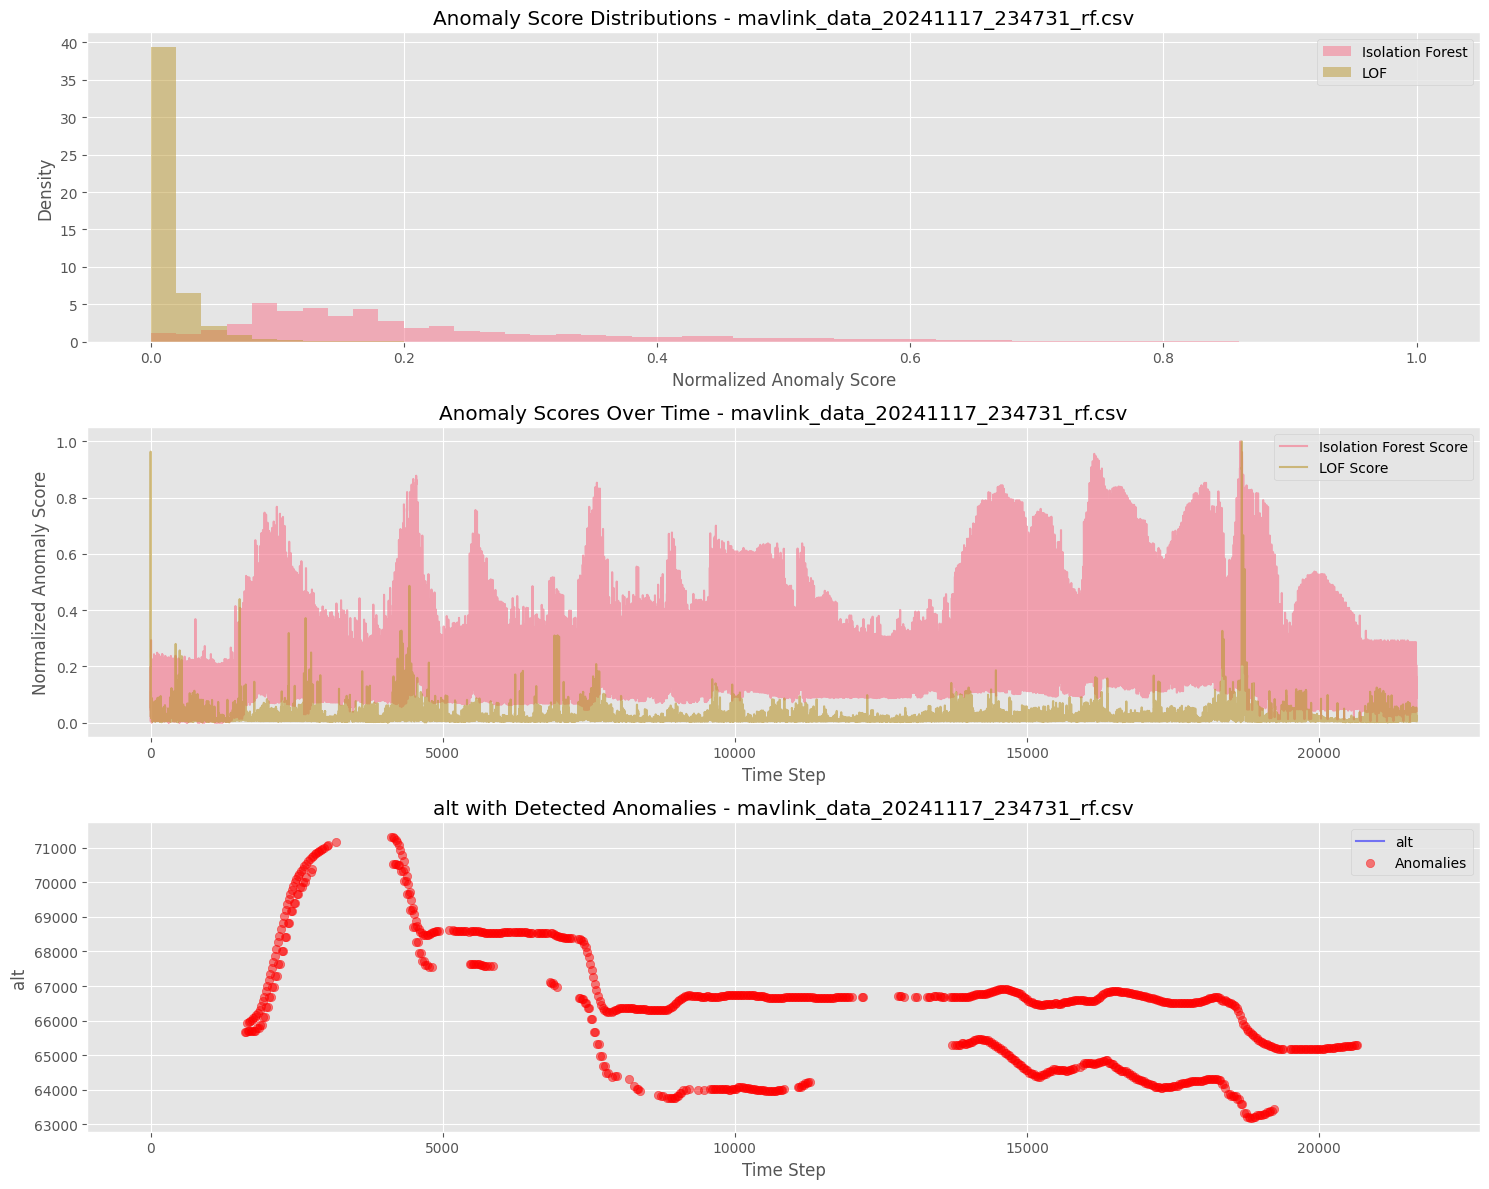


Summary Statistics:
Total data points: 21672
Isolation Forest anomalies: 4347 (20.06%)
LOF anomalies: 2302 (10.62%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.220
  Std: 0.164
  Max: 1.000
LOF scores:
  Mean: 0.017
  Std: 0.028
  Max: 1.000

Analyzing flight: mavlink_data_20241118_000809_ggd.csv


/tmp/ipykernel_5349/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/tmp/ipykernel_5349/1627332434.py:62: FutureWarning: DataFr

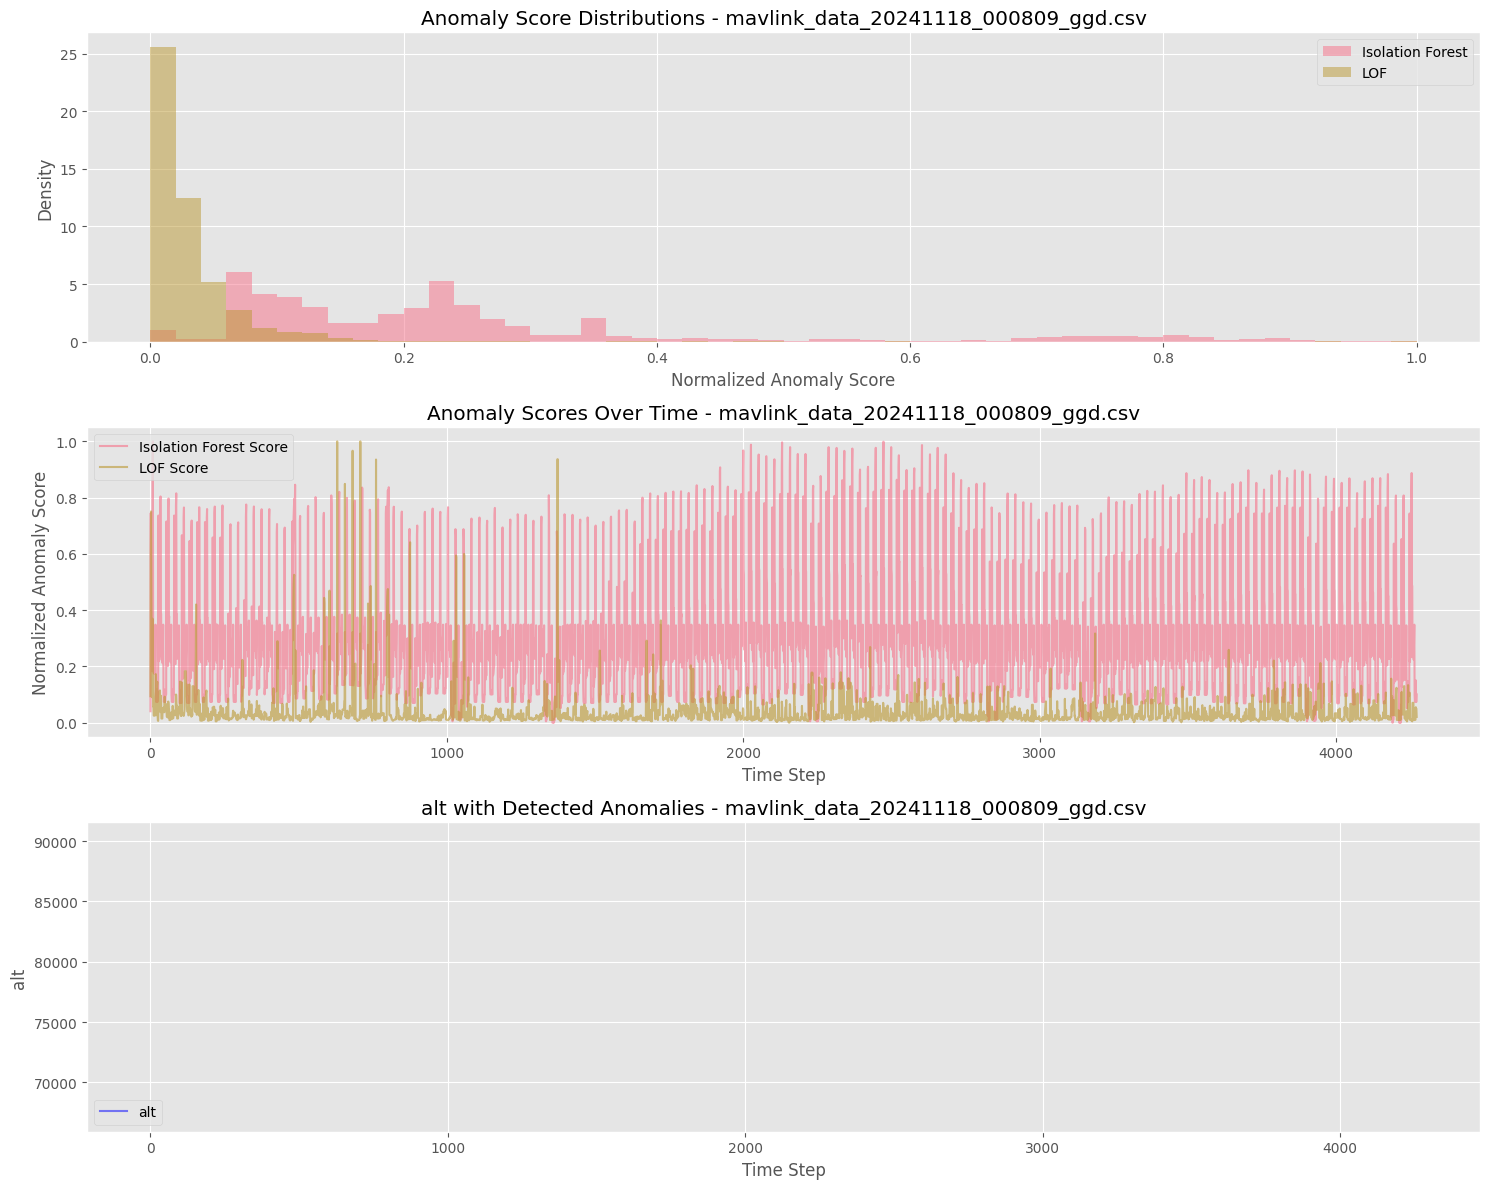


Summary Statistics:
Total data points: 4273
Isolation Forest anomalies: 0 (0.00%)
LOF anomalies: 436 (10.20%)

Score Statistics:
Isolation Forest scores:
  Mean: 0.251
  Std: 0.209
  Max: 1.000
LOF scores:
  Mean: 0.036
  Std: 0.062
  Max: 1.000

Flight Comparison Report

Anomaly Rates by Flight:
                                  flight  iso_anomaly_rate  lof_anomaly_rate
0       mavlink_data_20241031_102358.csv             19.31              9.64
1       mavlink_data_20241031_102619.csv              0.00             11.71
2       mavlink_data_20241031_102913.csv              5.11              8.91
3       mavlink_data_20241031_102918.csv              0.00            100.00
4       mavlink_data_20241031_103228.csv             10.02             12.43
5       mavlink_data_20241031_103254.csv              0.00            100.00
6       mavlink_data_20241031_103524.csv              4.88              9.51
7       mavlink_data_20241031_103539.csv              0.00             10.44
8       

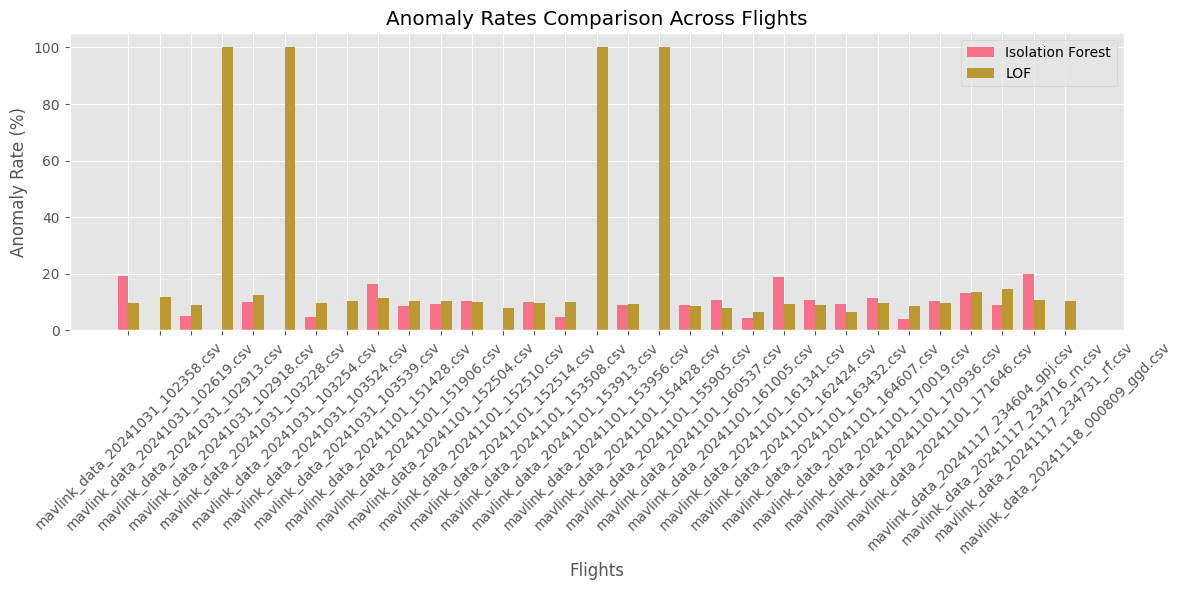

In [13]:
def evaluate_flight(iso_forest, lof, flight_df, flight_name, X_cols):
    """Evaluate models on a single flight data"""
    print(f"\nAnalyzing flight: {flight_name}")
    
    # Engineer features for this flight
    X_flight = engineer_features(flight_df)
    
    # Ensure we use the same columns as training data
    missing_cols = set(X_cols) - set(X_flight.columns)
    for col in missing_cols:
        X_flight[col] = 0  # Fill missing columns with 0
    X_flight = X_flight[X_cols]  # Reorder columns to match training data
    
    # Scale features using the same scaler
    X_flight_scaled = scaler.transform(X_flight)
    
    # Get predictions and anomaly scores
    iso_scores = -iso_forest.score_samples(X_flight_scaled)
    lof_scores = -lof.score_samples(X_flight_scaled)
    
    # Robust score normalization
    def robust_normalize(scores):
        """Normalize scores with handling for edge cases"""
        if np.all(np.isnan(scores)) or len(scores) == 0:
            return np.zeros_like(scores)
            
        # Remove any infinite values
        scores = np.nan_to_num(scores, nan=np.nanmean(scores), 
                             posinf=np.nanmax(scores[~np.isinf(scores)]), 
                             neginf=np.nanmin(scores[~np.isinf(scores)]))
        
        score_min = np.min(scores)
        score_max = np.max(scores)
        
        # Check if all scores are the same
        if score_max == score_min:
            return np.zeros_like(scores)
            
        return (scores - score_min) / (score_max - score_min)
    
    # Normalize scores
    iso_scores_norm = robust_normalize(iso_scores)
    lof_scores_norm = robust_normalize(lof_scores)
    
    # Get predictions
    iso_preds = iso_forest.predict(X_flight_scaled)
    lof_preds = lof.predict(X_flight_scaled)
    
    # Create timeline as numpy array
    timeline = np.arange(len(flight_df))
    
    # Plot results
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Score Distributions
    plt.subplot(3, 1, 1)
    if len(iso_scores_norm) > 0 and not np.all(np.isnan(iso_scores_norm)):
        plt.hist(iso_scores_norm[~np.isnan(iso_scores_norm)], 
                bins=min(50, len(np.unique(iso_scores_norm))), 
                alpha=0.5, label='Isolation Forest', density=True)
    if len(lof_scores_norm) > 0 and not np.all(np.isnan(lof_scores_norm)):
        plt.hist(lof_scores_norm[~np.isnan(lof_scores_norm)], 
                bins=min(50, len(np.unique(lof_scores_norm))), 
                alpha=0.5, label='LOF', density=True)
    plt.title(f'Anomaly Score Distributions - {flight_name}')
    plt.xlabel('Normalized Anomaly Score')
    plt.ylabel('Density')
    plt.legend()
    
    # Plot 2: Time Series with Anomalies
    plt.subplot(3, 1, 2)
    plt.plot(timeline, iso_scores_norm, label='Isolation Forest Score', alpha=0.6)
    plt.plot(timeline, lof_scores_norm, label='LOF Score', alpha=0.6)
    plt.title(f'Anomaly Scores Over Time - {flight_name}')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Anomaly Score')
    plt.legend()
    
    # Plot 3: Key Measurements with Anomalies
    plt.subplot(3, 1, 3)
    
    # Choose available metrics to plot
    metrics = ['alt', 'speed', 'current_distance']
    available_metrics = [m for m in metrics if m in flight_df.columns]
    
    if available_metrics:
        metric = available_metrics[0]  # Use first available metric
        plt.plot(timeline, flight_df[metric], 'b-', alpha=0.5, label=metric)
        
        # Find anomaly indices and plot them
        anomaly_indices = np.where(iso_preds == -1)[0]  # Get indices where anomalies occur
        if len(anomaly_indices) > 0:  # Only plot if anomalies exist
            plt.scatter(anomaly_indices, 
                       flight_df[metric].iloc[anomaly_indices],
                       c='r', label='Anomalies', alpha=0.5)
        
        plt.title(f'{metric} with Detected Anomalies - {flight_name}')
        plt.xlabel('Time Step')
        plt.ylabel(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total data points: {len(flight_df)}")
    n_iso_anomalies = np.sum(iso_preds == -1)
    n_lof_anomalies = np.sum(lof_preds == -1)
    print(f"Isolation Forest anomalies: {n_iso_anomalies} ({n_iso_anomalies/len(flight_df)*100:.2f}%)")
    print(f"LOF anomalies: {n_lof_anomalies} ({n_lof_anomalies/len(flight_df)*100:.2f}%)")
    
    # Print score statistics
    print("\nScore Statistics:")
    print("Isolation Forest scores:")
    print(f"  Mean: {np.mean(iso_scores_norm):.3f}")
    print(f"  Std: {np.std(iso_scores_norm):.3f}")
    print(f"  Max: {np.max(iso_scores_norm):.3f}")
    print("LOF scores:")
    print(f"  Mean: {np.mean(lof_scores_norm):.3f}")
    print(f"  Std: {np.std(lof_scores_norm):.3f}")
    print(f"  Max: {np.max(lof_scores_norm):.3f}")
    
    return {
        'iso_scores': iso_scores_norm,
        'lof_scores': lof_scores_norm,
        'iso_preds': iso_preds,
        'lof_preds': lof_preds
    }

def generate_flight_report(results_dict):
    """Generate a summary report comparing all flights"""
    print("\nFlight Comparison Report")
    print("=" * 50)
    
    # Prepare summary statistics
    stats = []
    for flight_name, results in results_dict.items():
        stats.append({
            'flight': flight_name,
            'iso_anomaly_rate': np.mean(results['iso_preds'] == -1) * 100,
            'lof_anomaly_rate': np.mean(results['lof_preds'] == -1) * 100,
            'mean_iso_score': np.mean(results['iso_scores']),
            'mean_lof_score': np.mean(results['lof_scores']),
            'max_iso_score': np.max(results['iso_scores']),
            'max_lof_score': np.max(results['lof_scores'])
        })
    
    # Convert to DataFrame for pretty printing
    stats_df = pd.DataFrame(stats)
    print("\nAnomaly Rates by Flight:")
    print(stats_df[['flight', 'iso_anomaly_rate', 'lof_anomaly_rate']].round(2))
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    flights = stats_df['flight']
    x = np.arange(len(flights))
    width = 0.35
    
    plt.bar(x - width/2, stats_df['iso_anomaly_rate'], width, label='Isolation Forest')
    plt.bar(x + width/2, stats_df['lof_anomaly_rate'], width, label='LOF')
    
    plt.xlabel('Flights')
    plt.ylabel('Anomaly Rate (%)')
    plt.title('Anomaly Rates Comparison Across Flights')
    plt.xticks(x, flights, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Evaluate each flight individually
print("Evaluating individual flights...")

# Store the columns used in training for consistency
X_cols = X.columns

# Group data by source file
results_dict = {}
for flight_name, flight_df in df.groupby('source_file'):
    results_dict[flight_name] = evaluate_flight(
        iso_forest, lof, flight_df, flight_name, X_cols
    )

# Generate comparison report
generate_flight_report(results_dict)

## 6. Save Models

In [16]:
def save_models(iso_forest, lof, scaler, feature_cols, output_dir='./models'):
    """Save trained models and preprocessing objects"""
    Path(output_dir).mkdir(exist_ok=True)
    
    # Save models
    joblib.dump(iso_forest, f'{output_dir}/mavlink_isolation_forest.joblib')
    joblib.dump(lof, f'{output_dir}/mavlink_lof.joblib')
    
    # Save scaler
    joblib.dump(scaler, f'{output_dir}/mavlink_scaler.joblib')
    
    # Save feature columns
    with open(f'{output_dir}/mavlink_feature_columns.txt', 'w') as f:
        f.write('\n'.join(feature_cols))
    
    print(f"Models and preprocessing objects saved to {output_dir}")

# Save all models and preprocessing objects
save_models(iso_forest, lof, scaler, X.columns, output_directory)

Models and preprocessing objects saved to ./model_output
